In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch


from darts import TimeSeries
from darts.models import TSMixerModel, NBEATSModel, Prophet, RNNModel, TiDEModel, TransformerModel
from darts.metrics import mape
from darts.datasets import AirPassengersDataset
from sklearn.model_selection import TimeSeriesSplit
from darts.dataprocessing.transformers import Scaler



import os
os.environ['CUDA_VISIBLE_DEVICES'] = ''
os.environ['OMP_NUM_THREADS'] = str(os.cpu_count())


In [88]:
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")


tensor([1.], device='mps:0')


In [89]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")


Using device: mps


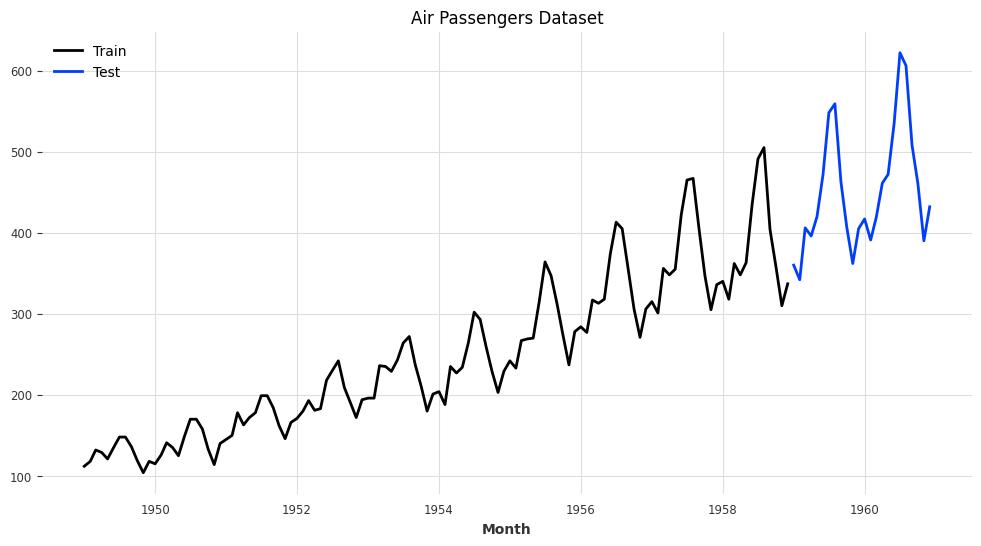

In [90]:

# Load the AirPassengers dataset
air_passengers = AirPassengersDataset().load()


air_passengers = air_passengers.astype(np.float32)


# Split the data into train and test sets (last 12 months for testing)
train, test = air_passengers.split_before(pd.Timestamp('1959-01-01'))

# Plot the data
plt.figure(figsize=(12, 6))
train.plot(label='Train')
test.plot(label='Test')
plt.legend()
plt.title('Air Passengers Dataset')
plt.show()


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 6.2 M  | train
-------------------------------------------------------------
6.2 M     Trainable params
1.4 K     Non-trainable params
6.2 M     Total params
24.787    Total estimated model params size (MB)
486       Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 3/3 [00:00<00:00,  6.60it/s, train_loss=216.0]  

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 3/3 [00:00<00:00,  6.59it/s, train_loss=216.0]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 30.69it/s]


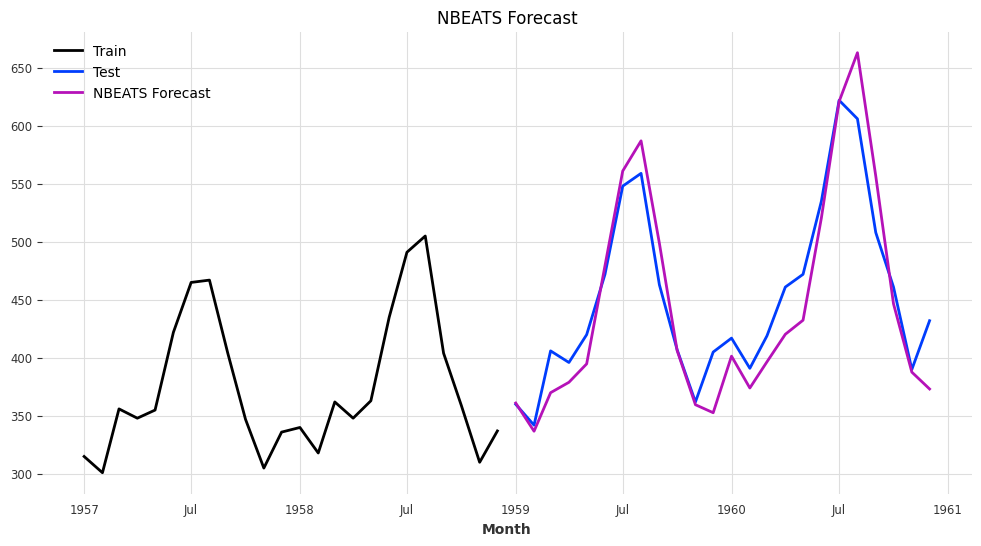

NBEATS MAPE: 5.05%


In [91]:
nbeats = NBEATSModel(
    input_chunk_length=24,
    output_chunk_length=12,
    generic_architecture=True,
    num_stacks=30,
    num_blocks=1,
    num_layers=4,
    layer_widths=256,
    expansion_coefficient_dim=5,
    trend_polynomial_degree=2,
    dropout=0.1,
    activation='ReLU',
    n_epochs=100,
    batch_size=32,
    optimizer_kwargs={'lr': 1e-3},
    random_state=42
)

# Train the model
nbeats.fit(train)

# Make predictions
nbeats_forecast = nbeats.predict(len(test))

# Plot the results
plt.figure(figsize=(12, 6))
train[-24:].plot(label='Train')
test.plot(label='Test')
nbeats_forecast.plot(label='NBEATS Forecast')
plt.legend()
plt.title('NBEATS Forecast')
plt.show()

# Calculate MAPE
nbeats_mape = mape(test, nbeats_forecast)
print(f"NBEATS MAPE: {nbeats_mape:.2f}%")

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | fc_hist             | Linear           | 300    | train
6 | feature_mixing_hist | _FeatureMixing   | 18.6 K | train
7 | conditional_mixer   | ModuleList       | 145 K  | train
8 | fc_out              | Linear           | 65     | train
-----------------------------------------------------------------
164 K     Trainable params
0         Non-trainable params
164 K     Total params
0.657     Total estimated model params size (MB)
73        Modules in t

Epoch 99: 100%|██████████| 3/3 [00:00<00:00, 43.51it/s, train_loss=6.17e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 3/3 [00:00<00:00, 43.15it/s, train_loss=6.17e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 135.79it/s]


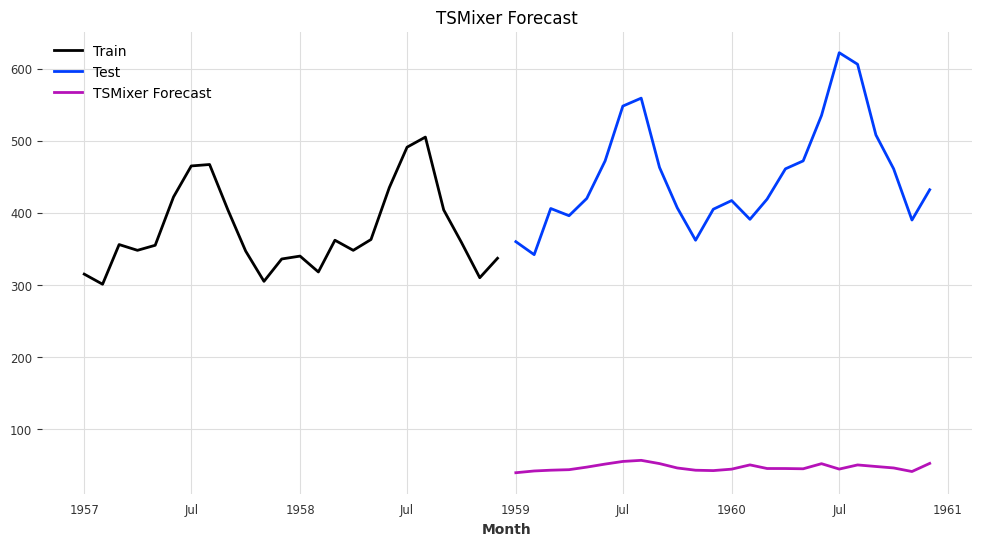

TSMixer MAPE: 89.42%


In [92]:
tsmixer = TSMixerModel(
    input_chunk_length=24,
    output_chunk_length=12,
    hidden_size=64,
    ff_size=256,
    num_blocks=4,
    activation='ReLU',
    dropout=0.1,
    norm_type='LayerNorm',
    normalize_before=False,
    use_static_covariates=True,
    n_epochs=100,
    batch_size=32,
    optimizer_kwargs={'lr': 1e-3},
    random_state=42
)

# Train the model
tsmixer.fit(train)

# Make predictions
tsmixer_forecast = tsmixer.predict(len(test))

# Plot the results
plt.figure(figsize=(12, 6))
train[-24:].plot(label='Train')
test.plot(label='Test')
tsmixer_forecast.plot(label='TSMixer Forecast')
plt.legend()
plt.title('TSMixer Forecast')
plt.show()

# Calculate MAPE
tsmixer_mape = mape(test, tsmixer_forecast)
print(f"TSMixer MAPE: {tsmixer_mape:.2f}%")

03:32:35 - cmdstanpy - INFO - Chain [1] start processing
03:32:35 - cmdstanpy - INFO - Chain [1] done processing


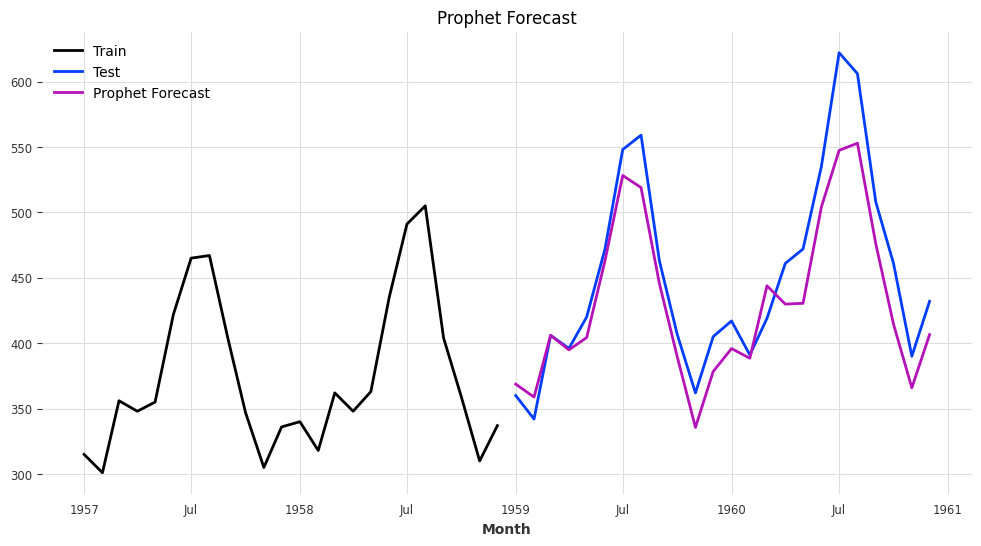

Prophet MAPE: 5.33%


In [93]:
prophet = Prophet(
    seasonality_mode='multiplicative',
    n_changepoints=20,
    changepoint_range=0.8,
    yearly_seasonality='auto',
    weekly_seasonality='auto',
    daily_seasonality='auto',
    #random_state=42
    
)

# Add country holidays separately
#prophet.add_country_holidays(country_name='US')


# Train the model
prophet.fit(train)

# Make predictions
prophet_forecast = prophet.predict(len(test))

# Plot the results
plt.figure(figsize=(12, 6))
train[-24:].plot(label='Train')
test.plot(label='Test')
prophet_forecast.plot(label='Prophet Forecast')
plt.legend()
plt.title('Prophet Forecast')
plt.show()

# Calculate MAPE
prophet_mape = mape(test, prophet_forecast)
print(f"Prophet MAPE: {prophet_mape:.2f}%")

ignoring user defined `output_chunk_length`. RNNModel uses a fixed `output_chunk_length=1`.
/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM          

Epoch 49: 100%|██████████| 3/3 [00:00<00:00, 126.93it/s, train_loss=5.47e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 3/3 [00:00<00:00, 123.88it/s, train_loss=5.47e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 144.03it/s]


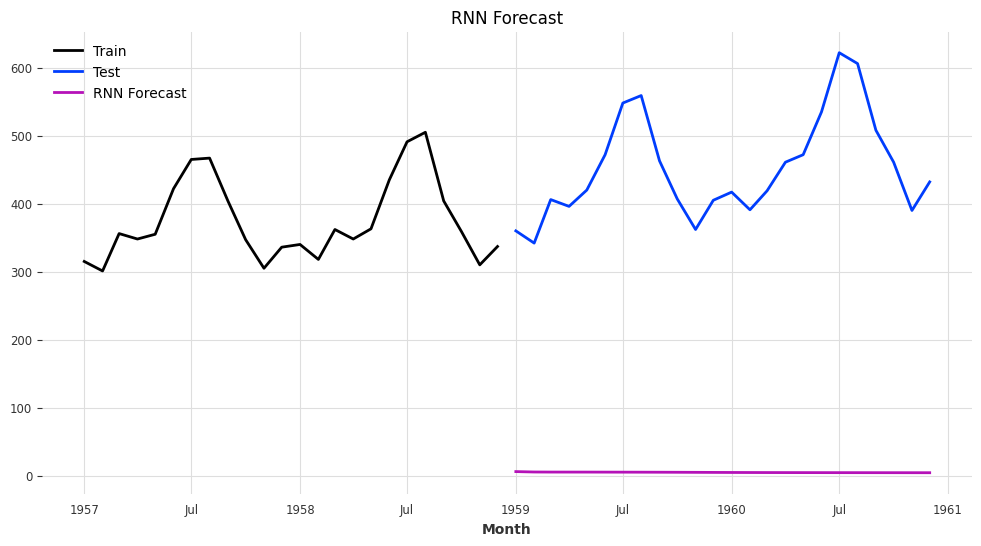

RNN MAPE: 98.91%


In [94]:
rnn_model = RNNModel(
    model="LSTM",
    hidden_dim=32,  # Reduced from 64
    n_rnn_layers=1,  # Reduced from 2
    dropout=0.1,
    batch_size=32,
    n_epochs=50,  # Reduced from 100
    optimizer_kwargs={"lr": 1e-3},
    model_name="LSTM_model",
    random_state=42,
    training_length=24,
    input_chunk_length=24,
    output_chunk_length=12,
    force_reset=True
)

# Train the model with error handling
try:
    rnn_model.fit(train)
    rnn_forecast = rnn_model.predict(len(test))
    
    # Plot the results
    plt.figure(figsize=(12, 6))
    train[-24:].plot(label='Train')
    test.plot(label='Test')
    rnn_forecast.plot(label='RNN Forecast')
    plt.legend()
    plt.title('RNN Forecast')
    plt.show()

    # Calculate MAPE
    rnn_mape = mape(test, rnn_forecast)
    print(f"RNN MAPE: {rnn_mape:.2f}%")
except Exception as e:
    print(f"An error occurred during RNN training: {str(e)}")
    rnn_mape = None

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name             | Type             | Params | Mode 
--------------------------------------------------------------
0 | criterion        | MSELoss          | 0      | train
1 | train_criterion  | MSELoss          | 0      | train
2 | val_criterion    | MSELoss          | 0      | train
3 | train_metrics    | MetricCollection | 0      | train
4 | val_metrics      | MetricCollection | 0      | train
5 | rin              | RINorm           | 2      | train
6 | encoders         | Sequential       | 23.2 K | train
7 | decoders         | Sequential       | 216 K  | train
8 | temporal_decoder | _ResidualBlock   | 4.3 K  | train
9 | lookback_skip    | Linear           | 300    | train
--------------------------------------------------------------
243 K     Trainable params
0         Non-trainable params
243 K     Total params
0.976     Total estimated model params size (MB)
3

Epoch 99: 100%|██████████| 3/3 [00:00<00:00, 70.73it/s, train_loss=439.0]  

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 3/3 [00:00<00:00, 69.86it/s, train_loss=439.0]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 172.51it/s]


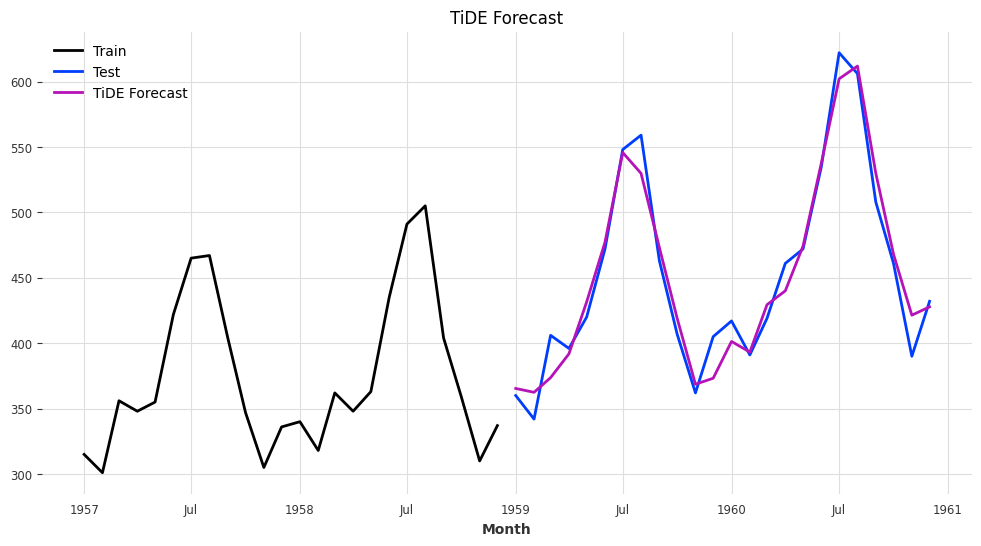

TiDE MAPE: 3.01%


In [95]:
tide_model = TiDEModel(
    input_chunk_length=24,
    output_chunk_length=12,
    decoder_output_dim=64,
    temporal_width_past=16,
    temporal_width_future=16,
    temporal_decoder_hidden=64,
    #temporal_decoder_output=32,
    use_layer_norm=True,
    use_reversible_instance_norm=True,
    n_epochs=100,
    batch_size=32,
    optimizer_kwargs={'lr': 1e-3},
    random_state=42
)

# Train the model
tide_model.fit(train)

# Make predictions
tide_forecast = tide_model.predict(len(test))

# Plot the results
plt.figure(figsize=(12, 6))
train[-24:].plot(label='Train')
test.plot(label='Test')
tide_forecast.plot(label='TiDE Forecast')
plt.legend()
plt.title('TiDE Forecast')
plt.show()

# Calculate MAPE
tide_mape = mape(test, tide_forecast)
print(f"TiDE MAPE: {tide_mape:.2f}%")

/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | tr

Epoch 99: 100%|██████████| 3/3 [00:00<00:00, 14.22it/s, train_loss=5.22e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 3/3 [00:00<00:00, 14.17it/s, train_loss=5.22e+4]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 18.30it/s]


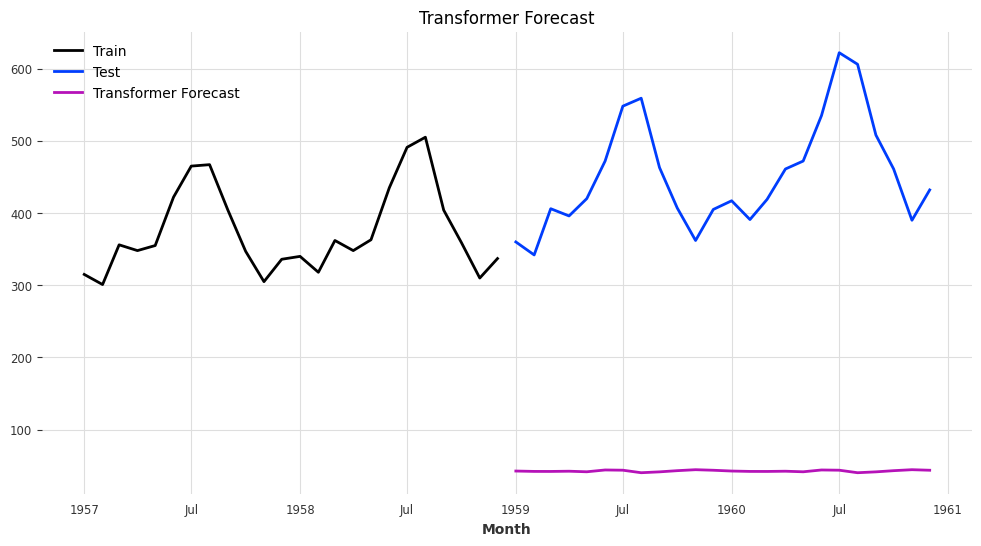

Transformer MAPE: 90.29%


In [96]:
transformer_model = TransformerModel(
    input_chunk_length=24,
    output_chunk_length=12,
    d_model=64,
    nhead=4,
    num_encoder_layers=3,
    num_decoder_layers=3,
    dim_feedforward=512,
    dropout=0.1,
    activation='relu',
    n_epochs=100,
    batch_size=32,
    optimizer_kwargs={'lr': 1e-3},
    random_state=42
)

# Train the model
transformer_model.fit(train)

# Make predictions
transformer_forecast = transformer_model.predict(len(test))

# Plot the results
plt.figure(figsize=(12, 6))
train[-24:].plot(label='Train')
test.plot(label='Test')
transformer_forecast.plot(label='Transformer Forecast')
plt.legend()
plt.title('Transformer Forecast')
plt.show()

# Calculate MAPE
transformer_mape = mape(test, transformer_forecast)
print(f"Transformer MAPE: {transformer_mape:.2f}%")


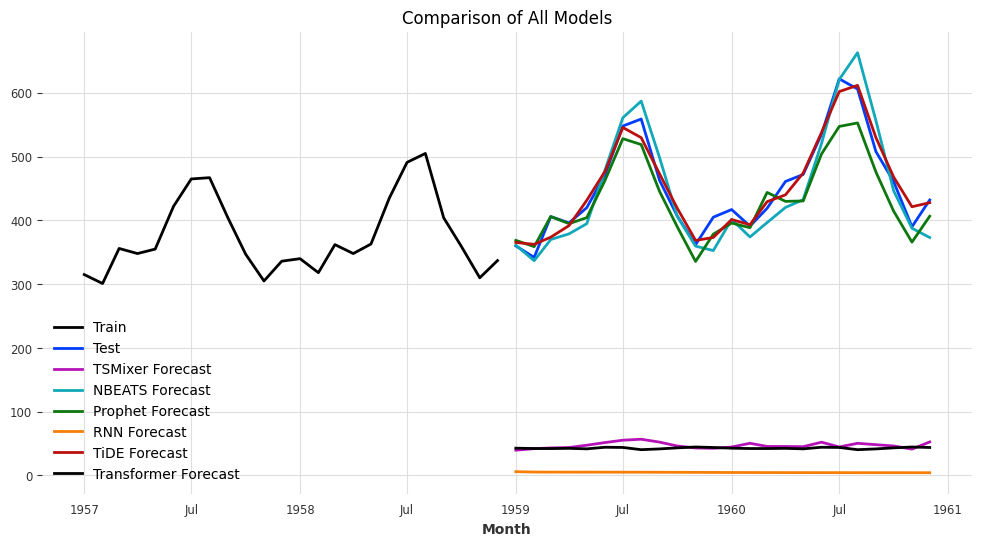

TSMixer MAPE: 89.42%
NBEATS MAPE: 5.05%
Prophet MAPE: 5.33%
RNN MAPE: 98.91%
TiDE MAPE: 3.01%
Transformer MAPE: 90.29%


In [98]:
plt.figure(figsize=(12, 6))
train[-24:].plot(label='Train')
test.plot(label='Test')
tsmixer_forecast.plot(label='TSMixer Forecast')
nbeats_forecast.plot(label='NBEATS Forecast')
prophet_forecast.plot(label='Prophet Forecast')
rnn_forecast.plot(label='RNN Forecast')
tide_forecast.plot(label='TiDE Forecast')
transformer_forecast.plot(label='Transformer Forecast')
plt.legend()
plt.title('Comparison of All Models')
plt.show()

print(f"TSMixer MAPE: {tsmixer_mape:.2f}%")
print(f"NBEATS MAPE: {nbeats_mape:.2f}%")
print(f"Prophet MAPE: {prophet_mape:.2f}%")
print(f"RNN MAPE: {rnn_mape:.2f}%")
print(f"TiDE MAPE: {tide_mape:.2f}%")
print(f"Transformer MAPE: {transformer_mape:.2f}%")

# Time Series Cross-Validation Function

## `time_series_cv(model, train_data, n_splits=3)`

This function performs time series cross-validation for a given model and training data using the TimeSeriesSplit method. It respects the temporal order of the data, which is crucial for time series forecasting.

### Key Feature: Chronological Splitting

Unlike traditional k-fold cross-validation, which randomly shuffles the data, this function maintains the temporal order of the time series. It splits the data chronologically, ensuring that:

1. Models are always trained on past data and validated on future data.
2. The temporal dependencies and patterns in the time series are preserved.
3. The evaluation simulates real-world forecasting scenarios where you use historical data to predict the future.

### Parameters

- `model` : object
  - A time series model that has `fit()` and `predict()` methods.
- `train_data` : TimeSeries
  - The training data as a Darts TimeSeries object.
- `n_splits` : int, optional (default=3)
  - The number of splits for time series cross-validation.

### Returns

- `float`
  - The mean Mean Absolute Percentage Error (MAPE) across all folds.
  - Returns infinity if no valid scores are obtained.

### Process

1. The function uses `TimeSeriesSplit` to create time-based folds.
2. For each fold:
   - It creates a training subset using data up to a certain point in time.
   - The validation subset consists of the subsequent data points.
   - With each iteration, the training set grows larger, incorporating more historical data.
3. If the training subset meets the minimum length required by the model:
   - The model is fitted on the training subset.
   - Predictions are made for the validation subset.
   - The MAPE is calculated and stored.
4. The function returns the mean of all MAPE scores.

### Advantages Over Random Cross-Validation

- Preserves time-based patterns and trends in the data.
- Prevents data leakage by ensuring future data is not used to predict past events.
- Provides a more realistic assessment of the model's performance in a true forecasting scenario.

### Notes

- If a training subset is too short (less than the model's minimum required length), that fold is skipped.
- If no valid scores are obtained (e.g., all training subsets are too short), the function returns infinity.

### Usage Example


In [76]:
def time_series_cv(model, train_data, n_splits=3):
    """
    Perform time series cross-validation for a given model and training data.

    This function uses TimeSeriesSplit to create time-based folds that respect
    the temporal order of the data. It trains the model on each fold and
    evaluates its performance using Mean Absolute Percentage Error (MAPE).

    Parameters:
    -----------
    model : object
        A time series model with fit() and predict() methods.
    train_data : TimeSeries
        The training data as a Darts TimeSeries object.
    n_splits : int, optional (default=3)
        The number of splits for time series cross-validation.

    Returns:
    --------
    float
        The mean MAPE across all folds. Returns infinity if no valid scores.

    Notes:
    ------
    - The function checks if the training subset length meets the minimum
      required by the model before fitting.
    - If no valid scores are obtained (e.g., all training subsets are too short),
      the function returns infinity.
    """
    tscv = TimeSeriesSplit(n_splits=n_splits)
    mape_scores = []
    
    for train_index, val_index in tscv.split(train_data):
        train_subset = train_data[:val_index[0]]
        val_subset = train_data[val_index[0]:val_index[-1]+1]
        
        if len(train_subset) >= model.min_train_series_length:
            model.fit(train_subset)
            predictions = model.predict(len(val_subset))
            mape_scores.append(mape(val_subset, predictions))
    
    return np.mean(mape_scores) if mape_scores else float('inf')

In [77]:

# Hyperparameter tuning for RNN
rnn_params = {
    'hidden_dim': [32, 64, 128],
    'n_rnn_layers': [1, 2],
    'dropout': [0.1, 0.2],
    'batch_size': [32, 64],
    'n_epochs': [50, 100]
}


best_rnn_mape = float('inf')
best_rnn_params = {}

for hidden_dim in rnn_params['hidden_dim']:
    for n_rnn_layers in rnn_params['n_rnn_layers']:
        for dropout in rnn_params['dropout']:
            for batch_size in rnn_params['batch_size']:
                for n_epochs in rnn_params['n_epochs']:
                    rnn_model = RNNModel(
                        model="LSTM",
                        hidden_dim=hidden_dim,
                        n_rnn_layers=n_rnn_layers,
                        dropout=dropout,
                        batch_size=batch_size,
                        n_epochs=n_epochs,
                        random_state=42,
                        training_length=24,
                        input_chunk_length=24,
                        output_chunk_length=12
                    )
                    cv_mape = time_series_cv(rnn_model, train)
                    if cv_mape < best_rnn_mape:
                        best_rnn_mape = cv_mape
                        best_rnn_params = {
                            'hidden_dim': hidden_dim,
                            'n_rnn_layers': n_rnn_layers,
                            'dropout': dropout,
                            'batch_size': batch_size,
                            'n_epochs': n_epochs
                        }

print("Best RNN parameters:", best_rnn_params)

ignoring user defined `output_chunk_length`. RNNModel uses a fixed `output_chunk_length=1`.
/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM          

Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 100.21it/s, train_loss=1.92e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 94.67it/s, train_loss=1.92e+4] 


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 114.30it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 4.5 K  | train
6 | V               | Linear           | 33     | train
-------------------------------------------------------------
4.5 K     Trainable params
0         Non-trainable params
4.5 K     Total params
0.018     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 129.93it/s, train_loss=2.54e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 125.24it/s, train_loss=2.54e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 116.47it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 4.5 K  | train
6 | V               | Linear           | 33     | train
-------------------------------------------------------------
4.5 K     Trainable params
0         Non-trainable params
4.5 K     Total params
0.018     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 3/3 [00:00<00:00, 127.19it/s, train_loss=3.26e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 3/3 [00:00<00:00, 124.01it/s, train_loss=3.26e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 119.03it/s]

ignoring user defined `output_chunk_length`. RNNModel uses a fixed `output_chunk_length=1`.


/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 4.5 K  | train
6 | V               | Linear           | 33     | train
----------------

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 94.82it/s, train_loss=1.85e+4] 

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 88.90it/s, train_loss=1.85e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 113.98it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 4.5 K  | train
6 | V               | Linear           | 33     | train
-------------------------------------------------------------
4.5 K     Trainable params
0         Non-trainable params
4.5 K     Total params
0.018     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 131.98it/s, train_loss=2.85e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 127.18it/s, train_loss=2.85e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 114.84it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 4.5 K  | train
6 | V               | Linear           | 33     | train
-------------------------------------------------------------
4.5 K     Trainable params
0         Non-trainable params
4.5 K     Total params
0.018     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 3/3 [00:00<00:00, 133.49it/s, train_loss=4.54e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 3/3 [00:00<00:00, 130.27it/s, train_loss=4.54e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 123.47it/s]

ignoring user defined `output_chunk_length`. RNNModel uses a fixed `output_chunk_length=1`.


/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 4.5 K  | train
6 | V               | Linear           | 33     | train
----------------

Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 99.17it/s, train_loss=1.92e+4] 

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 91.30it/s, train_loss=1.92e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 112.20it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 4.5 K  | train
6 | V               | Linear           | 33     | train
-------------------------------------------------------------
4.5 K     Trainable params
0         Non-trainable params
4.5 K     Total params
0.018     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 119.17it/s, train_loss=2.94e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 110.60it/s, train_loss=2.94e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 119.29it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 4.5 K  | train
6 | V               | Linear           | 33     | train
-------------------------------------------------------------
4.5 K     Trainable params
0         Non-trainable params
4.5 K     Total params
0.018     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 133.28it/s, train_loss=3.36e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 128.63it/s, train_loss=3.36e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 117.73it/s]


ignoring user defined `output_chunk_length`. RNNModel uses a fixed `output_chunk_length=1`.
/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM          

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 98.27it/s, train_loss=1.85e+4] 

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 91.75it/s, train_loss=1.85e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 109.10it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 4.5 K  | train
6 | V               | Linear           | 33     | train
-------------------------------------------------------------
4.5 K     Trainable params
0         Non-trainable params
4.5 K     Total params
0.018     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 113.69it/s, train_loss=2.8e+4] 

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 107.09it/s, train_loss=2.8e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 119.05it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 4.5 K  | train
6 | V               | Linear           | 33     | train
-------------------------------------------------------------
4.5 K     Trainable params
0         Non-trainable params
4.5 K     Total params
0.018     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 121.10it/s, train_loss=4.77e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 115.97it/s, train_loss=4.77e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 125.27it/s]


ignoring user defined `output_chunk_length`. RNNModel uses a fixed `output_chunk_length=1`.
/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM          

Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 121.12it/s, train_loss=1.92e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 112.96it/s, train_loss=1.92e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 119.74it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 4.5 K  | train
6 | V               | Linear           | 33     | train
-------------------------------------------------------------
4.5 K     Trainable params
0         Non-trainable params
4.5 K     Total params
0.018     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 137.55it/s, train_loss=2.54e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 131.77it/s, train_loss=2.54e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 134.03it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 4.5 K  | train
6 | V               | Linear           | 33     | train
-------------------------------------------------------------
4.5 K     Trainable params
0         Non-trainable params
4.5 K     Total params
0.018     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 3/3 [00:00<00:00, 132.89it/s, train_loss=3.26e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 3/3 [00:00<00:00, 129.46it/s, train_loss=3.26e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 127.16it/s]

ignoring user defined `output_chunk_length`. RNNModel uses a fixed `output_chunk_length=1`.


/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 4.5 K  | train
6 | V               | Linear           | 33     | train
----------------

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 123.03it/s, train_loss=1.85e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 115.81it/s, train_loss=1.85e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 139.34it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 4.5 K  | train
6 | V               | Linear           | 33     | train
-------------------------------------------------------------
4.5 K     Trainable params
0         Non-trainable params
4.5 K     Total params
0.018     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 134.66it/s, train_loss=2.85e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 129.86it/s, train_loss=2.85e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 130.88it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 4.5 K  | train
6 | V               | Linear           | 33     | train
-------------------------------------------------------------
4.5 K     Trainable params
0         Non-trainable params
4.5 K     Total params
0.018     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 3/3 [00:00<00:00, 140.23it/s, train_loss=4.54e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 3/3 [00:00<00:00, 136.11it/s, train_loss=4.54e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 134.61it/s]


ignoring user defined `output_chunk_length`. RNNModel uses a fixed `output_chunk_length=1`.
/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM          

Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 118.74it/s, train_loss=1.92e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 111.91it/s, train_loss=1.92e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 139.06it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 4.5 K  | train
6 | V               | Linear           | 33     | train
-------------------------------------------------------------
4.5 K     Trainable params
0         Non-trainable params
4.5 K     Total params
0.018     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 122.34it/s, train_loss=2.94e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 113.65it/s, train_loss=2.94e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 136.09it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 4.5 K  | train
6 | V               | Linear           | 33     | train
-------------------------------------------------------------
4.5 K     Trainable params
0         Non-trainable params
4.5 K     Total params
0.018     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 147.06it/s, train_loss=3.36e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 141.08it/s, train_loss=3.36e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 132.61it/s]


ignoring user defined `output_chunk_length`. RNNModel uses a fixed `output_chunk_length=1`.
/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM          

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 118.15it/s, train_loss=1.85e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 110.78it/s, train_loss=1.85e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 133.21it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 4.5 K  | train
6 | V               | Linear           | 33     | train
-------------------------------------------------------------
4.5 K     Trainable params
0         Non-trainable params
4.5 K     Total params
0.018     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 130.14it/s, train_loss=2.8e+4] 

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 121.83it/s, train_loss=2.8e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 133.42it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 4.5 K  | train
6 | V               | Linear           | 33     | train
-------------------------------------------------------------
4.5 K     Trainable params
0         Non-trainable params
4.5 K     Total params
0.018     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 143.77it/s, train_loss=4.77e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 138.53it/s, train_loss=4.77e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 131.19it/s]


ignoring user defined `output_chunk_length`. RNNModel uses a fixed `output_chunk_length=1`.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 12.9 K | train
6 | V               | Linear           | 33     | train
-------------------------------------------------------------
13.0 K    Trainable params
0         Non-trainable params
13.0 K    Total params
0.052     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 97.85it/s, train_loss=1.88e+4] 

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 93.43it/s, train_loss=1.88e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 99.67it/s] 


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 12.9 K | train
6 | V               | Linear           | 33     | train
-------------------------------------------------------------
13.0 K    Trainable params
0         Non-trainable params
13.0 K    Total params
0.052     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 115.49it/s, train_loss=2.5e+4] 

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 112.08it/s, train_loss=2.5e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 96.10it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 12.9 K | train
6 | V               | Linear           | 33     | train
-------------------------------------------------------------
13.0 K    Trainable params
0         Non-trainable params
13.0 K    Total params
0.052     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 3/3 [00:00<00:00, 122.62it/s, train_loss=3.2e+4] 

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 3/3 [00:00<00:00, 120.08it/s, train_loss=3.2e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 95.67it/s]


ignoring user defined `output_chunk_length`. RNNModel uses a fixed `output_chunk_length=1`.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 12.9 K | train
6 | V               | Linear           | 33     | train
-------------------------------------------------------------
13.0 K    Trainable params
0         Non-trainable params
13.0 K    Total params
0.052     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 100.13it/s, train_loss=1.81e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 94.68it/s, train_loss=1.81e+4] 


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 93.81it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 12.9 K | train
6 | V               | Linear           | 33     | train
-------------------------------------------------------------
13.0 K    Trainable params
0         Non-trainable params
13.0 K    Total params
0.052     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 120.21it/s, train_loss=2.78e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 116.66it/s, train_loss=2.78e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 96.68it/s] 


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 12.9 K | train
6 | V               | Linear           | 33     | train
-------------------------------------------------------------
13.0 K    Trainable params
0         Non-trainable params
13.0 K    Total params
0.052     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 3/3 [00:00<00:00, 108.97it/s, train_loss=4.39e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 3/3 [00:00<00:00, 106.78it/s, train_loss=4.39e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 92.78it/s]


ignoring user defined `output_chunk_length`. RNNModel uses a fixed `output_chunk_length=1`.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 12.9 K | train
6 | V               | Linear           | 33     | train
-------------------------------------------------------------
13.0 K    Trainable params
0         Non-trainable params
13.0 K    Total params
0.052     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 90.97it/s, train_loss=1.88e+4] 

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 86.66it/s, train_loss=1.88e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 86.15it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 12.9 K | train
6 | V               | Linear           | 33     | train
-------------------------------------------------------------
13.0 K    Trainable params
0         Non-trainable params
13.0 K    Total params
0.052     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 120.35it/s, train_loss=2.88e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 113.87it/s, train_loss=2.88e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 85.81it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 12.9 K | train
6 | V               | Linear           | 33     | train
-------------------------------------------------------------
13.0 K    Trainable params
0         Non-trainable params
13.0 K    Total params
0.052     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 114.11it/s, train_loss=3.31e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 110.41it/s, train_loss=3.31e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 97.53it/s] 


ignoring user defined `output_chunk_length`. RNNModel uses a fixed `output_chunk_length=1`.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 12.9 K | train
6 | V               | Linear           | 33     | train
-------------------------------------------------------------
13.0 K    Trainable params
0         Non-trainable params
13.0 K    Total params
0.052     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 104.69it/s, train_loss=1.81e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 99.10it/s, train_loss=1.81e+4] 


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 93.44it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 12.9 K | train
6 | V               | Linear           | 33     | train
-------------------------------------------------------------
13.0 K    Trainable params
0         Non-trainable params
13.0 K    Total params
0.052     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 112.79it/s, train_loss=2.75e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 105.19it/s, train_loss=2.75e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 89.80it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 12.9 K | train
6 | V               | Linear           | 33     | train
-------------------------------------------------------------
13.0 K    Trainable params
0         Non-trainable params
13.0 K    Total params
0.052     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 109.99it/s, train_loss=4.66e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 106.83it/s, train_loss=4.66e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 89.38it/s]


ignoring user defined `output_chunk_length`. RNNModel uses a fixed `output_chunk_length=1`.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 12.9 K | train
6 | V               | Linear           | 33     | train
-------------------------------------------------------------
13.0 K    Trainable params
0         Non-trainable params
13.0 K    Total params
0.052     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 103.70it/s, train_loss=1.88e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 97.69it/s, train_loss=1.88e+4] 


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 95.02it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 12.9 K | train
6 | V               | Linear           | 33     | train
-------------------------------------------------------------
13.0 K    Trainable params
0         Non-trainable params
13.0 K    Total params
0.052     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 129.67it/s, train_loss=2.5e+4] 

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 125.53it/s, train_loss=2.5e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 93.66it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 12.9 K | train
6 | V               | Linear           | 33     | train
-------------------------------------------------------------
13.0 K    Trainable params
0         Non-trainable params
13.0 K    Total params
0.052     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 3/3 [00:00<00:00, 124.21it/s, train_loss=3.19e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 3/3 [00:00<00:00, 121.56it/s, train_loss=3.19e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 25.64it/s]


ignoring user defined `output_chunk_length`. RNNModel uses a fixed `output_chunk_length=1`.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 12.9 K | train
6 | V               | Linear           | 33     | train
-------------------------------------------------------------
13.0 K    Trainable params
0         Non-trainable params
13.0 K    Total params
0.052     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 115.86it/s, train_loss=1.8e+4] 

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 108.98it/s, train_loss=1.8e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 91.60it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 12.9 K | train
6 | V               | Linear           | 33     | train
-------------------------------------------------------------
13.0 K    Trainable params
0         Non-trainable params
13.0 K    Total params
0.052     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 117.61it/s, train_loss=2.78e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 114.00it/s, train_loss=2.78e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 95.32it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 12.9 K | train
6 | V               | Linear           | 33     | train
-------------------------------------------------------------
13.0 K    Trainable params
0         Non-trainable params
13.0 K    Total params
0.052     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 3/3 [00:00<00:00, 121.38it/s, train_loss=4.38e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 3/3 [00:00<00:00, 118.31it/s, train_loss=4.38e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 92.52it/s]


ignoring user defined `output_chunk_length`. RNNModel uses a fixed `output_chunk_length=1`.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 12.9 K | train
6 | V               | Linear           | 33     | train
-------------------------------------------------------------
13.0 K    Trainable params
0         Non-trainable params
13.0 K    Total params
0.052     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 100.56it/s, train_loss=1.88e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 94.36it/s, train_loss=1.88e+4] 


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 94.66it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 12.9 K | train
6 | V               | Linear           | 33     | train
-------------------------------------------------------------
13.0 K    Trainable params
0         Non-trainable params
13.0 K    Total params
0.052     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 114.98it/s, train_loss=2.87e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 107.11it/s, train_loss=2.87e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 95.68it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 12.9 K | train
6 | V               | Linear           | 33     | train
-------------------------------------------------------------
13.0 K    Trainable params
0         Non-trainable params
13.0 K    Total params
0.052     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 111.11it/s, train_loss=3.31e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 107.89it/s, train_loss=3.31e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 93.55it/s]


ignoring user defined `output_chunk_length`. RNNModel uses a fixed `output_chunk_length=1`.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 12.9 K | train
6 | V               | Linear           | 33     | train
-------------------------------------------------------------
13.0 K    Trainable params
0         Non-trainable params
13.0 K    Total params
0.052     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 93.70it/s, train_loss=1.8e+4]  

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 88.38it/s, train_loss=1.8e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 93.01it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 12.9 K | train
6 | V               | Linear           | 33     | train
-------------------------------------------------------------
13.0 K    Trainable params
0         Non-trainable params
13.0 K    Total params
0.052     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 111.30it/s, train_loss=2.75e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 105.66it/s, train_loss=2.75e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 86.77it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 12.9 K | train
6 | V               | Linear           | 33     | train
-------------------------------------------------------------
13.0 K    Trainable params
0         Non-trainable params
13.0 K    Total params
0.052     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 115.38it/s, train_loss=4.65e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 111.15it/s, train_loss=4.65e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 94.81it/s]

ignoring user defined `output_chunk_length`. RNNModel uses a fixed `output_chunk_length=1`.


/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 17.2 K | train
6 | V               | Linear           | 65     | train
----------------

Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 126.09it/s, train_loss=1.91e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 118.28it/s, train_loss=1.91e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 119.69it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 17.2 K | train
6 | V               | Linear           | 65     | train
-------------------------------------------------------------
17.2 K    Trainable params
0         Non-trainable params
17.2 K    Total params
0.069     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 131.23it/s, train_loss=2.46e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 126.62it/s, train_loss=2.46e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 127.25it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 17.2 K | train
6 | V               | Linear           | 65     | train
-------------------------------------------------------------
17.2 K    Trainable params
0         Non-trainable params
17.2 K    Total params
0.069     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 3/3 [00:00<00:00, 156.84it/s, train_loss=3.04e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 3/3 [00:00<00:00, 151.24it/s, train_loss=3.04e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 117.66it/s]


ignoring user defined `output_chunk_length`. RNNModel uses a fixed `output_chunk_length=1`.
/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM          

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 132.64it/s, train_loss=1.81e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 123.75it/s, train_loss=1.81e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.98it/s] 


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 17.2 K | train
6 | V               | Linear           | 65     | train
-------------------------------------------------------------
17.2 K    Trainable params
0         Non-trainable params
17.2 K    Total params
0.069     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 153.15it/s, train_loss=26547.0]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 145.65it/s, train_loss=26547.0]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 132.12it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 17.2 K | train
6 | V               | Linear           | 65     | train
-------------------------------------------------------------
17.2 K    Trainable params
0         Non-trainable params
17.2 K    Total params
0.069     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 3/3 [00:00<00:00, 137.29it/s, train_loss=3.99e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 3/3 [00:00<00:00, 133.53it/s, train_loss=3.99e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 121.70it/s]


ignoring user defined `output_chunk_length`. RNNModel uses a fixed `output_chunk_length=1`.
/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM          

Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 128.23it/s, train_loss=1.91e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 119.59it/s, train_loss=1.91e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 128.19it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 17.2 K | train
6 | V               | Linear           | 65     | train
-------------------------------------------------------------
17.2 K    Trainable params
0         Non-trainable params
17.2 K    Total params
0.069     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 137.57it/s, train_loss=2.88e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 128.72it/s, train_loss=2.88e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 131.25it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 17.2 K | train
6 | V               | Linear           | 65     | train
-------------------------------------------------------------
17.2 K    Trainable params
0         Non-trainable params
17.2 K    Total params
0.069     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 119.26it/s, train_loss=3.24e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 115.61it/s, train_loss=3.24e+4]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 128.37it/s]

ignoring user defined `output_chunk_length`. RNNModel uses a fixed `output_chunk_length=1`.
/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 17.2 K | train
6 | V               | Linear           | 65     | train
-------------------------------------------------------------
17.2 K    Trainable params
0         Non-trainable params
17.2 K    Total params
0.069     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 133.00it/s, train_loss=1.81e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 122.22it/s, train_loss=1.81e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 132.20it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 17.2 K | train
6 | V               | Linear           | 65     | train
-------------------------------------------------------------
17.2 K    Trainable params
0         Non-trainable params
17.2 K    Total params
0.069     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 145.80it/s, train_loss=2.7e+4] 

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 135.76it/s, train_loss=2.7e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 131.04it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 17.2 K | train
6 | V               | Linear           | 65     | train
-------------------------------------------------------------
17.2 K    Trainable params
0         Non-trainable params
17.2 K    Total params
0.069     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 141.42it/s, train_loss=4.4e+4] 

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 135.84it/s, train_loss=4.4e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 125.39it/s]

ignoring user defined `output_chunk_length`. RNNModel uses a fixed `output_chunk_length=1`.


/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 17.2 K | train
6 | V               | Linear           | 65     | train
----------------

Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 120.15it/s, train_loss=1.91e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 113.25it/s, train_loss=1.91e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 115.79it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 17.2 K | train
6 | V               | Linear           | 65     | train
-------------------------------------------------------------
17.2 K    Trainable params
0         Non-trainable params
17.2 K    Total params
0.069     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 149.36it/s, train_loss=2.46e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 143.01it/s, train_loss=2.46e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 118.34it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 17.2 K | train
6 | V               | Linear           | 65     | train
-------------------------------------------------------------
17.2 K    Trainable params
0         Non-trainable params
17.2 K    Total params
0.069     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 3/3 [00:00<00:00, 162.14it/s, train_loss=3.04e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 3/3 [00:00<00:00, 157.58it/s, train_loss=3.04e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 128.29it/s]


ignoring user defined `output_chunk_length`. RNNModel uses a fixed `output_chunk_length=1`.
/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM          

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 129.60it/s, train_loss=1.81e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 121.63it/s, train_loss=1.81e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 134.91it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 17.2 K | train
6 | V               | Linear           | 65     | train
-------------------------------------------------------------
17.2 K    Trainable params
0         Non-trainable params
17.2 K    Total params
0.069     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 155.50it/s, train_loss=26547.0]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 148.01it/s, train_loss=26547.0]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 118.28it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 17.2 K | train
6 | V               | Linear           | 65     | train
-------------------------------------------------------------
17.2 K    Trainable params
0         Non-trainable params
17.2 K    Total params
0.069     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 3/3 [00:00<00:00, 143.96it/s, train_loss=3.99e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 3/3 [00:00<00:00, 140.16it/s, train_loss=3.99e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 121.21it/s]


ignoring user defined `output_chunk_length`. RNNModel uses a fixed `output_chunk_length=1`.
/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM          

Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 131.65it/s, train_loss=1.91e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 122.87it/s, train_loss=1.91e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 133.37it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 17.2 K | train
6 | V               | Linear           | 65     | train
-------------------------------------------------------------
17.2 K    Trainable params
0         Non-trainable params
17.2 K    Total params
0.069     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 111.18it/s, train_loss=2.88e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 104.32it/s, train_loss=2.88e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 127.44it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 17.2 K | train
6 | V               | Linear           | 65     | train
-------------------------------------------------------------
17.2 K    Trainable params
0         Non-trainable params
17.2 K    Total params
0.069     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 146.15it/s, train_loss=3.24e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 140.75it/s, train_loss=3.24e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 123.17it/s]

ignoring user defined `output_chunk_length`. RNNModel uses a fixed `output_chunk_length=1`.


/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 17.2 K | train
6 | V               | Linear           | 65     | train
----------------

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 128.87it/s, train_loss=1.81e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 120.39it/s, train_loss=1.81e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 132.05it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 17.2 K | train
6 | V               | Linear           | 65     | train
-------------------------------------------------------------
17.2 K    Trainable params
0         Non-trainable params
17.2 K    Total params
0.069     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 141.22it/s, train_loss=2.7e+4] 

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 131.94it/s, train_loss=2.7e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 131.11it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 17.2 K | train
6 | V               | Linear           | 65     | train
-------------------------------------------------------------
17.2 K    Trainable params
0         Non-trainable params
17.2 K    Total params
0.069     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 130.60it/s, train_loss=4.4e+4] 

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 126.16it/s, train_loss=4.4e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 122.06it/s]

ignoring user defined `output_chunk_length`. RNNModel uses a fixed `output_chunk_length=1`.


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 50.4 K | train
6 | V               | Linear           | 65     | train
-------------------------------------------------------------
50.5 K    Trainable params
0         Non-trainable params
50.5 K    Total params
0.202     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 96.06it/s, train_loss=1.83e+4] 

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 90.38it/s, train_loss=1.83e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 85.76it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 50.4 K | train
6 | V               | Linear           | 65     | train
-------------------------------------------------------------
50.5 K    Trainable params
0         Non-trainable params
50.5 K    Total params
0.202     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 109.41it/s, train_loss=2.34e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 105.82it/s, train_loss=2.34e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 89.70it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 50.4 K | train
6 | V               | Linear           | 65     | train
-------------------------------------------------------------
50.5 K    Trainable params
0         Non-trainable params
50.5 K    Total params
0.202     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 3/3 [00:00<00:00, 113.27it/s, train_loss=2.87e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 3/3 [00:00<00:00, 110.65it/s, train_loss=2.87e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.96it/s]


ignoring user defined `output_chunk_length`. RNNModel uses a fixed `output_chunk_length=1`.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 50.4 K | train
6 | V               | Linear           | 65     | train
-------------------------------------------------------------
50.5 K    Trainable params
0         Non-trainable params
50.5 K    Total params
0.202     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 87.38it/s, train_loss=1.71e+4] 

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 82.68it/s, train_loss=1.71e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 85.37it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 50.4 K | train
6 | V               | Linear           | 65     | train
-------------------------------------------------------------
50.5 K    Trainable params
0         Non-trainable params
50.5 K    Total params
0.202     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 72.41it/s, train_loss=2.47e+4] 

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 70.38it/s, train_loss=2.47e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 62.41it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 50.4 K | train
6 | V               | Linear           | 65     | train
-------------------------------------------------------------
50.5 K    Trainable params
0         Non-trainable params
50.5 K    Total params
0.202     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 3/3 [00:00<00:00, 118.40it/s, train_loss=3.64e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 3/3 [00:00<00:00, 116.15it/s, train_loss=3.64e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 88.36it/s]


ignoring user defined `output_chunk_length`. RNNModel uses a fixed `output_chunk_length=1`.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 50.4 K | train
6 | V               | Linear           | 65     | train
-------------------------------------------------------------
50.5 K    Trainable params
0         Non-trainable params
50.5 K    Total params
0.202     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 107.56it/s, train_loss=1.83e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 100.65it/s, train_loss=1.83e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.92it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 50.4 K | train
6 | V               | Linear           | 65     | train
-------------------------------------------------------------
50.5 K    Trainable params
0         Non-trainable params
50.5 K    Total params
0.202     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 92.79it/s, train_loss=2.75e+4] 

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 87.98it/s, train_loss=2.75e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 90.47it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 50.4 K | train
6 | V               | Linear           | 65     | train
-------------------------------------------------------------
50.5 K    Trainable params
0         Non-trainable params
50.5 K    Total params
0.202     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 103.99it/s, train_loss=3.08e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 100.62it/s, train_loss=3.08e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 85.20it/s]


ignoring user defined `output_chunk_length`. RNNModel uses a fixed `output_chunk_length=1`.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 50.4 K | train
6 | V               | Linear           | 65     | train
-------------------------------------------------------------
50.5 K    Trainable params
0         Non-trainable params
50.5 K    Total params
0.202     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 109.83it/s, train_loss=1.71e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 102.52it/s, train_loss=1.71e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 87.01it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 50.4 K | train
6 | V               | Linear           | 65     | train
-------------------------------------------------------------
50.5 K    Trainable params
0         Non-trainable params
50.5 K    Total params
0.202     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 104.66it/s, train_loss=2.53e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 99.51it/s, train_loss=2.53e+4] 


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 89.96it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 50.4 K | train
6 | V               | Linear           | 65     | train
-------------------------------------------------------------
50.5 K    Trainable params
0         Non-trainable params
50.5 K    Total params
0.202     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 108.02it/s, train_loss=4.12e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 104.62it/s, train_loss=4.12e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 88.14it/s]

ignoring user defined `output_chunk_length`. RNNModel uses a fixed `output_chunk_length=1`.


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 50.4 K | train
6 | V               | Linear           | 65     | train
-------------------------------------------------------------
50.5 K    Trainable params
0         Non-trainable params
50.5 K    Total params
0.202     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 105.15it/s, train_loss=1.8e+4] 

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 99.01it/s, train_loss=1.8e+4] 


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 86.67it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 50.4 K | train
6 | V               | Linear           | 65     | train
-------------------------------------------------------------
50.5 K    Trainable params
0         Non-trainable params
50.5 K    Total params
0.202     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 105.57it/s, train_loss=2.33e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 100.81it/s, train_loss=2.33e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 87.89it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 50.4 K | train
6 | V               | Linear           | 65     | train
-------------------------------------------------------------
50.5 K    Trainable params
0         Non-trainable params
50.5 K    Total params
0.202     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 3/3 [00:00<00:00, 119.50it/s, train_loss=2.86e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 3/3 [00:00<00:00, 117.06it/s, train_loss=2.86e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 89.45it/s]


ignoring user defined `output_chunk_length`. RNNModel uses a fixed `output_chunk_length=1`.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 50.4 K | train
6 | V               | Linear           | 65     | train
-------------------------------------------------------------
50.5 K    Trainable params
0         Non-trainable params
50.5 K    Total params
0.202     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 99.52it/s, train_loss=1.69e+4] 

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 94.88it/s, train_loss=1.69e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 92.27it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 50.4 K | train
6 | V               | Linear           | 65     | train
-------------------------------------------------------------
50.5 K    Trainable params
0         Non-trainable params
50.5 K    Total params
0.202     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 112.26it/s, train_loss=2.45e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 107.48it/s, train_loss=2.45e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 86.68it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 50.4 K | train
6 | V               | Linear           | 65     | train
-------------------------------------------------------------
50.5 K    Trainable params
0         Non-trainable params
50.5 K    Total params
0.202     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 3/3 [00:00<00:00, 117.96it/s, train_loss=3.62e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 3/3 [00:00<00:00, 114.89it/s, train_loss=3.62e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 91.22it/s]


ignoring user defined `output_chunk_length`. RNNModel uses a fixed `output_chunk_length=1`.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 50.4 K | train
6 | V               | Linear           | 65     | train
-------------------------------------------------------------
50.5 K    Trainable params
0         Non-trainable params
50.5 K    Total params
0.202     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 108.46it/s, train_loss=1.8e+4] 

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 102.66it/s, train_loss=1.8e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 90.39it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 50.4 K | train
6 | V               | Linear           | 65     | train
-------------------------------------------------------------
50.5 K    Trainable params
0         Non-trainable params
50.5 K    Total params
0.202     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 107.43it/s, train_loss=2.74e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 101.36it/s, train_loss=2.74e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 89.99it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 50.4 K | train
6 | V               | Linear           | 65     | train
-------------------------------------------------------------
50.5 K    Trainable params
0         Non-trainable params
50.5 K    Total params
0.202     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 106.80it/s, train_loss=3.07e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 103.27it/s, train_loss=3.07e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 89.14it/s]


ignoring user defined `output_chunk_length`. RNNModel uses a fixed `output_chunk_length=1`.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 50.4 K | train
6 | V               | Linear           | 65     | train
-------------------------------------------------------------
50.5 K    Trainable params
0         Non-trainable params
50.5 K    Total params
0.202     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 100.09it/s, train_loss=1.69e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 94.01it/s, train_loss=1.69e+4] 


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 87.35it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 50.4 K | train
6 | V               | Linear           | 65     | train
-------------------------------------------------------------
50.5 K    Trainable params
0         Non-trainable params
50.5 K    Total params
0.202     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 110.21it/s, train_loss=2.51e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 103.76it/s, train_loss=2.51e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 85.60it/s]

GPU available: True (mps), used: True


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 50.4 K | train
6 | V               | Linear           | 65     | train
-------------------------------------------------------------
50.5 K    Trainable params
0         Non-trainable params
50.5 K    Total params
0.202     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 108.32it/s, train_loss=4.09e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 104.85it/s, train_loss=4.09e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.77it/s]

ignoring user defined `output_chunk_length`. RNNModel uses a fixed `output_chunk_length=1`.


/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 67.1 K | train
6 | V               | Linear           | 129    | train
----------------

Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 128.30it/s, train_loss=1.77e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 120.42it/s, train_loss=1.77e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 125.83it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 67.1 K | train
6 | V               | Linear           | 129    | train
-------------------------------------------------------------
67.2 K    Trainable params
0         Non-trainable params
67.2 K    Total params
0.269     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 135.14it/s, train_loss=2.06e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 130.23it/s, train_loss=2.06e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 126.86it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 67.1 K | train
6 | V               | Linear           | 129    | train
-------------------------------------------------------------
67.2 K    Trainable params
0         Non-trainable params
67.2 K    Total params
0.269     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 3/3 [00:00<00:00, 131.73it/s, train_loss=2.31e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 3/3 [00:00<00:00, 126.91it/s, train_loss=2.31e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 112.96it/s]

ignoring user defined `output_chunk_length`. RNNModel uses a fixed `output_chunk_length=1`.


/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 67.1 K | train
6 | V               | Linear           | 129    | train
----------------

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 139.06it/s, train_loss=1.58e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 128.22it/s, train_loss=1.58e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 115.90it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 67.1 K | train
6 | V               | Linear           | 129    | train
-------------------------------------------------------------
67.2 K    Trainable params
0         Non-trainable params
67.2 K    Total params
0.269     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 144.39it/s, train_loss=1.94e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 138.43it/s, train_loss=1.94e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 123.45it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 67.1 K | train
6 | V               | Linear           | 129    | train
-------------------------------------------------------------
67.2 K    Trainable params
0         Non-trainable params
67.2 K    Total params
0.269     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 3/3 [00:00<00:00, 146.00it/s, train_loss=2.45e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 3/3 [00:00<00:00, 141.66it/s, train_loss=2.45e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 127.78it/s]


ignoring user defined `output_chunk_length`. RNNModel uses a fixed `output_chunk_length=1`.
/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM          

Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 124.50it/s, train_loss=1.77e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 116.25it/s, train_loss=1.77e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 126.17it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 67.1 K | train
6 | V               | Linear           | 129    | train
-------------------------------------------------------------
67.2 K    Trainable params
0         Non-trainable params
67.2 K    Total params
0.269     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 125.57it/s, train_loss=2.59e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 117.79it/s, train_loss=2.59e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 115.34it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 67.1 K | train
6 | V               | Linear           | 129    | train
-------------------------------------------------------------
67.2 K    Trainable params
0         Non-trainable params
67.2 K    Total params
0.269     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 124.32it/s, train_loss=2.69e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 120.29it/s, train_loss=2.69e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 115.21it/s]

ignoring user defined `output_chunk_length`. RNNModel uses a fixed `output_chunk_length=1`.


/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 67.1 K | train
6 | V               | Linear           | 129    | train
----------------

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 134.19it/s, train_loss=1.58e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 124.64it/s, train_loss=1.58e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 123.93it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 67.1 K | train
6 | V               | Linear           | 129    | train
-------------------------------------------------------------
67.2 K    Trainable params
0         Non-trainable params
67.2 K    Total params
0.269     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 123.57it/s, train_loss=2.17e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 115.06it/s, train_loss=2.17e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 121.93it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 67.1 K | train
6 | V               | Linear           | 129    | train
-------------------------------------------------------------
67.2 K    Trainable params
0         Non-trainable params
67.2 K    Total params
0.269     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 126.80it/s, train_loss=3.22e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 122.27it/s, train_loss=3.22e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 123.61it/s]


ignoring user defined `output_chunk_length`. RNNModel uses a fixed `output_chunk_length=1`.
/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM          

Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 120.69it/s, train_loss=1.77e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 113.10it/s, train_loss=1.77e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 112.30it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 67.1 K | train
6 | V               | Linear           | 129    | train
-------------------------------------------------------------
67.2 K    Trainable params
0         Non-trainable params
67.2 K    Total params
0.269     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 126.67it/s, train_loss=2.06e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 121.12it/s, train_loss=2.06e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 120.92it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 67.1 K | train
6 | V               | Linear           | 129    | train
-------------------------------------------------------------
67.2 K    Trainable params
0         Non-trainable params
67.2 K    Total params
0.269     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 3/3 [00:00<00:00, 143.50it/s, train_loss=2.31e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 3/3 [00:00<00:00, 139.39it/s, train_loss=2.31e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 125.89it/s]


ignoring user defined `output_chunk_length`. RNNModel uses a fixed `output_chunk_length=1`.
/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM          

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 18.76it/s, train_loss=1.58e+4] 

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 18.54it/s, train_loss=1.58e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 129.65it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 67.1 K | train
6 | V               | Linear           | 129    | train
-------------------------------------------------------------
67.2 K    Trainable params
0         Non-trainable params
67.2 K    Total params
0.269     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 145.40it/s, train_loss=1.94e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 139.85it/s, train_loss=1.94e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 129.00it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 67.1 K | train
6 | V               | Linear           | 129    | train
-------------------------------------------------------------
67.2 K    Trainable params
0         Non-trainable params
67.2 K    Total params
0.269     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 3/3 [00:00<00:00, 147.36it/s, train_loss=2.45e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 3/3 [00:00<00:00, 142.48it/s, train_loss=2.45e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 124.57it/s]

ignoring user defined `output_chunk_length`. RNNModel uses a fixed `output_chunk_length=1`.


/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 67.1 K | train
6 | V               | Linear           | 129    | train
----------------

Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 135.24it/s, train_loss=1.77e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 125.91it/s, train_loss=1.77e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 128.03it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 67.1 K | train
6 | V               | Linear           | 129    | train
-------------------------------------------------------------
67.2 K    Trainable params
0         Non-trainable params
67.2 K    Total params
0.269     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 127.10it/s, train_loss=2.59e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 118.64it/s, train_loss=2.59e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 122.68it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 67.1 K | train
6 | V               | Linear           | 129    | train
-------------------------------------------------------------
67.2 K    Trainable params
0         Non-trainable params
67.2 K    Total params
0.269     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 136.44it/s, train_loss=2.69e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 131.42it/s, train_loss=2.69e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 123.38it/s]

ignoring user defined `output_chunk_length`. RNNModel uses a fixed `output_chunk_length=1`.


/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 67.1 K | train
6 | V               | Linear           | 129    | train
----------------

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 124.18it/s, train_loss=1.58e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 114.56it/s, train_loss=1.58e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 120.51it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 67.1 K | train
6 | V               | Linear           | 129    | train
-------------------------------------------------------------
67.2 K    Trainable params
0         Non-trainable params
67.2 K    Total params
0.269     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.97it/s, train_loss=2.17e+4] 

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 21.60it/s, train_loss=2.17e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 102.84it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 67.1 K | train
6 | V               | Linear           | 129    | train
-------------------------------------------------------------
67.2 K    Trainable params
0         Non-trainable params
67.2 K    Total params
0.269     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 129.86it/s, train_loss=3.22e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 125.22it/s, train_loss=3.22e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 126.21it/s]


ignoring user defined `output_chunk_length`. RNNModel uses a fixed `output_chunk_length=1`.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 199 K  | train
6 | V               | Linear           | 129    | train
-------------------------------------------------------------
199 K     Trainable params
0         Non-trainable params
199 K     Total params
0.797     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 99.91it/s, train_loss=1.72e+4] 

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 94.72it/s, train_loss=1.72e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 90.35it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 199 K  | train
6 | V               | Linear           | 129    | train
-------------------------------------------------------------
199 K     Trainable params
0         Non-trainable params
199 K     Total params
0.797     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 110.83it/s, train_loss=2.05e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 107.13it/s, train_loss=2.05e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 90.99it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 199 K  | train
6 | V               | Linear           | 129    | train
-------------------------------------------------------------
199 K     Trainable params
0         Non-trainable params
199 K     Total params
0.797     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 3/3 [00:00<00:00, 103.63it/s, train_loss=2.29e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 3/3 [00:00<00:00, 101.28it/s, train_loss=2.29e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 90.77it/s]

ignoring user defined `output_chunk_length`. RNNModel uses a fixed `output_chunk_length=1`.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 199 K  | train
6 | V               | Linear           | 129    | train
-------------------------------------------------------------
199 K     Trainable params
0         Non-trainable params
199 K     Total params
0.797     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode



Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 101.79it/s, train_loss=1.53e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 95.47it/s, train_loss=1.53e+4] 


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 92.31it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 199 K  | train
6 | V               | Linear           | 129    | train
-------------------------------------------------------------
199 K     Trainable params
0         Non-trainable params
199 K     Total params
0.797     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 105.70it/s, train_loss=1.91e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 101.79it/s, train_loss=1.91e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 96.25it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 199 K  | train
6 | V               | Linear           | 129    | train
-------------------------------------------------------------
199 K     Trainable params
0         Non-trainable params
199 K     Total params
0.797     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 3/3 [00:00<00:00, 107.13it/s, train_loss=2.41e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 3/3 [00:00<00:00, 105.22it/s, train_loss=2.41e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 93.08it/s]


ignoring user defined `output_chunk_length`. RNNModel uses a fixed `output_chunk_length=1`.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 199 K  | train
6 | V               | Linear           | 129    | train
-------------------------------------------------------------
199 K     Trainable params
0         Non-trainable params
199 K     Total params
0.797     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 101.72it/s, train_loss=1.72e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 95.40it/s, train_loss=1.72e+4] 


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 85.06it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 199 K  | train
6 | V               | Linear           | 129    | train
-------------------------------------------------------------
199 K     Trainable params
0         Non-trainable params
199 K     Total params
0.797     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 89.44it/s, train_loss=2.53e+4] 

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 84.93it/s, train_loss=2.53e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 90.95it/s]

GPU available: True (mps), used: True


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 199 K  | train
6 | V               | Linear           | 129    | train
-------------------------------------------------------------
199 K     Trainable params
0         Non-trainable params
199 K     Total params
0.797     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 96.65it/s, train_loss=2.66e+4] 

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 94.14it/s, train_loss=2.66e+4]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 88.35it/s]

ignoring user defined `output_chunk_length`. RNNModel uses a fixed `output_chunk_length=1`.


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 199 K  | train
6 | V               | Linear           | 129    | train
-------------------------------------------------------------
199 K     Trainable params
0         Non-trainable params
199 K     Total params
0.797     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 103.46it/s, train_loss=1.53e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 97.04it/s, train_loss=1.53e+4] 


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 89.98it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 199 K  | train
6 | V               | Linear           | 129    | train
-------------------------------------------------------------
199 K     Trainable params
0         Non-trainable params
199 K     Total params
0.797     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 91.22it/s, train_loss=2.14e+4] 

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 86.45it/s, train_loss=2.14e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 90.16it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 199 K  | train
6 | V               | Linear           | 129    | train
-------------------------------------------------------------
199 K     Trainable params
0         Non-trainable params
199 K     Total params
0.797     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 102.11it/s, train_loss=3.18e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 99.53it/s, train_loss=3.18e+4] 


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 90.83it/s]

ignoring user defined `output_chunk_length`. RNNModel uses a fixed `output_chunk_length=1`.


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 199 K  | train
6 | V               | Linear           | 129    | train
-------------------------------------------------------------
199 K     Trainable params
0         Non-trainable params
199 K     Total params
0.797     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 93.81it/s, train_loss=1.68e+4] 

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 88.46it/s, train_loss=1.68e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.72it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 199 K  | train
6 | V               | Linear           | 129    | train
-------------------------------------------------------------
199 K     Trainable params
0         Non-trainable params
199 K     Total params
0.797     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 109.41it/s, train_loss=2.02e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 106.24it/s, train_loss=2.02e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 88.40it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 199 K  | train
6 | V               | Linear           | 129    | train
-------------------------------------------------------------
199 K     Trainable params
0         Non-trainable params
199 K     Total params
0.797     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 3/3 [00:00<00:00, 104.99it/s, train_loss=2.26e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 3/3 [00:00<00:00, 102.55it/s, train_loss=2.26e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.78it/s]

ignoring user defined `output_chunk_length`. RNNModel uses a fixed `output_chunk_length=1`.


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 199 K  | train
6 | V               | Linear           | 129    | train
-------------------------------------------------------------
199 K     Trainable params
0         Non-trainable params
199 K     Total params
0.797     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 95.48it/s, train_loss=1.5e+4]  

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 89.21it/s, train_loss=1.5e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.21it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 199 K  | train
6 | V               | Linear           | 129    | train
-------------------------------------------------------------
199 K     Trainable params
0         Non-trainable params
199 K     Total params
0.797     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 109.91it/s, train_loss=1.88e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 106.16it/s, train_loss=1.88e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 87.47it/s]

GPU available: True (mps), used: True


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 199 K  | train
6 | V               | Linear           | 129    | train
-------------------------------------------------------------
199 K     Trainable params
0         Non-trainable params
199 K     Total params
0.797     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 3/3 [00:00<00:00, 103.21it/s, train_loss=2.37e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 3/3 [00:00<00:00, 101.40it/s, train_loss=2.37e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 90.54it/s]

ignoring user defined `output_chunk_length`. RNNModel uses a fixed `output_chunk_length=1`.


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 199 K  | train
6 | V               | Linear           | 129    | train
-------------------------------------------------------------
199 K     Trainable params
0         Non-trainable params
199 K     Total params
0.797     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 96.20it/s, train_loss=1.68e+4] 

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 89.37it/s, train_loss=1.68e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 85.16it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 199 K  | train
6 | V               | Linear           | 129    | train
-------------------------------------------------------------
199 K     Trainable params
0         Non-trainable params
199 K     Total params
0.797     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 89.30it/s, train_loss=2.5e+4]  

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 84.75it/s, train_loss=2.5e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 91.79it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 199 K  | train
6 | V               | Linear           | 129    | train
-------------------------------------------------------------
199 K     Trainable params
0         Non-trainable params
199 K     Total params
0.797     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 96.24it/s, train_loss=2.63e+4] 

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 93.62it/s, train_loss=2.63e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 89.34it/s]

ignoring user defined `output_chunk_length`. RNNModel uses a fixed `output_chunk_length=1`.


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 199 K  | train
6 | V               | Linear           | 129    | train
-------------------------------------------------------------
199 K     Trainable params
0         Non-trainable params
199 K     Total params
0.797     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 98.11it/s, train_loss=1.5e+4]  

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 92.62it/s, train_loss=1.5e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 90.50it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 199 K  | train
6 | V               | Linear           | 129    | train
-------------------------------------------------------------
199 K     Trainable params
0         Non-trainable params
199 K     Total params
0.797     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 89.35it/s, train_loss=2.11e+4] 

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 84.90it/s, train_loss=2.11e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 90.07it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 199 K  | train
6 | V               | Linear           | 129    | train
-------------------------------------------------------------
199 K     Trainable params
0         Non-trainable params
199 K     Total params
0.797     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 100.36it/s, train_loss=3.14e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 97.80it/s, train_loss=3.14e+4] 


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 19.74it/s]
Best RNN parameters: {'hidden_dim': 128, 'n_rnn_layers': 2, 'dropout': 0.2, 'batch_size': 32, 'n_epochs': 100}


In [78]:
# Hyperparameter tuning for TSMixer
tsmixer_params = {
    'hidden_size': [32, 64, 128],
    'num_blocks': [1, 2, 4],
    'dropout': [0.1, 0.2],
    'batch_size': [32, 64],
    'n_epochs': [50, 100]
}

best_tsmixer_mape = float('inf')
best_tsmixer_params = {}

for hidden_size in tsmixer_params['hidden_size']:
    for num_blocks in tsmixer_params['num_blocks']:
        for dropout in tsmixer_params['dropout']:
            for batch_size in tsmixer_params['batch_size']:
                for n_epochs in tsmixer_params['n_epochs']:
                    tsmixer_model = TSMixerModel(
                        input_chunk_length=36,  # Increased from 24
                        output_chunk_length=12,
                        hidden_size=hidden_size,
                        num_blocks=num_blocks,
                        dropout=dropout,
                        batch_size=batch_size,
                        n_epochs=n_epochs,
                        random_state=42
                    )
                    cv_mape = time_series_cv(tsmixer_model, train)
                    if cv_mape < best_tsmixer_mape:
                        best_tsmixer_mape = cv_mape
                        best_tsmixer_params = {
                            'hidden_size': hidden_size,
                            'num_blocks': num_blocks,
                            'dropout': dropout,
                            'batch_size': batch_size,
                            'n_epochs': n_epochs
                        }

print("Best TSMixer parameters:", best_tsmixer_params)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | fc_hist             | Linear           | 444    | train
6 | feature_mixing_hist | _FeatureMixing   | 3.0 K  | train
7 | conditional_mixer   | ModuleList       | 5.9 K  | train
8 | fc_out              | Linear           | 33     | train
-----------------------------------------------------------------
9.4 K     Trainable params
0         Non-trainable params
9.4 K     Total params
0.038     Total estimated model params size (MB)
31        Modules in t

Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 71.46it/s, train_loss=4.41e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 68.63it/s, train_loss=4.41e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  4.76it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | fc_hist             | Linear           | 444    | train
6 | feature_mixing_hist | _FeatureMixing   | 3.0 K  | train
7 | conditional_mixer   | ModuleList       | 5.9 K  | train
8 | fc_out              | Linear           | 33     | train
-----------------------------------------------------------------
9.4 K     Trainable params
0         Non-trainable params
9.4 K     Total params
0.038     Total estimated model params size (MB)
31        Modules in t


Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 78.77it/s, train_loss=5.37e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 76.69it/s, train_loss=5.37e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 176.18it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | fc_hist             | Linear           | 444    | train
6 | feature_mixing_hist | _FeatureMixing   | 3.0 K  | train
7 | conditional_mixer   | ModuleList       | 5.9 K  | train
8 | fc_out              | Linear           | 33     | train
-----------------------------------------------------------------
9.4 K     Trainable params
0         Non-trainable params
9.4 K     Total params
0.038     Total estimated model params size (MB)
31        Modules in t

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 74.79it/s, train_loss=4.3e+4] 

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 71.76it/s, train_loss=4.3e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 177.97it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | fc_hist             | Linear           | 444    | train
6 | feature_mixing_hist | _FeatureMixing   | 3.0 K  | train
7 | conditional_mixer   | ModuleList       | 5.9 K  | train
8 | fc_out              | Linear           | 33     | train
-----------------------------------------------------------------
9.4 K     Trainable params
0         Non-trainable params
9.4 K     Total params
0.038     Total estimated model params size (MB)
31        Modules in t

Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 77.45it/s, train_loss=4.97e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 75.83it/s, train_loss=4.97e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 152.46it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | fc_hist             | Linear           | 444    | train
6 | feature_mixing_hist | _FeatureMixing   | 3.0 K  | train
7 | conditional_mixer   | ModuleList       | 5.9 K  | train
8 | fc_out              | Linear           | 33     | train
-----------------------------------------------------------------
9.4 K     Trainable params
0         Non-trainable params
9.4 K     Total params
0.038     Total estimated model params size (MB)
31        Modules in t

Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 72.48it/s, train_loss=4.41e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 69.20it/s, train_loss=4.41e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 167.64it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | fc_hist             | Linear           | 444    | train
6 | feature_mixing_hist | _FeatureMixing   | 3.0 K  | train
7 | conditional_mixer   | ModuleList       | 5.9 K  | train
8 | fc_out              | Linear           | 33     | train
-----------------------------------------------------------------
9.4 K     Trainable params
0         Non-trainable params
9.4 K     Total params
0.038     Total estimated model params size (MB)
31        Modules in t

Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 66.64it/s, train_loss=5.78e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 63.97it/s, train_loss=5.78e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 161.26it/s]

GPU available: True (mps), used: True


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | fc_hist             | Linear           | 444    | train
6 | feature_mixing_hist | _FeatureMixing   | 3.0 K  | train
7 | conditional_mixer   | ModuleList       | 5.9 K  | train
8 | fc_out              | Linear           | 33     | train
-----------------------------------------------------------------
9.4 K     Trainable params
0         Non-trainable params
9.4 K     Total params
0.038     Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mo

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 78.78it/s, train_loss=4.3e+4] 

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 74.99it/s, train_loss=4.3e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 187.44it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | fc_hist             | Linear           | 444    | train
6 | feature_mixing_hist | _FeatureMixing   | 3.0 K  | train
7 | conditional_mixer   | ModuleList       | 5.9 K  | train
8 | fc_out              | Linear           | 33     | train
-----------------------------------------------------------------
9.4 K     Trainable params
0         Non-trainable params
9.4 K     Total params
0.038     Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 69.60it/s, train_loss=5.48e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 66.99it/s, train_loss=5.48e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 190.55it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | fc_hist             | Linear           | 444    | train
6 | feature_mixing_hist | _FeatureMixing   | 3.0 K  | train
7 | conditional_mixer   | ModuleList       | 5.9 K  | train
8 | fc_out              | Linear           | 33     | train
-----------------------------------------------------------------
9.4 K     Trainable params
0         Non-trainable params
9.4 K     Total params
0.038     Total estimated model params size (MB)
31        Modules in t

Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 80.03it/s, train_loss=4.42e+4] 

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 76.36it/s, train_loss=4.42e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 186.26it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | fc_hist             | Linear           | 444    | train
6 | feature_mixing_hist | _FeatureMixing   | 3.0 K  | train
7 | conditional_mixer   | ModuleList       | 5.9 K  | train
8 | fc_out              | Linear           | 33     | train
-----------------------------------------------------------------
9.4 K     Trainable params
0         Non-trainable params
9.4 K     Total params
0.038     Total estimated model params size (MB)
31        Modules in t

Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 75.59it/s, train_loss=5.37e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 73.60it/s, train_loss=5.37e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 28.17it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | fc_hist             | Linear           | 444    | train
6 | feature_mixing_hist | _FeatureMixing   | 3.0 K  | train
7 | conditional_mixer   | ModuleList       | 5.9 K  | train
8 | fc_out              | Linear           | 33     | train
-----------------------------------------------------------------
9.4 K     Trainable params
0         Non-trainable params
9.4 K     Total params
0.038     Total estimated model params size (MB)
31        Modules in t

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 71.38it/s, train_loss=4.31e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 68.59it/s, train_loss=4.31e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 162.82it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | fc_hist             | Linear           | 444    | train
6 | feature_mixing_hist | _FeatureMixing   | 3.0 K  | train
7 | conditional_mixer   | ModuleList       | 5.9 K  | train
8 | fc_out              | Linear           | 33     | train
-----------------------------------------------------------------
9.4 K     Trainable params
0         Non-trainable params
9.4 K     Total params
0.038     Total estimated model params size (MB)
31        Modules in t

Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 81.45it/s, train_loss=4.98e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 79.80it/s, train_loss=4.98e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 161.73it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | fc_hist             | Linear           | 444    | train
6 | feature_mixing_hist | _FeatureMixing   | 3.0 K  | train
7 | conditional_mixer   | ModuleList       | 5.9 K  | train
8 | fc_out              | Linear           | 33     | train
-----------------------------------------------------------------
9.4 K     Trainable params
0         Non-trainable params
9.4 K     Total params
0.038     Total estimated model params size (MB)
31        Modules in t

Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 75.99it/s, train_loss=4.42e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 73.06it/s, train_loss=4.42e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 156.28it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | fc_hist             | Linear           | 444    | train
6 | feature_mixing_hist | _FeatureMixing   | 3.0 K  | train
7 | conditional_mixer   | ModuleList       | 5.9 K  | train
8 | fc_out              | Linear           | 33     | train
-----------------------------------------------------------------
9.4 K     Trainable params
0         Non-trainable params
9.4 K     Total params
0.038     Total estimated model params size (MB)
31        Modules in t

Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 75.47it/s, train_loss=5.79e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 72.24it/s, train_loss=5.79e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 168.64it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | fc_hist             | Linear           | 444    | train
6 | feature_mixing_hist | _FeatureMixing   | 3.0 K  | train
7 | conditional_mixer   | ModuleList       | 5.9 K  | train
8 | fc_out              | Linear           | 33     | train
-----------------------------------------------------------------
9.4 K     Trainable params
0         Non-trainable params
9.4 K     Total params
0.038     Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 74.59it/s, train_loss=4.31e+4] 

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 71.87it/s, train_loss=4.31e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 176.22it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | fc_hist             | Linear           | 444    | train
6 | feature_mixing_hist | _FeatureMixing   | 3.0 K  | train
7 | conditional_mixer   | ModuleList       | 5.9 K  | train
8 | fc_out              | Linear           | 33     | train
-----------------------------------------------------------------
9.4 K     Trainable params
0         Non-trainable params
9.4 K     Total params
0.038     Total estimated model params size (MB)
31        Modules in t

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 69.96it/s, train_loss=5.49e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 67.26it/s, train_loss=5.49e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 155.33it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


HPU available: False, using: 0 HPUs

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | fc_hist             | Linear           | 444    | train
6 | feature_mixing_hist | _FeatureMixing   | 3.0 K  | train
7 | conditional_mixer   | ModuleList       | 11.8 K | train
8 | fc_out              | Linear           | 33     | train
-----------------------------------------------------------------
15.3 K    Trainable params
0         Non-trainable params
15.3 K    Total params
0.061     Total estimated model params size (MB)
45        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 59.87it/s, train_loss=4.41e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 57.71it/s, train_loss=4.41e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 134.16it/s]

GPU available: True (mps), used: True


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | fc_hist             | Linear           | 444    | train
6 | feature_mixing_hist | _FeatureMixing   | 3.0 K  | train
7 | conditional_mixer   | ModuleList       | 11.8 K | train
8 | fc_out              | Linear           | 33     | train
-----------------------------------------------------------------
15.3 K    Trainable params
0         Non-trainable params
15.3 K    Total params
0.061     Total estimated model params size (MB)
45        Modules in train mode
0         Modules in eval mo

Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 61.78it/s, train_loss=5.37e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 60.65it/s, train_loss=5.37e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 135.10it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | fc_hist             | Linear           | 444    | train
6 | feature_mixing_hist | _FeatureMixing   | 3.0 K  | train
7 | conditional_mixer   | ModuleList       | 11.8 K | train
8 | fc_out              | Linear           | 33     | train
-----------------------------------------------------------------
15.3 K    Trainable params
0         Non-trainable params
15.3 K    Total params
0.061     Total estimated model params size (MB)
45        Modules in t

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 63.92it/s, train_loss=4.3e+4] 

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 61.37it/s, train_loss=4.3e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 141.44it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | fc_hist             | Linear           | 444    | train
6 | feature_mixing_hist | _FeatureMixing   | 3.0 K  | train
7 | conditional_mixer   | ModuleList       | 11.8 K | train
8 | fc_out              | Linear           | 33     | train
-----------------------------------------------------------------
15.3 K    Trainable params
0         Non-trainable params
15.3 K    Total params
0.061     Total estimated model params size (MB)
45        Modules in t

Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 63.95it/s, train_loss=4.98e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 62.85it/s, train_loss=4.98e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 135.65it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | fc_hist             | Linear           | 444    | train
6 | feature_mixing_hist | _FeatureMixing   | 3.0 K  | train
7 | conditional_mixer   | ModuleList       | 11.8 K | train
8 | fc_out              | Linear           | 33     | train
-----------------------------------------------------------------
15.3 K    Trainable params
0         Non-trainable params
15.3 K    Total params
0.061     Total estimated model params size (MB)
45        Modules in t

Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 64.67it/s, train_loss=4.41e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 62.18it/s, train_loss=4.41e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 131.73it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | fc_hist             | Linear           | 444    | train
6 | feature_mixing_hist | _FeatureMixing   | 3.0 K  | train
7 | conditional_mixer   | ModuleList       | 11.8 K | train
8 | fc_out              | Linear           | 33     | train
-----------------------------------------------------------------
15.3 K    Trainable params
0         Non-trainable params
15.3 K    Total params
0.061     Total estimated model params size (MB)
45        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 50.71it/s, train_loss=5.78e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 49.34it/s, train_loss=5.78e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 132.36it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | fc_hist             | Linear           | 444    | train
6 | feature_mixing_hist | _FeatureMixing   | 3.0 K  | train
7 | conditional_mixer   | ModuleList       | 11.8 K | train
8 | fc_out              | Linear           | 33     | train
-----------------------------------------------------------------
15.3 K    Trainable params
0         Non-trainable params
15.3 K    Total params
0.061     Total estimated model params size (MB)
45        Modules in t

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 64.84it/s, train_loss=4.3e+4] 

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 62.22it/s, train_loss=4.3e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 133.37it/s]

GPU available: True (mps), used: True


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | fc_hist             | Linear           | 444    | train
6 | feature_mixing_hist | _FeatureMixing   | 3.0 K  | train
7 | conditional_mixer   | ModuleList       | 11.8 K | train
8 | fc_out              | Linear           | 33     | train
-----------------------------------------------------------------
15.3 K    Trainable params
0         Non-trainable params
15.3 K    Total params
0.061     Total estimated model params size (MB)
45        Modules in train mode
0         Modules in eval mo

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 53.56it/s, train_loss=5.48e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 52.00it/s, train_loss=5.48e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 144.88it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | fc_hist             | Linear           | 444    | train
6 | feature_mixing_hist | _FeatureMixing   | 3.0 K  | train
7 | conditional_mixer   | ModuleList       | 11.8 K | train
8 | fc_out              | Linear           | 33     | train
-----------------------------------------------------------------
15.3 K    Trainable params
0         Non-trainable params
15.3 K    Total params
0.061     Total estimated model params size (MB)
45        Modules in t

Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 57.24it/s, train_loss=4.42e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 55.33it/s, train_loss=4.42e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 143.40it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | fc_hist             | Linear           | 444    | train
6 | feature_mixing_hist | _FeatureMixing   | 3.0 K  | train
7 | conditional_mixer   | ModuleList       | 11.8 K | train
8 | fc_out              | Linear           | 33     | train
-----------------------------------------------------------------
15.3 K    Trainable params
0         Non-trainable params
15.3 K    Total params
0.061     Total estimated model params size (MB)
45        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 61.34it/s, train_loss=5.37e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 60.29it/s, train_loss=5.37e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 138.99it/s]

GPU available: True (mps), used: True


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | fc_hist             | Linear           | 444    | train
6 | feature_mixing_hist | _FeatureMixing   | 3.0 K  | train
7 | conditional_mixer   | ModuleList       | 11.8 K | train
8 | fc_out              | Linear           | 33     | train
-----------------------------------------------------------------
15.3 K    Trainable params
0         Non-trainable params
15.3 K    Total params
0.061     Total estimated model params size (MB)
45        Modules in train mode
0         Modules in eval mo

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 63.98it/s, train_loss=4.31e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 61.78it/s, train_loss=4.31e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 112.29it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | fc_hist             | Linear           | 444    | train
6 | feature_mixing_hist | _FeatureMixing   | 3.0 K  | train
7 | conditional_mixer   | ModuleList       | 11.8 K | train
8 | fc_out              | Linear           | 33     | train
-----------------------------------------------------------------
15.3 K    Trainable params
0         Non-trainable params
15.3 K    Total params
0.061     Total estimated model params size (MB)
45        Modules in t

Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 62.85it/s, train_loss=4.98e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 61.80it/s, train_loss=4.98e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 130.07it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | fc_hist             | Linear           | 444    | train
6 | feature_mixing_hist | _FeatureMixing   | 3.0 K  | train
7 | conditional_mixer   | ModuleList       | 11.8 K | train
8 | fc_out              | Linear           | 33     | train
-----------------------------------------------------------------
15.3 K    Trainable params
0         Non-trainable params
15.3 K    Total params
0.061     Total estimated model params size (MB)
45        Modules in t

Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 57.39it/s, train_loss=4.42e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 55.57it/s, train_loss=4.42e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 131.70it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | fc_hist             | Linear           | 444    | train
6 | feature_mixing_hist | _FeatureMixing   | 3.0 K  | train
7 | conditional_mixer   | ModuleList       | 11.8 K | train
8 | fc_out              | Linear           | 33     | train
-----------------------------------------------------------------
15.3 K    Trainable params
0         Non-trainable params
15.3 K    Total params
0.061     Total estimated model params size (MB)
45        Modules in t

Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 53.96it/s, train_loss=5.78e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 52.42it/s, train_loss=5.78e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 134.08it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | fc_hist             | Linear           | 444    | train
6 | feature_mixing_hist | _FeatureMixing   | 3.0 K  | train
7 | conditional_mixer   | ModuleList       | 11.8 K | train
8 | fc_out              | Linear           | 33     | train
-----------------------------------------------------------------
15.3 K    Trainable params
0         Non-trainable params
15.3 K    Total params
0.061     Total estimated model params size (MB)
45        Modules in t

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 55.48it/s, train_loss=4.31e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 53.46it/s, train_loss=4.31e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 136.72it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | fc_hist             | Linear           | 444    | train
6 | feature_mixing_hist | _FeatureMixing   | 3.0 K  | train
7 | conditional_mixer   | ModuleList       | 11.8 K | train
8 | fc_out              | Linear           | 33     | train
-----------------------------------------------------------------
15.3 K    Trainable params
0         Non-trainable params
15.3 K    Total params
0.061     Total estimated model params size (MB)
45        Modules in t

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 50.09it/s, train_loss=5.48e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 48.69it/s, train_loss=5.48e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 135.41it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | fc_hist             | Linear           | 444    | train
6 | feature_mixing_hist | _FeatureMixing   | 3.0 K  | train
7 | conditional_mixer   | ModuleList       | 23.5 K | train
8 | fc_out              | Linear           | 33     | train
-----------------------------------------------------------------
27.1 K    Trainable params
0         Non-trainable params
27.1 K    Total params
0.108     Total estimated model params size (MB)
73        Modules in t

Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 44.01it/s, train_loss=4.41e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 42.98it/s, train_loss=4.41e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 96.03it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | fc_hist             | Linear           | 444    | train
6 | feature_mixing_hist | _FeatureMixing   | 3.0 K  | train
7 | conditional_mixer   | ModuleList       | 23.5 K | train
8 | fc_out              | Linear           | 33     | train
-----------------------------------------------------------------
27.1 K    Trainable params
0         Non-trainable params
27.1 K    Total params
0.108     Total estimated model params size (MB)
73        Modules in t

Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 42.14it/s, train_loss=5.36e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 41.62it/s, train_loss=5.36e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 90.53it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | fc_hist             | Linear           | 444    | train
6 | feature_mixing_hist | _FeatureMixing   | 3.0 K  | train
7 | conditional_mixer   | ModuleList       | 23.5 K | train
8 | fc_out              | Linear           | 33     | train
-----------------------------------------------------------------
27.1 K    Trainable params
0         Non-trainable params
27.1 K    Total params
0.108     Total estimated model params size (MB)
73        Modules in t

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 42.06it/s, train_loss=4.3e+4] 

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 40.79it/s, train_loss=4.3e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 104.91it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | fc_hist             | Linear           | 444    | train
6 | feature_mixing_hist | _FeatureMixing   | 3.0 K  | train
7 | conditional_mixer   | ModuleList       | 23.5 K | train
8 | fc_out              | Linear           | 33     | train
-----------------------------------------------------------------
27.1 K    Trainable params
0         Non-trainable params
27.1 K    Total params
0.108     Total estimated model params size (MB)
73        Modules in t

Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 42.95it/s, train_loss=4.97e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 42.41it/s, train_loss=4.97e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 92.44it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | fc_hist             | Linear           | 444    | train
6 | feature_mixing_hist | _FeatureMixing   | 3.0 K  | train
7 | conditional_mixer   | ModuleList       | 23.5 K | train
8 | fc_out              | Linear           | 33     | train
-----------------------------------------------------------------
27.1 K    Trainable params
0         Non-trainable params
27.1 K    Total params
0.108     Total estimated model params size (MB)
73        Modules in t

Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 41.22it/s, train_loss=4.41e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 40.28it/s, train_loss=4.41e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.35it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | fc_hist             | Linear           | 444    | train
6 | feature_mixing_hist | _FeatureMixing   | 3.0 K  | train
7 | conditional_mixer   | ModuleList       | 23.5 K | train
8 | fc_out              | Linear           | 33     | train
-----------------------------------------------------------------
27.1 K    Trainable params
0         Non-trainable params
27.1 K    Total params
0.108     Total estimated model params size (MB)
73        Modules in t

Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 35.69it/s, train_loss=5.77e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 34.98it/s, train_loss=5.77e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 99.10it/s] 

GPU available: True (mps), used: True


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | fc_hist             | Linear           | 444    | train
6 | feature_mixing_hist | _FeatureMixing   | 3.0 K  | train
7 | conditional_mixer   | ModuleList       | 23.5 K | train
8 | fc_out              | Linear           | 33     | train
-----------------------------------------------------------------
27.1 K    Trainable params
0         Non-trainable params
27.1 K    Total params
0.108     Total estimated model params size (MB)
73        Modules in train mode
0         Modules in eval mo

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 40.10it/s, train_loss=4.3e+4] 

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 39.24it/s, train_loss=4.3e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 100.94it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | fc_hist             | Linear           | 444    | train
6 | feature_mixing_hist | _FeatureMixing   | 3.0 K  | train
7 | conditional_mixer   | ModuleList       | 23.5 K | train
8 | fc_out              | Linear           | 33     | train
-----------------------------------------------------------------
27.1 K    Trainable params
0         Non-trainable params
27.1 K    Total params
0.108     Total estimated model params size (MB)
73        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 35.57it/s, train_loss=5.48e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 34.85it/s, train_loss=5.48e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 97.84it/s] 


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | fc_hist             | Linear           | 444    | train
6 | feature_mixing_hist | _FeatureMixing   | 3.0 K  | train
7 | conditional_mixer   | ModuleList       | 23.5 K | train
8 | fc_out              | Linear           | 33     | train
-----------------------------------------------------------------
27.1 K    Trainable params
0         Non-trainable params
27.1 K    Total params
0.108     Total estimated model params size (MB)
73        Modules in t

Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 42.98it/s, train_loss=4.41e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 41.26it/s, train_loss=4.41e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.40it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | fc_hist             | Linear           | 444    | train
6 | feature_mixing_hist | _FeatureMixing   | 3.0 K  | train
7 | conditional_mixer   | ModuleList       | 23.5 K | train
8 | fc_out              | Linear           | 33     | train
-----------------------------------------------------------------
27.1 K    Trainable params
0         Non-trainable params
27.1 K    Total params
0.108     Total estimated model params size (MB)
73        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 38.93it/s, train_loss=5.36e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 38.36it/s, train_loss=5.36e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 91.32it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | fc_hist             | Linear           | 444    | train
6 | feature_mixing_hist | _FeatureMixing   | 3.0 K  | train
7 | conditional_mixer   | ModuleList       | 23.5 K | train
8 | fc_out              | Linear           | 33     | train
-----------------------------------------------------------------
27.1 K    Trainable params
0         Non-trainable params
27.1 K    Total params
0.108     Total estimated model params size (MB)
73        Modules in t

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 42.30it/s, train_loss=4.3e+4] 

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 41.23it/s, train_loss=4.3e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 100.80it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | fc_hist             | Linear           | 444    | train
6 | feature_mixing_hist | _FeatureMixing   | 3.0 K  | train
7 | conditional_mixer   | ModuleList       | 23.5 K | train
8 | fc_out              | Linear           | 33     | train
-----------------------------------------------------------------
27.1 K    Trainable params
0         Non-trainable params
27.1 K    Total params
0.108     Total estimated model params size (MB)
73        Modules in t

Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 40.60it/s, train_loss=4.97e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 40.05it/s, train_loss=4.97e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 98.38it/s] 

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | fc_hist             | Linear           | 444    | train
6 | feature_mixing_hist | _FeatureMixing   | 3.0 K  | train
7 | conditional_mixer   | ModuleList       | 23.5 K | train
8 | fc_out              | Linear           | 33     | train
-----------------------------------------------------------------
27.1 K    Trainable params
0         Non-trainable params
27.1 K    Total params
0.108     Total estimated model params size (MB)
73        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 40.38it/s, train_loss=4.41e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 39.48it/s, train_loss=4.41e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 94.77it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | fc_hist             | Linear           | 444    | train
6 | feature_mixing_hist | _FeatureMixing   | 3.0 K  | train
7 | conditional_mixer   | ModuleList       | 23.5 K | train
8 | fc_out              | Linear           | 33     | train
-----------------------------------------------------------------
27.1 K    Trainable params
0         Non-trainable params
27.1 K    Total params
0.108     Total estimated model params size (MB)
73        Modules in t

Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 38.71it/s, train_loss=5.78e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 37.86it/s, train_loss=5.78e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 97.86it/s] 


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | fc_hist             | Linear           | 444    | train
6 | feature_mixing_hist | _FeatureMixing   | 3.0 K  | train
7 | conditional_mixer   | ModuleList       | 23.5 K | train
8 | fc_out              | Linear           | 33     | train
-----------------------------------------------------------------
27.1 K    Trainable params
0         Non-trainable params
27.1 K    Total params
0.108     Total estimated model params size (MB)
73        Modules in t

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 43.33it/s, train_loss=4.3e+4] 

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 42.27it/s, train_loss=4.3e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 96.89it/s] 


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | fc_hist             | Linear           | 444    | train
6 | feature_mixing_hist | _FeatureMixing   | 3.0 K  | train
7 | conditional_mixer   | ModuleList       | 23.5 K | train
8 | fc_out              | Linear           | 33     | train
-----------------------------------------------------------------
27.1 K    Trainable params
0         Non-trainable params
27.1 K    Total params
0.108     Total estimated model params size (MB)
73        Modules in t

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 38.30it/s, train_loss=5.48e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 37.45it/s, train_loss=5.48e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 100.33it/s]

GPU available: True (mps), used: True


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | fc_hist             | Linear           | 444    | train
6 | feature_mixing_hist | _FeatureMixing   | 6.0 K  | train
7 | conditional_mixer   | ModuleList       | 11.5 K | train
8 | fc_out              | Linear           | 65     | train
-----------------------------------------------------------------
18.0 K    Trainable params
0         Non-trainable params
18.0 K    Total params
0.072     Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mo

Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 79.57it/s, train_loss=4.31e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 76.07it/s, train_loss=4.31e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 169.41it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | fc_hist             | Linear           | 444    | train
6 | feature_mixing_hist | _FeatureMixing   | 6.0 K  | train
7 | conditional_mixer   | ModuleList       | 11.5 K | train
8 | fc_out              | Linear           | 65     | train
-----------------------------------------------------------------
18.0 K    Trainable params
0         Non-trainable params
18.0 K    Total params
0.072     Total estimated model params size (MB)
31        Modules in t

Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 75.86it/s, train_loss=5.04e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 74.18it/s, train_loss=5.04e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 171.35it/s]

GPU available: True (mps), used: True


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | fc_hist             | Linear           | 444    | train
6 | feature_mixing_hist | _FeatureMixing   | 6.0 K  | train
7 | conditional_mixer   | ModuleList       | 11.5 K | train
8 | fc_out              | Linear           | 65     | train
-----------------------------------------------------------------
18.0 K    Trainable params
0         Non-trainable params
18.0 K    Total params
0.072     Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mo

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 79.77it/s, train_loss=4.1e+4] 

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 76.29it/s, train_loss=4.1e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 162.87it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | fc_hist             | Linear           | 444    | train
6 | feature_mixing_hist | _FeatureMixing   | 6.0 K  | train
7 | conditional_mixer   | ModuleList       | 11.5 K | train
8 | fc_out              | Linear           | 65     | train
-----------------------------------------------------------------
18.0 K    Trainable params
0         Non-trainable params
18.0 K    Total params
0.072     Total estimated model params size (MB)
31        Modules in t

Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 76.88it/s, train_loss=4.21e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 75.22it/s, train_loss=4.21e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 164.15it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | fc_hist             | Linear           | 444    | train
6 | feature_mixing_hist | _FeatureMixing   | 6.0 K  | train
7 | conditional_mixer   | ModuleList       | 11.5 K | train
8 | fc_out              | Linear           | 65     | train
-----------------------------------------------------------------
18.0 K    Trainable params
0         Non-trainable params
18.0 K    Total params
0.072     Total estimated model params size (MB)
31        Modules in t

Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 74.77it/s, train_loss=4.31e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 70.97it/s, train_loss=4.31e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 179.08it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | fc_hist             | Linear           | 444    | train
6 | feature_mixing_hist | _FeatureMixing   | 6.0 K  | train
7 | conditional_mixer   | ModuleList       | 11.5 K | train
8 | fc_out              | Linear           | 65     | train
-----------------------------------------------------------------
18.0 K    Trainable params
0         Non-trainable params
18.0 K    Total params
0.072     Total estimated model params size (MB)
31        Modules in t

Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 66.07it/s, train_loss=5.57e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 63.68it/s, train_loss=5.57e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 50.12it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | fc_hist             | Linear           | 444    | train
6 | feature_mixing_hist | _FeatureMixing   | 6.0 K  | train
7 | conditional_mixer   | ModuleList       | 11.5 K | train
8 | fc_out              | Linear           | 65     | train
-----------------------------------------------------------------
18.0 K    Trainable params
0         Non-trainable params
18.0 K    Total params
0.072     Total estimated model params size (MB)
31        Modules in t

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 82.61it/s, train_loss=4.1e+4] 

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 79.30it/s, train_loss=4.1e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 176.93it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | fc_hist             | Linear           | 444    | train
6 | feature_mixing_hist | _FeatureMixing   | 6.0 K  | train
7 | conditional_mixer   | ModuleList       | 11.5 K | train
8 | fc_out              | Linear           | 65     | train
-----------------------------------------------------------------
18.0 K    Trainable params
0         Non-trainable params
18.0 K    Total params
0.072     Total estimated model params size (MB)
31        Modules in t

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 68.30it/s, train_loss=5e+4]   

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 65.85it/s, train_loss=5e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 165.76it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | fc_hist             | Linear           | 444    | train
6 | feature_mixing_hist | _FeatureMixing   | 6.0 K  | train
7 | conditional_mixer   | ModuleList       | 11.5 K | train
8 | fc_out              | Linear           | 65     | train
-----------------------------------------------------------------
18.0 K    Trainable params
0         Non-trainable params
18.0 K    Total params
0.072     Total estimated model params size (MB)
31        Modules in t

Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 75.66it/s, train_loss=4.33e+4] 

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 72.77it/s, train_loss=4.33e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 162.52it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | fc_hist             | Linear           | 444    | train
6 | feature_mixing_hist | _FeatureMixing   | 6.0 K  | train
7 | conditional_mixer   | ModuleList       | 11.5 K | train
8 | fc_out              | Linear           | 65     | train
-----------------------------------------------------------------
18.0 K    Trainable params
0         Non-trainable params
18.0 K    Total params
0.072     Total estimated model params size (MB)
31        Modules in t

Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 81.48it/s, train_loss=5.05e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 79.68it/s, train_loss=5.05e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 182.01it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | fc_hist             | Linear           | 444    | train
6 | feature_mixing_hist | _FeatureMixing   | 6.0 K  | train
7 | conditional_mixer   | ModuleList       | 11.5 K | train
8 | fc_out              | Linear           | 65     | train
-----------------------------------------------------------------
18.0 K    Trainable params
0         Non-trainable params
18.0 K    Total params
0.072     Total estimated model params size (MB)
31        Modules in t

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 79.61it/s, train_loss=4.11e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 75.39it/s, train_loss=4.11e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 171.12it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | fc_hist             | Linear           | 444    | train
6 | feature_mixing_hist | _FeatureMixing   | 6.0 K  | train
7 | conditional_mixer   | ModuleList       | 11.5 K | train
8 | fc_out              | Linear           | 65     | train
-----------------------------------------------------------------
18.0 K    Trainable params
0         Non-trainable params
18.0 K    Total params
0.072     Total estimated model params size (MB)
31        Modules in t

Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 79.23it/s, train_loss=4.21e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 77.57it/s, train_loss=4.21e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.00it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | fc_hist             | Linear           | 444    | train
6 | feature_mixing_hist | _FeatureMixing   | 6.0 K  | train
7 | conditional_mixer   | ModuleList       | 11.5 K | train
8 | fc_out              | Linear           | 65     | train
-----------------------------------------------------------------
18.0 K    Trainable params
0         Non-trainable params
18.0 K    Total params
0.072     Total estimated model params size (MB)
31        Modules in t

Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 79.85it/s, train_loss=4.33e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 76.51it/s, train_loss=4.33e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 183.22it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | fc_hist             | Linear           | 444    | train
6 | feature_mixing_hist | _FeatureMixing   | 6.0 K  | train
7 | conditional_mixer   | ModuleList       | 11.5 K | train
8 | fc_out              | Linear           | 65     | train
-----------------------------------------------------------------
18.0 K    Trainable params
0         Non-trainable params
18.0 K    Total params
0.072     Total estimated model params size (MB)
31        Modules in t

Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 64.24it/s, train_loss=5.58e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 61.50it/s, train_loss=5.58e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 154.90it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | fc_hist             | Linear           | 444    | train
6 | feature_mixing_hist | _FeatureMixing   | 6.0 K  | train
7 | conditional_mixer   | ModuleList       | 11.5 K | train
8 | fc_out              | Linear           | 65     | train
-----------------------------------------------------------------
18.0 K    Trainable params
0         Non-trainable params
18.0 K    Total params
0.072     Total estimated model params size (MB)
31        Modules in t

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 87.98it/s, train_loss=4.11e+4] 

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 83.48it/s, train_loss=4.11e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 186.29it/s]

GPU available: True (mps), used: True


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | fc_hist             | Linear           | 444    | train
6 | feature_mixing_hist | _FeatureMixing   | 6.0 K  | train
7 | conditional_mixer   | ModuleList       | 11.5 K | train
8 | fc_out              | Linear           | 65     | train
-----------------------------------------------------------------
18.0 K    Trainable params
0         Non-trainable params
18.0 K    Total params
0.072     Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mo

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 71.61it/s, train_loss=5.01e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 68.84it/s, train_loss=5.01e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 173.03it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | fc_hist             | Linear           | 444    | train
6 | feature_mixing_hist | _FeatureMixing   | 6.0 K  | train
7 | conditional_mixer   | ModuleList       | 23.1 K | train
8 | fc_out              | Linear           | 65     | train
-----------------------------------------------------------------
29.6 K    Trainable params
0         Non-trainable params
29.6 K    Total params
0.118     Total estimated model params size (MB)
45        Modules in t

Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 58.75it/s, train_loss=4.26e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 56.86it/s, train_loss=4.26e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 148.10it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | fc_hist             | Linear           | 444    | train
6 | feature_mixing_hist | _FeatureMixing   | 6.0 K  | train
7 | conditional_mixer   | ModuleList       | 23.1 K | train
8 | fc_out              | Linear           | 65     | train
-----------------------------------------------------------------
29.6 K    Trainable params
0         Non-trainable params
29.6 K    Total params
0.118     Total estimated model params size (MB)
45        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 58.52it/s, train_loss=4.98e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 57.30it/s, train_loss=4.98e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 128.14it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | fc_hist             | Linear           | 444    | train
6 | feature_mixing_hist | _FeatureMixing   | 6.0 K  | train
7 | conditional_mixer   | ModuleList       | 23.1 K | train
8 | fc_out              | Linear           | 65     | train
-----------------------------------------------------------------
29.6 K    Trainable params
0         Non-trainable params
29.6 K    Total params
0.118     Total estimated model params size (MB)
45        Modules in t

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 59.52it/s, train_loss=4.05e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 57.18it/s, train_loss=4.05e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 131.37it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | fc_hist             | Linear           | 444    | train
6 | feature_mixing_hist | _FeatureMixing   | 6.0 K  | train
7 | conditional_mixer   | ModuleList       | 23.1 K | train
8 | fc_out              | Linear           | 65     | train
-----------------------------------------------------------------
29.6 K    Trainable params
0         Non-trainable params
29.6 K    Total params
0.118     Total estimated model params size (MB)
45        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 61.67it/s, train_loss=4.15e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 60.63it/s, train_loss=4.15e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 132.79it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | fc_hist             | Linear           | 444    | train
6 | feature_mixing_hist | _FeatureMixing   | 6.0 K  | train
7 | conditional_mixer   | ModuleList       | 23.1 K | train
8 | fc_out              | Linear           | 65     | train
-----------------------------------------------------------------
29.6 K    Trainable params
0         Non-trainable params
29.6 K    Total params
0.118     Total estimated model params size (MB)
45        Modules in t

Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 64.38it/s, train_loss=4.26e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 61.74it/s, train_loss=4.26e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 143.45it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | fc_hist             | Linear           | 444    | train
6 | feature_mixing_hist | _FeatureMixing   | 6.0 K  | train
7 | conditional_mixer   | ModuleList       | 23.1 K | train
8 | fc_out              | Linear           | 65     | train
-----------------------------------------------------------------
29.6 K    Trainable params
0         Non-trainable params
29.6 K    Total params
0.118     Total estimated model params size (MB)
45        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 54.68it/s, train_loss=5.5e+4] 

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 53.01it/s, train_loss=5.5e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 126.53it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | fc_hist             | Linear           | 444    | train
6 | feature_mixing_hist | _FeatureMixing   | 6.0 K  | train
7 | conditional_mixer   | ModuleList       | 23.1 K | train
8 | fc_out              | Linear           | 65     | train
-----------------------------------------------------------------
29.6 K    Trainable params
0         Non-trainable params
29.6 K    Total params
0.118     Total estimated model params size (MB)
45        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 60.75it/s, train_loss=4.05e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 58.70it/s, train_loss=4.05e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 127.24it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | fc_hist             | Linear           | 444    | train
6 | feature_mixing_hist | _FeatureMixing   | 6.0 K  | train
7 | conditional_mixer   | ModuleList       | 23.1 K | train
8 | fc_out              | Linear           | 65     | train
-----------------------------------------------------------------
29.6 K    Trainable params
0         Non-trainable params
29.6 K    Total params
0.118     Total estimated model params size (MB)
45        Modules in t

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 56.50it/s, train_loss=4.94e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 54.73it/s, train_loss=4.94e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 141.98it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | fc_hist             | Linear           | 444    | train
6 | feature_mixing_hist | _FeatureMixing   | 6.0 K  | train
7 | conditional_mixer   | ModuleList       | 23.1 K | train
8 | fc_out              | Linear           | 65     | train
-----------------------------------------------------------------
29.6 K    Trainable params
0         Non-trainable params
29.6 K    Total params
0.118     Total estimated model params size (MB)
45        Modules in t

Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 60.46it/s, train_loss=4.27e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 58.35it/s, train_loss=4.27e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 132.34it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | fc_hist             | Linear           | 444    | train
6 | feature_mixing_hist | _FeatureMixing   | 6.0 K  | train
7 | conditional_mixer   | ModuleList       | 23.1 K | train
8 | fc_out              | Linear           | 65     | train
-----------------------------------------------------------------
29.6 K    Trainable params
0         Non-trainable params
29.6 K    Total params
0.118     Total estimated model params size (MB)
45        Modules in t

Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 61.60it/s, train_loss=4.98e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 60.46it/s, train_loss=4.98e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 127.52it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | fc_hist             | Linear           | 444    | train
6 | feature_mixing_hist | _FeatureMixing   | 6.0 K  | train
7 | conditional_mixer   | ModuleList       | 23.1 K | train
8 | fc_out              | Linear           | 65     | train
-----------------------------------------------------------------
29.6 K    Trainable params
0         Non-trainable params
29.6 K    Total params
0.118     Total estimated model params size (MB)
45        Modules in t

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 61.35it/s, train_loss=4.06e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 59.43it/s, train_loss=4.06e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 137.40it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | fc_hist             | Linear           | 444    | train
6 | feature_mixing_hist | _FeatureMixing   | 6.0 K  | train
7 | conditional_mixer   | ModuleList       | 23.1 K | train
8 | fc_out              | Linear           | 65     | train
-----------------------------------------------------------------
29.6 K    Trainable params
0         Non-trainable params
29.6 K    Total params
0.118     Total estimated model params size (MB)
45        Modules in t

Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 61.17it/s, train_loss=4.15e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 60.07it/s, train_loss=4.15e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 151.12it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | fc_hist             | Linear           | 444    | train
6 | feature_mixing_hist | _FeatureMixing   | 6.0 K  | train
7 | conditional_mixer   | ModuleList       | 23.1 K | train
8 | fc_out              | Linear           | 65     | train
-----------------------------------------------------------------
29.6 K    Trainable params
0         Non-trainable params
29.6 K    Total params
0.118     Total estimated model params size (MB)
45        Modules in t

Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 59.00it/s, train_loss=4.27e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 56.54it/s, train_loss=4.27e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 148.59it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | fc_hist             | Linear           | 444    | train
6 | feature_mixing_hist | _FeatureMixing   | 6.0 K  | train
7 | conditional_mixer   | ModuleList       | 23.1 K | train
8 | fc_out              | Linear           | 65     | train
-----------------------------------------------------------------
29.6 K    Trainable params
0         Non-trainable params
29.6 K    Total params
0.118     Total estimated model params size (MB)
45        Modules in t

Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 58.21it/s, train_loss=5.51e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 56.21it/s, train_loss=5.51e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 140.29it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | fc_hist             | Linear           | 444    | train
6 | feature_mixing_hist | _FeatureMixing   | 6.0 K  | train
7 | conditional_mixer   | ModuleList       | 23.1 K | train
8 | fc_out              | Linear           | 65     | train
-----------------------------------------------------------------
29.6 K    Trainable params
0         Non-trainable params
29.6 K    Total params
0.118     Total estimated model params size (MB)
45        Modules in t

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 62.34it/s, train_loss=4.06e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 59.68it/s, train_loss=4.06e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 145.08it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | fc_hist             | Linear           | 444    | train
6 | feature_mixing_hist | _FeatureMixing   | 6.0 K  | train
7 | conditional_mixer   | ModuleList       | 23.1 K | train
8 | fc_out              | Linear           | 65     | train
-----------------------------------------------------------------
29.6 K    Trainable params
0         Non-trainable params
29.6 K    Total params
0.118     Total estimated model params size (MB)
45        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 57.39it/s, train_loss=4.94e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 55.48it/s, train_loss=4.94e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 154.85it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | fc_hist             | Linear           | 444    | train
6 | feature_mixing_hist | _FeatureMixing   | 6.0 K  | train
7 | conditional_mixer   | ModuleList       | 46.2 K | train
8 | fc_out              | Linear           | 65     | train
-----------------------------------------------------------------
52.7 K    Trainable params
0         Non-trainable params
52.7 K    Total params
0.211     Total estimated model params size (MB)
73        Modules in t

Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 43.74it/s, train_loss=4.29e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 42.74it/s, train_loss=4.29e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 112.20it/s]

GPU available: True (mps), used: True


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | fc_hist             | Linear           | 444    | train
6 | feature_mixing_hist | _FeatureMixing   | 6.0 K  | train
7 | conditional_mixer   | ModuleList       | 46.2 K | train
8 | fc_out              | Linear           | 65     | train
-----------------------------------------------------------------
52.7 K    Trainable params
0         Non-trainable params
52.7 K    Total params
0.211     Total estimated model params size (MB)
73        Modules in train mode
0         Modules in eval mo

Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 42.13it/s, train_loss=5.01e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 41.57it/s, train_loss=5.01e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 110.23it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | fc_hist             | Linear           | 444    | train
6 | feature_mixing_hist | _FeatureMixing   | 6.0 K  | train
7 | conditional_mixer   | ModuleList       | 46.2 K | train
8 | fc_out              | Linear           | 65     | train
-----------------------------------------------------------------
52.7 K    Trainable params
0         Non-trainable params
52.7 K    Total params
0.211     Total estimated model params size (MB)
73        Modules in t

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 44.84it/s, train_loss=4.08e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 43.87it/s, train_loss=4.08e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 111.68it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | fc_hist             | Linear           | 444    | train
6 | feature_mixing_hist | _FeatureMixing   | 6.0 K  | train
7 | conditional_mixer   | ModuleList       | 46.2 K | train
8 | fc_out              | Linear           | 65     | train
-----------------------------------------------------------------
52.7 K    Trainable params
0         Non-trainable params
52.7 K    Total params
0.211     Total estimated model params size (MB)
73        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 43.39it/s, train_loss=4.19e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 42.85it/s, train_loss=4.19e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 110.56it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | fc_hist             | Linear           | 444    | train
6 | feature_mixing_hist | _FeatureMixing   | 6.0 K  | train
7 | conditional_mixer   | ModuleList       | 46.2 K | train
8 | fc_out              | Linear           | 65     | train
-----------------------------------------------------------------
52.7 K    Trainable params
0         Non-trainable params
52.7 K    Total params
0.211     Total estimated model params size (MB)
73        Modules in t

Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 43.56it/s, train_loss=4.29e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 42.50it/s, train_loss=4.29e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 98.72it/s] 


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | fc_hist             | Linear           | 444    | train
6 | feature_mixing_hist | _FeatureMixing   | 6.0 K  | train
7 | conditional_mixer   | ModuleList       | 46.2 K | train
8 | fc_out              | Linear           | 65     | train
-----------------------------------------------------------------
52.7 K    Trainable params
0         Non-trainable params
52.7 K    Total params
0.211     Total estimated model params size (MB)
73        Modules in t

Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 40.70it/s, train_loss=5.54e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 39.74it/s, train_loss=5.54e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 100.67it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | fc_hist             | Linear           | 444    | train
6 | feature_mixing_hist | _FeatureMixing   | 6.0 K  | train
7 | conditional_mixer   | ModuleList       | 46.2 K | train
8 | fc_out              | Linear           | 65     | train
-----------------------------------------------------------------
52.7 K    Trainable params
0         Non-trainable params
52.7 K    Total params
0.211     Total estimated model params size (MB)
73        Modules in t

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 41.59it/s, train_loss=4.08e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 40.49it/s, train_loss=4.08e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 111.36it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | fc_hist             | Linear           | 444    | train
6 | feature_mixing_hist | _FeatureMixing   | 6.0 K  | train
7 | conditional_mixer   | ModuleList       | 46.2 K | train
8 | fc_out              | Linear           | 65     | train
-----------------------------------------------------------------
52.7 K    Trainable params
0         Non-trainable params
52.7 K    Total params
0.211     Total estimated model params size (MB)
73        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 36.69it/s, train_loss=4.98e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 35.99it/s, train_loss=4.98e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 103.76it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | fc_hist             | Linear           | 444    | train
6 | feature_mixing_hist | _FeatureMixing   | 6.0 K  | train
7 | conditional_mixer   | ModuleList       | 46.2 K | train
8 | fc_out              | Linear           | 65     | train
-----------------------------------------------------------------
52.7 K    Trainable params
0         Non-trainable params
52.7 K    Total params
0.211     Total estimated model params size (MB)
73        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 44.87it/s, train_loss=4.3e+4] 

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 43.73it/s, train_loss=4.3e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 108.01it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | fc_hist             | Linear           | 444    | train
6 | feature_mixing_hist | _FeatureMixing   | 6.0 K  | train
7 | conditional_mixer   | ModuleList       | 46.2 K | train
8 | fc_out              | Linear           | 65     | train
-----------------------------------------------------------------
52.7 K    Trainable params
0         Non-trainable params
52.7 K    Total params
0.211     Total estimated model params size (MB)
73        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 44.22it/s, train_loss=5.01e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 43.69it/s, train_loss=5.01e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 110.02it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | fc_hist             | Linear           | 444    | train
6 | feature_mixing_hist | _FeatureMixing   | 6.0 K  | train
7 | conditional_mixer   | ModuleList       | 46.2 K | train
8 | fc_out              | Linear           | 65     | train
-----------------------------------------------------------------
52.7 K    Trainable params
0         Non-trainable params
52.7 K    Total params
0.211     Total estimated model params size (MB)
73        Modules in t

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 45.33it/s, train_loss=4.08e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 43.63it/s, train_loss=4.08e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 111.60it/s]

GPU available: True (mps), used: True


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | fc_hist             | Linear           | 444    | train
6 | feature_mixing_hist | _FeatureMixing   | 6.0 K  | train
7 | conditional_mixer   | ModuleList       | 46.2 K | train
8 | fc_out              | Linear           | 65     | train
-----------------------------------------------------------------
52.7 K    Trainable params
0         Non-trainable params
52.7 K    Total params
0.211     Total estimated model params size (MB)
73        Modules in train mode
0         Modules in eval mo

Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 43.70it/s, train_loss=4.18e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 43.05it/s, train_loss=4.18e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Epoch 33:  67%|██████▋   | 2/3 [21:11<10:35,  0.00it/s, v_num=logs, train_loss=5.68e+4] 

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | fc_hist             | Linear           | 444    | train
6 | feature_mixing_hist | _FeatureMixing   | 6.0 K  | train
7 | conditional_mixer   | ModuleList       | 46.2 K | train
8 | fc_out              | Linear           | 65     | train
-----------------------------------------------------------------
52.7 K    Trainable params
0         Non-trainable params
52.7 K    Total params
0.211     Total estimated model params size (MB)
73        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 46.47it/s, train_loss=4.3e+4] 

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 45.31it/s, train_loss=4.3e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 110.09it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | fc_hist             | Linear           | 444    | train
6 | feature_mixing_hist | _FeatureMixing   | 6.0 K  | train
7 | conditional_mixer   | ModuleList       | 46.2 K | train
8 | fc_out              | Linear           | 65     | train
-----------------------------------------------------------------
52.7 K    Trainable params
0         Non-trainable params
52.7 K    Total params
0.211     Total estimated model params size (MB)
73        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 39.33it/s, train_loss=5.54e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 38.56it/s, train_loss=5.54e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 110.25it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | fc_hist             | Linear           | 444    | train
6 | feature_mixing_hist | _FeatureMixing   | 6.0 K  | train
7 | conditional_mixer   | ModuleList       | 46.2 K | train
8 | fc_out              | Linear           | 65     | train
-----------------------------------------------------------------
52.7 K    Trainable params
0         Non-trainable params
52.7 K    Total params
0.211     Total estimated model params size (MB)
73        Modules in t

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 41.80it/s, train_loss=4.08e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 40.76it/s, train_loss=4.08e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 105.07it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | fc_hist             | Linear           | 444    | train
6 | feature_mixing_hist | _FeatureMixing   | 6.0 K  | train
7 | conditional_mixer   | ModuleList       | 46.2 K | train
8 | fc_out              | Linear           | 65     | train
-----------------------------------------------------------------
52.7 K    Trainable params
0         Non-trainable params
52.7 K    Total params
0.211     Total estimated model params size (MB)
73        Modules in t

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 38.89it/s, train_loss=4.97e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 37.86it/s, train_loss=4.97e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 95.08it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | fc_hist             | Linear           | 444    | train
6 | feature_mixing_hist | _FeatureMixing   | 11.8 K | train
7 | conditional_mixer   | ModuleList       | 22.9 K | train
8 | fc_out              | Linear           | 129    | train
-----------------------------------------------------------------
35.2 K    Trainable params
0         Non-trainable params
35.2 K    Total params
0.141     Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 75.55it/s, train_loss=4.1e+4] 

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 72.37it/s, train_loss=4.1e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  5.33it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | fc_hist             | Linear           | 444    | train
6 | feature_mixing_hist | _FeatureMixing   | 11.8 K | train
7 | conditional_mixer   | ModuleList       | 22.9 K | train
8 | fc_out              | Linear           | 129    | train
-----------------------------------------------------------------
35.2 K    Trainable params
0         Non-trainable params
35.2 K    Total params
0.141     Total estimated model params size (MB)
31        Modules in t

Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 76.78it/s, train_loss=4.41e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 75.16it/s, train_loss=4.41e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 184.57it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | fc_hist             | Linear           | 444    | train
6 | feature_mixing_hist | _FeatureMixing   | 11.8 K | train
7 | conditional_mixer   | ModuleList       | 22.9 K | train
8 | fc_out              | Linear           | 129    | train
-----------------------------------------------------------------
35.2 K    Trainable params
0         Non-trainable params
35.2 K    Total params
0.141     Total estimated model params size (MB)
31        Modules in t

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 83.47it/s, train_loss=3.7e+4]  

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 79.33it/s, train_loss=3.7e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 184.91it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


HPU available: False, using: 0 HPUs

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | fc_hist             | Linear           | 444    | train
6 | feature_mixing_hist | _FeatureMixing   | 11.8 K | train
7 | conditional_mixer   | ModuleList       | 22.9 K | train
8 | fc_out              | Linear           | 129    | train
-----------------------------------------------------------------
35.2 K    Trainable params
0         Non-trainable params
35.2 K    Total params
0.141     Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 80.52it/s, train_loss=2.93e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 78.75it/s, train_loss=2.93e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 175.56it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | fc_hist             | Linear           | 444    | train
6 | feature_mixing_hist | _FeatureMixing   | 11.8 K | train
7 | conditional_mixer   | ModuleList       | 22.9 K | train
8 | fc_out              | Linear           | 129    | train
-----------------------------------------------------------------
35.2 K    Trainable params
0         Non-trainable params
35.2 K    Total params
0.141     Total estimated model params size (MB)
31        Modules in t

Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 71.64it/s, train_loss=4.1e+4] 

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 68.74it/s, train_loss=4.1e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 172.15it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | fc_hist             | Linear           | 444    | train
6 | feature_mixing_hist | _FeatureMixing   | 11.8 K | train
7 | conditional_mixer   | ModuleList       | 22.9 K | train
8 | fc_out              | Linear           | 129    | train
-----------------------------------------------------------------
35.2 K    Trainable params
0         Non-trainable params
35.2 K    Total params
0.141     Total estimated model params size (MB)
31        Modules in t

Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 67.54it/s, train_loss=5.13e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 64.93it/s, train_loss=5.13e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 164.15it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | fc_hist             | Linear           | 444    | train
6 | feature_mixing_hist | _FeatureMixing   | 11.8 K | train
7 | conditional_mixer   | ModuleList       | 22.9 K | train
8 | fc_out              | Linear           | 129    | train
-----------------------------------------------------------------
35.2 K    Trainable params
0         Non-trainable params
35.2 K    Total params
0.141     Total estimated model params size (MB)
31        Modules in t

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 79.23it/s, train_loss=3.7e+4] 

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 76.22it/s, train_loss=3.7e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 176.65it/s]

GPU available: True (mps), used: True


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | fc_hist             | Linear           | 444    | train
6 | feature_mixing_hist | _FeatureMixing   | 11.8 K | train
7 | conditional_mixer   | ModuleList       | 22.9 K | train
8 | fc_out              | Linear           | 129    | train
-----------------------------------------------------------------
35.2 K    Trainable params
0         Non-trainable params
35.2 K    Total params
0.141     Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mo

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 73.93it/s, train_loss=4.11e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 70.81it/s, train_loss=4.11e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 181.26it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | fc_hist             | Linear           | 444    | train
6 | feature_mixing_hist | _FeatureMixing   | 11.8 K | train
7 | conditional_mixer   | ModuleList       | 22.9 K | train
8 | fc_out              | Linear           | 129    | train
-----------------------------------------------------------------
35.2 K    Trainable params
0         Non-trainable params
35.2 K    Total params
0.141     Total estimated model params size (MB)
31        Modules in t

Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 74.71it/s, train_loss=4.12e+4] 

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 71.37it/s, train_loss=4.12e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 174.85it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | fc_hist             | Linear           | 444    | train
6 | feature_mixing_hist | _FeatureMixing   | 11.8 K | train
7 | conditional_mixer   | ModuleList       | 22.9 K | train
8 | fc_out              | Linear           | 129    | train
-----------------------------------------------------------------
35.2 K    Trainable params
0         Non-trainable params
35.2 K    Total params
0.141     Total estimated model params size (MB)
31        Modules in t

Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 75.62it/s, train_loss=4.43e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 73.90it/s, train_loss=4.43e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.61it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | fc_hist             | Linear           | 444    | train
6 | feature_mixing_hist | _FeatureMixing   | 11.8 K | train
7 | conditional_mixer   | ModuleList       | 22.9 K | train
8 | fc_out              | Linear           | 129    | train
-----------------------------------------------------------------
35.2 K    Trainable params
0         Non-trainable params
35.2 K    Total params
0.141     Total estimated model params size (MB)
31        Modules in t

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 82.82it/s, train_loss=3.72e+4] 

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 79.18it/s, train_loss=3.72e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 203.67it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | fc_hist             | Linear           | 444    | train
6 | feature_mixing_hist | _FeatureMixing   | 11.8 K | train
7 | conditional_mixer   | ModuleList       | 22.9 K | train
8 | fc_out              | Linear           | 129    | train
-----------------------------------------------------------------
35.2 K    Trainable params
0         Non-trainable params
35.2 K    Total params
0.141     Total estimated model params size (MB)
31        Modules in t

Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 85.01it/s, train_loss=2.94e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 82.68it/s, train_loss=2.94e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 189.04it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | fc_hist             | Linear           | 444    | train
6 | feature_mixing_hist | _FeatureMixing   | 11.8 K | train
7 | conditional_mixer   | ModuleList       | 22.9 K | train
8 | fc_out              | Linear           | 129    | train
-----------------------------------------------------------------
35.2 K    Trainable params
0         Non-trainable params
35.2 K    Total params
0.141     Total estimated model params size (MB)
31        Modules in t

Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 84.58it/s, train_loss=4.12e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 80.89it/s, train_loss=4.12e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 185.18it/s]

GPU available: True (mps), used: True


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | fc_hist             | Linear           | 444    | train
6 | feature_mixing_hist | _FeatureMixing   | 11.8 K | train
7 | conditional_mixer   | ModuleList       | 22.9 K | train
8 | fc_out              | Linear           | 129    | train
-----------------------------------------------------------------
35.2 K    Trainable params
0         Non-trainable params
35.2 K    Total params
0.141     Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mo

Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 75.94it/s, train_loss=5.15e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 72.45it/s, train_loss=5.15e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 183.19it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | fc_hist             | Linear           | 444    | train
6 | feature_mixing_hist | _FeatureMixing   | 11.8 K | train
7 | conditional_mixer   | ModuleList       | 22.9 K | train
8 | fc_out              | Linear           | 129    | train
-----------------------------------------------------------------
35.2 K    Trainable params
0         Non-trainable params
35.2 K    Total params
0.141     Total estimated model params size (MB)
31        Modules in t

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 76.00it/s, train_loss=3.72e+4] 

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 72.81it/s, train_loss=3.72e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 171.73it/s]

GPU available: True (mps), used: True


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | fc_hist             | Linear           | 444    | train
6 | feature_mixing_hist | _FeatureMixing   | 11.8 K | train
7 | conditional_mixer   | ModuleList       | 22.9 K | train
8 | fc_out              | Linear           | 129    | train
-----------------------------------------------------------------
35.2 K    Trainable params
0         Non-trainable params
35.2 K    Total params
0.141     Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mo

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 72.17it/s, train_loss=4.13e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 69.71it/s, train_loss=4.13e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 177.61it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | fc_hist             | Linear           | 444    | train
6 | feature_mixing_hist | _FeatureMixing   | 11.8 K | train
7 | conditional_mixer   | ModuleList       | 45.8 K | train
8 | fc_out              | Linear           | 129    | train
-----------------------------------------------------------------
58.1 K    Trainable params
0         Non-trainable params
58.1 K    Total params
0.232     Total estimated model params size (MB)
45        Modules in t

Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 64.87it/s, train_loss=4.08e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 62.70it/s, train_loss=4.08e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 152.63it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | fc_hist             | Linear           | 444    | train
6 | feature_mixing_hist | _FeatureMixing   | 11.8 K | train
7 | conditional_mixer   | ModuleList       | 45.8 K | train
8 | fc_out              | Linear           | 129    | train
-----------------------------------------------------------------
58.1 K    Trainable params
0         Non-trainable params
58.1 K    Total params
0.232     Total estimated model params size (MB)
45        Modules in t

Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 64.12it/s, train_loss=4.38e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 63.01it/s, train_loss=4.38e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 154.18it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | fc_hist             | Linear           | 444    | train
6 | feature_mixing_hist | _FeatureMixing   | 11.8 K | train
7 | conditional_mixer   | ModuleList       | 45.8 K | train
8 | fc_out              | Linear           | 129    | train
-----------------------------------------------------------------
58.1 K    Trainable params
0         Non-trainable params
58.1 K    Total params
0.232     Total estimated model params size (MB)
45        Modules in t

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 63.67it/s, train_loss=3.68e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 61.38it/s, train_loss=3.68e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 146.89it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | fc_hist             | Linear           | 444    | train
6 | feature_mixing_hist | _FeatureMixing   | 11.8 K | train
7 | conditional_mixer   | ModuleList       | 45.8 K | train
8 | fc_out              | Linear           | 129    | train
-----------------------------------------------------------------
58.1 K    Trainable params
0         Non-trainable params
58.1 K    Total params
0.232     Total estimated model params size (MB)
45        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 62.30it/s, train_loss=2.89e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 61.25it/s, train_loss=2.89e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 159.16it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | fc_hist             | Linear           | 444    | train
6 | feature_mixing_hist | _FeatureMixing   | 11.8 K | train
7 | conditional_mixer   | ModuleList       | 45.8 K | train
8 | fc_out              | Linear           | 129    | train
-----------------------------------------------------------------
58.1 K    Trainable params
0         Non-trainable params
58.1 K    Total params
0.232     Total estimated model params size (MB)
45        Modules in t

Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 64.23it/s, train_loss=4.08e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 62.03it/s, train_loss=4.08e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 143.97it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | fc_hist             | Linear           | 444    | train
6 | feature_mixing_hist | _FeatureMixing   | 11.8 K | train
7 | conditional_mixer   | ModuleList       | 45.8 K | train
8 | fc_out              | Linear           | 129    | train
-----------------------------------------------------------------
58.1 K    Trainable params
0         Non-trainable params
58.1 K    Total params
0.232     Total estimated model params size (MB)
45        Modules in t

Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 53.86it/s, train_loss=5.1e+4] 

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 52.27it/s, train_loss=5.1e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 145.50it/s]

GPU available: True (mps), used: True


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | fc_hist             | Linear           | 444    | train
6 | feature_mixing_hist | _FeatureMixing   | 11.8 K | train
7 | conditional_mixer   | ModuleList       | 45.8 K | train
8 | fc_out              | Linear           | 129    | train
-----------------------------------------------------------------
58.1 K    Trainable params
0         Non-trainable params
58.1 K    Total params
0.232     Total estimated model params size (MB)
45        Modules in train mode
0         Modules in eval mo

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 63.20it/s, train_loss=3.68e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 61.07it/s, train_loss=3.68e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 121.39it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | fc_hist             | Linear           | 444    | train
6 | feature_mixing_hist | _FeatureMixing   | 11.8 K | train
7 | conditional_mixer   | ModuleList       | 45.8 K | train
8 | fc_out              | Linear           | 129    | train
-----------------------------------------------------------------
58.1 K    Trainable params
0         Non-trainable params
58.1 K    Total params
0.232     Total estimated model params size (MB)
45        Modules in t

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 55.36it/s, train_loss=4.08e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 53.56it/s, train_loss=4.08e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 143.18it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | fc_hist             | Linear           | 444    | train
6 | feature_mixing_hist | _FeatureMixing   | 11.8 K | train
7 | conditional_mixer   | ModuleList       | 45.8 K | train
8 | fc_out              | Linear           | 129    | train
-----------------------------------------------------------------
58.1 K    Trainable params
0         Non-trainable params
58.1 K    Total params
0.232     Total estimated model params size (MB)
45        Modules in t

Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 68.79it/s, train_loss=4.1e+4] 

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 66.53it/s, train_loss=4.1e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 145.90it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | fc_hist             | Linear           | 444    | train
6 | feature_mixing_hist | _FeatureMixing   | 11.8 K | train
7 | conditional_mixer   | ModuleList       | 45.8 K | train
8 | fc_out              | Linear           | 129    | train
-----------------------------------------------------------------
58.1 K    Trainable params
0         Non-trainable params
58.1 K    Total params
0.232     Total estimated model params size (MB)
45        Modules in t

Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 60.54it/s, train_loss=4.39e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 59.59it/s, train_loss=4.39e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 149.28it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | fc_hist             | Linear           | 444    | train
6 | feature_mixing_hist | _FeatureMixing   | 11.8 K | train
7 | conditional_mixer   | ModuleList       | 45.8 K | train
8 | fc_out              | Linear           | 129    | train
-----------------------------------------------------------------
58.1 K    Trainable params
0         Non-trainable params
58.1 K    Total params
0.232     Total estimated model params size (MB)
45        Modules in t

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 61.31it/s, train_loss=3.69e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 59.15it/s, train_loss=3.69e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 145.14it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | fc_hist             | Linear           | 444    | train
6 | feature_mixing_hist | _FeatureMixing   | 11.8 K | train
7 | conditional_mixer   | ModuleList       | 45.8 K | train
8 | fc_out              | Linear           | 129    | train
-----------------------------------------------------------------
58.1 K    Trainable params
0         Non-trainable params
58.1 K    Total params
0.232     Total estimated model params size (MB)
45        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 59.54it/s, train_loss=2.9e+4] 

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 58.43it/s, train_loss=2.9e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 142.01it/s]

GPU available: True (mps), used: True


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | fc_hist             | Linear           | 444    | train
6 | feature_mixing_hist | _FeatureMixing   | 11.8 K | train
7 | conditional_mixer   | ModuleList       | 45.8 K | train
8 | fc_out              | Linear           | 129    | train
-----------------------------------------------------------------
58.1 K    Trainable params
0         Non-trainable params
58.1 K    Total params
0.232     Total estimated model params size (MB)
45        Modules in train mode
0         Modules in eval mo

Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 67.42it/s, train_loss=4.1e+4] 

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 65.20it/s, train_loss=4.1e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 130.73it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | fc_hist             | Linear           | 444    | train
6 | feature_mixing_hist | _FeatureMixing   | 11.8 K | train
7 | conditional_mixer   | ModuleList       | 45.8 K | train
8 | fc_out              | Linear           | 129    | train
-----------------------------------------------------------------
58.1 K    Trainable params
0         Non-trainable params
58.1 K    Total params
0.232     Total estimated model params size (MB)
45        Modules in t

Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 53.52it/s, train_loss=5.12e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 52.07it/s, train_loss=5.12e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 150.63it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | fc_hist             | Linear           | 444    | train
6 | feature_mixing_hist | _FeatureMixing   | 11.8 K | train
7 | conditional_mixer   | ModuleList       | 45.8 K | train
8 | fc_out              | Linear           | 129    | train
-----------------------------------------------------------------
58.1 K    Trainable params
0         Non-trainable params
58.1 K    Total params
0.232     Total estimated model params size (MB)
45        Modules in t

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 63.83it/s, train_loss=3.69e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 61.87it/s, train_loss=3.69e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 142.03it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | fc_hist             | Linear           | 444    | train
6 | feature_mixing_hist | _FeatureMixing   | 11.8 K | train
7 | conditional_mixer   | ModuleList       | 45.8 K | train
8 | fc_out              | Linear           | 129    | train
-----------------------------------------------------------------
58.1 K    Trainable params
0         Non-trainable params
58.1 K    Total params
0.232     Total estimated model params size (MB)
45        Modules in t

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 55.58it/s, train_loss=4.09e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 53.82it/s, train_loss=4.09e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.24it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | fc_hist             | Linear           | 444    | train
6 | feature_mixing_hist | _FeatureMixing   | 11.8 K | train
7 | conditional_mixer   | ModuleList       | 91.5 K | train
8 | fc_out              | Linear           | 129    | train
-----------------------------------------------------------------
103 K     Trainable params
0         Non-trainable params
103 K     Total params
0.415     Total estimated model params size (MB)
73        Modules in t

Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 41.92it/s, train_loss=4.1e+4] 

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 41.04it/s, train_loss=4.1e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 109.48it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | fc_hist             | Linear           | 444    | train
6 | feature_mixing_hist | _FeatureMixing   | 11.8 K | train
7 | conditional_mixer   | ModuleList       | 91.5 K | train
8 | fc_out              | Linear           | 129    | train
-----------------------------------------------------------------
103 K     Trainable params
0         Non-trainable params
103 K     Total params
0.415     Total estimated model params size (MB)
73        Modules in t

Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 45.97it/s, train_loss=4.41e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 45.41it/s, train_loss=4.41e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 104.47it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | fc_hist             | Linear           | 444    | train
6 | feature_mixing_hist | _FeatureMixing   | 11.8 K | train
7 | conditional_mixer   | ModuleList       | 91.5 K | train
8 | fc_out              | Linear           | 129    | train
-----------------------------------------------------------------
103 K     Trainable params
0         Non-trainable params
103 K     Total params
0.415     Total estimated model params size (MB)
73        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 45.63it/s, train_loss=3.72e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 44.62it/s, train_loss=3.72e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 13.13it/s]

GPU available: True (mps), used: True


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | fc_hist             | Linear           | 444    | train
6 | feature_mixing_hist | _FeatureMixing   | 11.8 K | train
7 | conditional_mixer   | ModuleList       | 91.5 K | train
8 | fc_out              | Linear           | 129    | train
-----------------------------------------------------------------
103 K     Trainable params
0         Non-trainable params
103 K     Total params
0.415     Total estimated model params size (MB)
73        Modules in train mode
0         Modules in eval mo

Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 44.56it/s, train_loss=2.93e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 44.04it/s, train_loss=2.93e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 110.44it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | fc_hist             | Linear           | 444    | train
6 | feature_mixing_hist | _FeatureMixing   | 11.8 K | train
7 | conditional_mixer   | ModuleList       | 91.5 K | train
8 | fc_out              | Linear           | 129    | train
-----------------------------------------------------------------
103 K     Trainable params
0         Non-trainable params
103 K     Total params
0.415     Total estimated model params size (MB)
73        Modules in t

Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 45.96it/s, train_loss=4.1e+4] 

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 44.87it/s, train_loss=4.1e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 105.67it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | fc_hist             | Linear           | 444    | train
6 | feature_mixing_hist | _FeatureMixing   | 11.8 K | train
7 | conditional_mixer   | ModuleList       | 91.5 K | train
8 | fc_out              | Linear           | 129    | train
-----------------------------------------------------------------
103 K     Trainable params
0         Non-trainable params
103 K     Total params
0.415     Total estimated model params size (MB)
73        Modules in t

Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 39.28it/s, train_loss=5.14e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 38.41it/s, train_loss=5.14e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 104.02it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | fc_hist             | Linear           | 444    | train
6 | feature_mixing_hist | _FeatureMixing   | 11.8 K | train
7 | conditional_mixer   | ModuleList       | 91.5 K | train
8 | fc_out              | Linear           | 129    | train
-----------------------------------------------------------------
103 K     Trainable params
0         Non-trainable params
103 K     Total params
0.415     Total estimated model params size (MB)
73        Modules in t

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 45.27it/s, train_loss=3.72e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 44.17it/s, train_loss=3.72e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 107.01it/s]

GPU available: True (mps), used: True


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | fc_hist             | Linear           | 444    | train
6 | feature_mixing_hist | _FeatureMixing   | 11.8 K | train
7 | conditional_mixer   | ModuleList       | 91.5 K | train
8 | fc_out              | Linear           | 129    | train
-----------------------------------------------------------------
103 K     Trainable params
0         Non-trainable params
103 K     Total params
0.415     Total estimated model params size (MB)
73        Modules in train mode
0         Modules in eval mo

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 39.88it/s, train_loss=4.13e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 38.97it/s, train_loss=4.13e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 107.36it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | fc_hist             | Linear           | 444    | train
6 | feature_mixing_hist | _FeatureMixing   | 11.8 K | train
7 | conditional_mixer   | ModuleList       | 91.5 K | train
8 | fc_out              | Linear           | 129    | train
-----------------------------------------------------------------
103 K     Trainable params
0         Non-trainable params
103 K     Total params
0.415     Total estimated model params size (MB)
73        Modules in t

Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 47.42it/s, train_loss=4.11e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 46.23it/s, train_loss=4.11e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 101.57it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | fc_hist             | Linear           | 444    | train
6 | feature_mixing_hist | _FeatureMixing   | 11.8 K | train
7 | conditional_mixer   | ModuleList       | 91.5 K | train
8 | fc_out              | Linear           | 129    | train
-----------------------------------------------------------------
103 K     Trainable params
0         Non-trainable params
103 K     Total params
0.415     Total estimated model params size (MB)
73        Modules in t

Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 45.07it/s, train_loss=4.42e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 44.53it/s, train_loss=4.42e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 103.91it/s]

GPU available: True (mps), used: True


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | fc_hist             | Linear           | 444    | train
6 | feature_mixing_hist | _FeatureMixing   | 11.8 K | train
7 | conditional_mixer   | ModuleList       | 91.5 K | train
8 | fc_out              | Linear           | 129    | train
-----------------------------------------------------------------
103 K     Trainable params
0         Non-trainable params
103 K     Total params
0.415     Total estimated model params size (MB)
73        Modules in train mode
0         Modules in eval mo

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 44.01it/s, train_loss=3.72e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 42.97it/s, train_loss=3.72e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 106.26it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | fc_hist             | Linear           | 444    | train
6 | feature_mixing_hist | _FeatureMixing   | 11.8 K | train
7 | conditional_mixer   | ModuleList       | 91.5 K | train
8 | fc_out              | Linear           | 129    | train
-----------------------------------------------------------------
103 K     Trainable params
0         Non-trainable params
103 K     Total params
0.415     Total estimated model params size (MB)
73        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 43.68it/s, train_loss=2.93e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 43.18it/s, train_loss=2.93e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 102.88it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | fc_hist             | Linear           | 444    | train
6 | feature_mixing_hist | _FeatureMixing   | 11.8 K | train
7 | conditional_mixer   | ModuleList       | 91.5 K | train
8 | fc_out              | Linear           | 129    | train
-----------------------------------------------------------------
103 K     Trainable params
0         Non-trainable params
103 K     Total params
0.415     Total estimated model params size (MB)
73        Modules in t

Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 45.03it/s, train_loss=4.11e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 43.97it/s, train_loss=4.11e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 116.82it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | fc_hist             | Linear           | 444    | train
6 | feature_mixing_hist | _FeatureMixing   | 11.8 K | train
7 | conditional_mixer   | ModuleList       | 91.5 K | train
8 | fc_out              | Linear           | 129    | train
-----------------------------------------------------------------
103 K     Trainable params
0         Non-trainable params
103 K     Total params
0.415     Total estimated model params size (MB)
73        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 39.81it/s, train_loss=5.14e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 38.92it/s, train_loss=5.14e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 112.14it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | fc_hist             | Linear           | 444    | train
6 | feature_mixing_hist | _FeatureMixing   | 11.8 K | train
7 | conditional_mixer   | ModuleList       | 91.5 K | train
8 | fc_out              | Linear           | 129    | train
-----------------------------------------------------------------
103 K     Trainable params
0         Non-trainable params
103 K     Total params
0.415     Total estimated model params size (MB)
73        Modules in t

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 41.94it/s, train_loss=3.72e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 40.67it/s, train_loss=3.72e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 104.49it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | fc_hist             | Linear           | 444    | train
6 | feature_mixing_hist | _FeatureMixing   | 11.8 K | train
7 | conditional_mixer   | ModuleList       | 91.5 K | train
8 | fc_out              | Linear           | 129    | train
-----------------------------------------------------------------
103 K     Trainable params
0         Non-trainable params
103 K     Total params
0.415     Total estimated model params size (MB)
73        Modules in t

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 39.15it/s, train_loss=4.13e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 38.30it/s, train_loss=4.13e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 109.91it/s]
Best TSMixer parameters: {'hidden_size': 128, 'num_blocks': 1, 'dropout': 0.2, 'batch_size': 32, 'n_epochs': 100}


In [79]:
transformer_params = {
    'd_model': [32, 64, 128],
    'nhead': [2, 4, 8],
    'num_encoder_layers': [1, 2, 3],
    'dropout': [0.1, 0.2],
    'batch_size': [32, 64],
    'n_epochs': [50, 100]
}

best_transformer_mape = float('inf')
best_transformer_params = {}

for d_model in transformer_params['d_model']:
    for nhead in transformer_params['nhead']:
        for num_encoder_layers in transformer_params['num_encoder_layers']:
            for dropout in transformer_params['dropout']:
                for batch_size in transformer_params['batch_size']:
                    for n_epochs in transformer_params['n_epochs']:
                        transformer_model = TransformerModel(
                            input_chunk_length=24,
                            output_chunk_length=12,
                            d_model=d_model,
                            nhead=nhead,
                            num_encoder_layers=num_encoder_layers,
                            dropout=dropout,
                            batch_size=batch_size,
                            n_epochs=n_epochs,
                            random_state=42
                        )
                        cv_mape = time_series_cv(transformer_model, train)
                        if cv_mape < best_transformer_mape:
                            best_transformer_mape = cv_mape
                            best_transformer_params = {
                                'd_model': d_model,
                                'nhead': nhead,
                                'num_encoder_layers': num_encoder_layers,
                                'dropout': dropout,
                                'batch_size': batch_size,
                                'n_epochs': n_epochs
                            }

print("Best Transformer parameters:", best_transformer_params)

/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | tr

Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 28.35it/s, train_loss=3.91e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 27.92it/s, train_loss=3.91e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  2.35it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 64     | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 163 K  | train
8 | decoder             | Linear              | 396    | train
--------------------------------------------------------------------
164 K     Trainable params
0         Non-trainable params
164 K     Total params
0.656     Total estimated model par


Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 14.07it/s, train_loss=5.28e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 14.01it/s, train_loss=5.28e+4]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.88it/s]


/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | tr

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 29.11it/s, train_loss=3.81e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 28.67it/s, train_loss=3.81e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 22.28it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 64     | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 163 K  | train
8 | decoder             | Linear              | 396    | train
--------------------------------------------------------------------
164 K     Trainable params
0         Non-trainable params
164 K     Total params
0.656     Total estimated model par

Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 13.59it/s, train_loss=4.62e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 13.54it/s, train_loss=4.62e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 23.52it/s]


/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | tr

Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 27.86it/s, train_loss=3.91e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 27.44it/s, train_loss=3.91e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 22.51it/s]

GPU available: True (mps), used: True


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 64     | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 163 K  | train
8 | decoder             | Linear              | 396    | train
--------------------------------------------------------------------
164 K     Trainable params
0         Non-trainable params
164 K     Total params
0.656     Total estimated model params size (MB)
68        Modules in tra

Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 28.46it/s, train_loss=5.3e+4] 

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 28.01it/s, train_loss=5.3e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 22.31it/s]


/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | tr

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 27.75it/s, train_loss=3.81e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 27.21it/s, train_loss=3.81e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 22.61it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 64     | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 163 K  | train
8 | decoder             | Linear              | 396    | train
--------------------------------------------------------------------
164 K     Trainable params
0         Non-trainable params
164 K     Total params
0.656     Total estimated model par

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 26.77it/s, train_loss=5.03e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 26.22it/s, train_loss=5.03e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.67it/s]

/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 64     | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 163 K  | train
8 | decoder             | Linear              | 396    | train
--------------------------------------------------------------------
164 K     Trainable params
0         Non-trainable params
164 K     Total params
0.656     Total estimated model params size (MB)
68        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 28.57it/s, train_loss=3.91e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 28.12it/s, train_loss=3.91e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.29it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 64     | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 163 K  | train
8 | decoder             | Linear              | 396    | train
--------------------------------------------------------------------
164 K     Trainable params
0         Non-trainable params
164 K     Total params
0.656     Total estimated model par

Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 13.25it/s, train_loss=5.28e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 13.19it/s, train_loss=5.28e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 22.45it/s]

/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | tr


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 28.06it/s, train_loss=3.81e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 27.64it/s, train_loss=3.81e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.65it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 64     | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 163 K  | train
8 | decoder             | Linear              | 396    | train
--------------------------------------------------------------------
164 K     Trainable params
0         Non-trainable params
164 K     Total params
0.656     Total estimated model par


Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 13.50it/s, train_loss=46152.0]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 13.45it/s, train_loss=46152.0]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.26it/s]

/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | tr


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 28.48it/s, train_loss=3.91e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 28.08it/s, train_loss=3.91e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 22.48it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 64     | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 163 K  | train
8 | decoder             | Linear              | 396    | train
--------------------------------------------------------------------
164 K     Trainable params
0         Non-trainable params
164 K     Total params
0.656     Total estimated model par

Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 28.06it/s, train_loss=5.3e+4] 

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 27.65it/s, train_loss=5.3e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 22.06it/s]


/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | tr

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 28.66it/s, train_loss=3.81e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 28.21it/s, train_loss=3.81e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 22.43it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 64     | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 163 K  | train
8 | decoder             | Linear              | 396    | train
--------------------------------------------------------------------
164 K     Trainable params
0         Non-trainable params
164 K     Total params
0.656     Total estimated model par

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 26.96it/s, train_loss=5.03e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 26.54it/s, train_loss=5.03e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.91it/s]

/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 64     | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 201 K  | train
8 | decoder             | Linear              | 396    | train
--------------------------------------------------------------------
201 K     Trainable params
0         Non-trainable params
201 K     Total params
0.807     Total estimated model params size (MB)
78        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 25.22it/s, train_loss=3.9e+4] 

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 24.82it/s, train_loss=3.9e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 19.59it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 64     | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 201 K  | train
8 | decoder             | Linear              | 396    | train
--------------------------------------------------------------------
201 K     Trainable params
0         Non-trainable params
201 K     Total params
0.807     Total estimated model params size (MB)
78        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 12.08it/s, train_loss=5.28e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 12.03it/s, train_loss=5.28e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.67it/s]

/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | tr


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 25.31it/s, train_loss=3.81e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.92it/s, train_loss=3.81e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 19.24it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 64     | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 201 K  | train
8 | decoder             | Linear              | 396    | train
--------------------------------------------------------------------
201 K     Trainable params
0         Non-trainable params
201 K     Total params
0.807     Total estimated model par

Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 12.35it/s, train_loss=4.61e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 12.29it/s, train_loss=4.61e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.20it/s]

/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 64     | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 201 K  | train
8 | decoder             | Linear              | 396    | train
--------------------------------------------------------------------
201 K     Trainable params
0         Non-trainable params
201 K     Total params
0.807     Total estimated model params size (MB)
78        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 23.98it/s, train_loss=3.9e+4] 

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 23.63it/s, train_loss=3.9e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.15it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 64     | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 201 K  | train
8 | decoder             | Linear              | 396    | train
--------------------------------------------------------------------
201 K     Trainable params
0         Non-trainable params
201 K     Total params
0.807     Total estimated model par

Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 24.31it/s, train_loss=5.3e+4] 

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 23.92it/s, train_loss=5.3e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 18.26it/s]

/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | tr


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.76it/s, train_loss=3.81e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.44it/s, train_loss=3.81e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.30it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 64     | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 201 K  | train
8 | decoder             | Linear              | 396    | train
--------------------------------------------------------------------
201 K     Trainable params
0         Non-trainable params
201 K     Total params
0.807     Total estimated model par

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.15it/s, train_loss=5.02e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.78it/s, train_loss=5.02e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 19.61it/s]


/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | tr

Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 25.24it/s, train_loss=3.91e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 24.90it/s, train_loss=3.91e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.86it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 64     | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 201 K  | train
8 | decoder             | Linear              | 396    | train
--------------------------------------------------------------------
201 K     Trainable params
0         Non-trainable params
201 K     Total params
0.807     Total estimated model par

Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 12.03it/s, train_loss=5.28e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 11.98it/s, train_loss=5.28e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.42it/s]

/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | tr


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.27it/s, train_loss=3.81e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.96it/s, train_loss=3.81e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.52it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 64     | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 201 K  | train
8 | decoder             | Linear              | 396    | train
--------------------------------------------------------------------
201 K     Trainable params
0         Non-trainable params
201 K     Total params
0.807     Total estimated model par

Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 11.72it/s, train_loss=4.61e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 11.67it/s, train_loss=4.61e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.10it/s]

/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | tr


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 23.70it/s, train_loss=3.91e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 23.33it/s, train_loss=3.91e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.13it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 64     | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 201 K  | train
8 | decoder             | Linear              | 396    | train
--------------------------------------------------------------------
201 K     Trainable params
0         Non-trainable params
201 K     Total params
0.807     Total estimated model par

Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 22.95it/s, train_loss=5.29e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 22.63it/s, train_loss=5.29e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.21it/s]


/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | tr

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.71it/s, train_loss=3.81e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.37it/s, train_loss=3.81e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.04it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 64     | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 201 K  | train
8 | decoder             | Linear              | 396    | train
--------------------------------------------------------------------
201 K     Trainable params
0         Non-trainable params
201 K     Total params
0.807     Total estimated model par

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.11it/s, train_loss=5.02e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.79it/s, train_loss=5.02e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 19.87it/s]


/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | tr

Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 20.55it/s, train_loss=3.91e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 20.31it/s, train_loss=3.91e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.97it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 64     | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 238 K  | train
8 | decoder             | Linear              | 396    | train
--------------------------------------------------------------------
239 K     Trainable params
0         Non-trainable params
239 K     Total params
0.958     Total estimated model params size (MB)
88        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 12.18it/s, train_loss=5.29e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 12.14it/s, train_loss=5.29e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.81it/s]

/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 64     | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 238 K  | train
8 | decoder             | Linear              | 396    | train
--------------------------------------------------------------------
239 K     Trainable params
0         Non-trainable params
239 K     Total params
0.958     Total estimated model params size (MB)
88        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.82it/s, train_loss=3.82e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.53it/s, train_loss=3.82e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 19.62it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 64     | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 238 K  | train
8 | decoder             | Linear              | 396    | train
--------------------------------------------------------------------
239 K     Trainable params
0         Non-trainable params
239 K     Total params
0.958     Total estimated model par


Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 12.15it/s, train_loss=4.63e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 12.11it/s, train_loss=4.63e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 19.95it/s]

/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 64     | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 238 K  | train
8 | decoder             | Linear              | 396    | train
--------------------------------------------------------------------
239 K     Trainable params
0         Non-trainable params
239 K     Total params
0.958     Total estimated model params size (MB)
88        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 21.70it/s, train_loss=3.91e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 21.42it/s, train_loss=3.91e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.22it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 64     | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 238 K  | train
8 | decoder             | Linear              | 396    | train
--------------------------------------------------------------------
239 K     Trainable params
0         Non-trainable params
239 K     Total params
0.958     Total estimated model par


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 21.51it/s, train_loss=5.31e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 21.21it/s, train_loss=5.31e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 19.96it/s]

/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 64     | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 238 K  | train
8 | decoder             | Linear              | 396    | train
--------------------------------------------------------------------
239 K     Trainable params
0         Non-trainable params
239 K     Total params
0.958     Total estimated model params size (MB)
88        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.50it/s, train_loss=3.82e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.20it/s, train_loss=3.82e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.73it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 64     | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 238 K  | train
8 | decoder             | Linear              | 396    | train
--------------------------------------------------------------------
239 K     Trainable params
0         Non-trainable params
239 K     Total params
0.958     Total estimated model par

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.33it/s, train_loss=5.04e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.03it/s, train_loss=5.04e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.59it/s]

/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 64     | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 238 K  | train
8 | decoder             | Linear              | 396    | train
--------------------------------------------------------------------
239 K     Trainable params
0         Non-trainable params
239 K     Total params
0.958     Total estimated model params size (MB)
88        Modules in tra

Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 21.82it/s, train_loss=3.91e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 21.52it/s, train_loss=3.91e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.45it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 64     | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 238 K  | train
8 | decoder             | Linear              | 396    | train
--------------------------------------------------------------------
239 K     Trainable params
0         Non-trainable params
239 K     Total params
0.958     Total estimated model par

Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 11.38it/s, train_loss=5.28e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 11.34it/s, train_loss=5.28e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.89it/s]

/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 64     | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 238 K  | train
8 | decoder             | Linear              | 396    | train
--------------------------------------------------------------------
239 K     Trainable params
0         Non-trainable params
239 K     Total params
0.958     Total estimated model params size (MB)
88        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.88it/s, train_loss=3.81e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.58it/s, train_loss=3.81e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.26it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 64     | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 238 K  | train
8 | decoder             | Linear              | 396    | train
--------------------------------------------------------------------
239 K     Trainable params
0         Non-trainable params
239 K     Total params
0.958     Total estimated model par


Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 11.64it/s, train_loss=4.62e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 11.60it/s, train_loss=4.62e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.71it/s]

/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 64     | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 238 K  | train
8 | decoder             | Linear              | 396    | train
--------------------------------------------------------------------
239 K     Trainable params
0         Non-trainable params
239 K     Total params
0.958     Total estimated model params size (MB)
88        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 20.77it/s, train_loss=3.91e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 20.46it/s, train_loss=3.91e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 19.44it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 64     | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 238 K  | train
8 | decoder             | Linear              | 396    | train
--------------------------------------------------------------------
239 K     Trainable params
0         Non-trainable params
239 K     Total params
0.958     Total estimated model par

Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 21.33it/s, train_loss=5.3e+4] 

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 21.08it/s, train_loss=5.3e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.78it/s]


/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | tr

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.79it/s, train_loss=3.81e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.47it/s, train_loss=3.81e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.53it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 64     | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 238 K  | train
8 | decoder             | Linear              | 396    | train
--------------------------------------------------------------------
239 K     Trainable params
0         Non-trainable params
239 K     Total params
0.958     Total estimated model par

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.36it/s, train_loss=5.03e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.08it/s, train_loss=5.03e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 22.35it/s]


/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | tr

Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 28.78it/s, train_loss=3.91e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 28.15it/s, train_loss=3.91e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 12.49it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 64     | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 163 K  | train
8 | decoder             | Linear              | 396    | train
--------------------------------------------------------------------
164 K     Trainable params
0         Non-trainable params
164 K     Total params
0.656     Total estimated model par

Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 13.79it/s, train_loss=5.28e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 13.73it/s, train_loss=5.28e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 22.30it/s]

/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | tr


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 29.16it/s, train_loss=3.81e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 28.70it/s, train_loss=3.81e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 23.45it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 64     | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 163 K  | train
8 | decoder             | Linear              | 396    | train
--------------------------------------------------------------------
164 K     Trainable params
0         Non-trainable params
164 K     Total params
0.656     Total estimated model par

Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 13.81it/s, train_loss=4.62e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 13.74it/s, train_loss=4.62e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 10.00it/s]


/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | tr

Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 27.90it/s, train_loss=3.91e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 27.47it/s, train_loss=3.91e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 23.80it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 64     | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 163 K  | train
8 | decoder             | Linear              | 396    | train
--------------------------------------------------------------------
164 K     Trainable params
0         Non-trainable params
164 K     Total params
0.656     Total estimated model par

Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 26.88it/s, train_loss=5.3e+4] 

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 26.38it/s, train_loss=5.3e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 22.71it/s]


/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | tr

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 29.12it/s, train_loss=3.81e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 28.66it/s, train_loss=3.81e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 25.16it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 64     | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 163 K  | train
8 | decoder             | Linear              | 396    | train
--------------------------------------------------------------------
164 K     Trainable params
0         Non-trainable params
164 K     Total params
0.656     Total estimated model par

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 28.61it/s, train_loss=5.03e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 28.18it/s, train_loss=5.03e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 23.79it/s]


/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | tr

Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 29.99it/s, train_loss=3.91e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 29.44it/s, train_loss=3.91e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 24.65it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 64     | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 163 K  | train
8 | decoder             | Linear              | 396    | train
--------------------------------------------------------------------
164 K     Trainable params
0         Non-trainable params
164 K     Total params
0.656     Total estimated model par

Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 13.71it/s, train_loss=5.28e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 13.65it/s, train_loss=5.28e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 23.57it/s]


/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | tr

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 30.01it/s, train_loss=3.81e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 29.51it/s, train_loss=3.81e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 22.50it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 64     | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 163 K  | train
8 | decoder             | Linear              | 396    | train
--------------------------------------------------------------------
164 K     Trainable params
0         Non-trainable params
164 K     Total params
0.656     Total estimated model par

Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 13.61it/s, train_loss=4.62e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 13.55it/s, train_loss=4.62e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 23.51it/s]


/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | tr

Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 28.77it/s, train_loss=3.91e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 28.29it/s, train_loss=3.91e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 22.50it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 64     | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 163 K  | train
8 | decoder             | Linear              | 396    | train
--------------------------------------------------------------------
164 K     Trainable params
0         Non-trainable params
164 K     Total params
0.656     Total estimated model par

Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 28.36it/s, train_loss=5.3e+4] 

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 27.92it/s, train_loss=5.3e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 23.11it/s]


/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | tr

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 29.95it/s, train_loss=3.81e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 29.42it/s, train_loss=3.81e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.04it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 64     | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 163 K  | train
8 | decoder             | Linear              | 396    | train
--------------------------------------------------------------------
164 K     Trainable params
0         Non-trainable params
164 K     Total params
0.656     Total estimated model params size (MB)
68        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 29.59it/s, train_loss=5.03e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 29.12it/s, train_loss=5.03e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 24.22it/s]


/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | tr

Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 25.29it/s, train_loss=3.91e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 24.91it/s, train_loss=3.91e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 23.30it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 64     | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 201 K  | train
8 | decoder             | Linear              | 396    | train
--------------------------------------------------------------------
201 K     Trainable params
0         Non-trainable params
201 K     Total params
0.807     Total estimated model params size (MB)
78        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 12.80it/s, train_loss=5.28e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 12.72it/s, train_loss=5.28e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.77it/s]

/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 64     | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 201 K  | train
8 | decoder             | Linear              | 396    | train
--------------------------------------------------------------------
201 K     Trainable params
0         Non-trainable params
201 K     Total params
0.807     Total estimated model params size (MB)
78        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.18it/s, train_loss=3.81e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.85it/s, train_loss=3.81e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 17.70it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 64     | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 201 K  | train
8 | decoder             | Linear              | 396    | train
--------------------------------------------------------------------
201 K     Trainable params
0         Non-trainable params
201 K     Total params
0.807     Total estimated model params size (MB)
78        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 13.30it/s, train_loss=4.61e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 13.24it/s, train_loss=4.61e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 22.18it/s]

/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | tr


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 26.18it/s, train_loss=3.91e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 25.81it/s, train_loss=3.91e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 22.28it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 64     | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 201 K  | train
8 | decoder             | Linear              | 396    | train
--------------------------------------------------------------------
201 K     Trainable params
0         Non-trainable params
201 K     Total params
0.807     Total estimated model params size (MB)
78        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 26.63it/s, train_loss=5.3e+4] 

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 26.27it/s, train_loss=5.3e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 23.54it/s]

/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 64     | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 201 K  | train
8 | decoder             | Linear              | 396    | train
--------------------------------------------------------------------
201 K     Trainable params
0         Non-trainable params
201 K     Total params
0.807     Total estimated model params size (MB)
78        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 26.56it/s, train_loss=3.81e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 26.13it/s, train_loss=3.81e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 22.97it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 64     | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 201 K  | train
8 | decoder             | Linear              | 396    | train
--------------------------------------------------------------------
201 K     Trainable params
0         Non-trainable params
201 K     Total params
0.807     Total estimated model params size (MB)
78        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.49it/s, train_loss=5.02e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.17it/s, train_loss=5.02e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 23.00it/s]


/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | tr

Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 25.68it/s, train_loss=3.91e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 25.29it/s, train_loss=3.91e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.91it/s]

GPU available: True (mps), used: True


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 64     | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 201 K  | train
8 | decoder             | Linear              | 396    | train
--------------------------------------------------------------------
201 K     Trainable params
0         Non-trainable params
201 K     Total params
0.807     Total estimated model params size (MB)
78        Modules in tra

Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 12.41it/s, train_loss=5.28e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 12.37it/s, train_loss=5.28e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.06it/s]

/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | tr


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.45it/s, train_loss=3.81e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.12it/s, train_loss=3.81e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.25it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 64     | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 201 K  | train
8 | decoder             | Linear              | 396    | train
--------------------------------------------------------------------
201 K     Trainable params
0         Non-trainable params
201 K     Total params
0.807     Total estimated model par

Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 13.38it/s, train_loss=4.61e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 13.33it/s, train_loss=4.61e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 22.36it/s]

/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | tr


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 25.72it/s, train_loss=3.91e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 25.25it/s, train_loss=3.91e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 22.22it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 64     | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 201 K  | train
8 | decoder             | Linear              | 396    | train
--------------------------------------------------------------------
201 K     Trainable params
0         Non-trainable params
201 K     Total params
0.807     Total estimated model params size (MB)
78        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 25.13it/s, train_loss=5.29e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 24.71it/s, train_loss=5.29e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 23.27it/s]


/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | tr

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.94it/s, train_loss=3.81e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.55it/s, train_loss=3.81e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.94it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 64     | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 201 K  | train
8 | decoder             | Linear              | 396    | train
--------------------------------------------------------------------
201 K     Trainable params
0         Non-trainable params
201 K     Total params
0.807     Total estimated model params size (MB)
78        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.95it/s, train_loss=5.02e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.58it/s, train_loss=5.02e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 22.84it/s]


/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | tr

Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 20.66it/s, train_loss=3.91e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 20.06it/s, train_loss=3.91e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.48it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 64     | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 238 K  | train
8 | decoder             | Linear              | 396    | train
--------------------------------------------------------------------
239 K     Trainable params
0         Non-trainable params
239 K     Total params
0.958     Total estimated model par


Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 12.10it/s, train_loss=5.29e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 12.05it/s, train_loss=5.29e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.50it/s]

/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | tr


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 21.29it/s, train_loss=3.81e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 21.00it/s, train_loss=3.81e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.95it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 64     | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 238 K  | train
8 | decoder             | Linear              | 396    | train
--------------------------------------------------------------------
239 K     Trainable params
0         Non-trainable params
239 K     Total params
0.958     Total estimated model par


Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 12.06it/s, train_loss=4.62e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 12.02it/s, train_loss=4.62e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.25it/s]

/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | tr


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 23.78it/s, train_loss=3.91e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 23.45it/s, train_loss=3.91e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.98it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 64     | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 238 K  | train
8 | decoder             | Linear              | 396    | train
--------------------------------------------------------------------
239 K     Trainable params
0         Non-trainable params
239 K     Total params
0.958     Total estimated model par

Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 21.78it/s, train_loss=5.3e+4] 

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 21.44it/s, train_loss=5.3e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 22.03it/s]


/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | tr

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.99it/s, train_loss=3.81e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.65it/s, train_loss=3.81e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 22.19it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 64     | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 238 K  | train
8 | decoder             | Linear              | 396    | train
--------------------------------------------------------------------
239 K     Trainable params
0         Non-trainable params
239 K     Total params
0.958     Total estimated model par

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.05it/s, train_loss=5.03e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 21.80it/s, train_loss=5.03e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.88it/s]


/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | tr

Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 22.50it/s, train_loss=3.91e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 22.23it/s, train_loss=3.91e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 17.53it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 64     | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 238 K  | train
8 | decoder             | Linear              | 396    | train
--------------------------------------------------------------------
239 K     Trainable params
0         Non-trainable params
239 K     Total params
0.958     Total estimated model params size (MB)
88        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 12.49it/s, train_loss=5.29e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 12.43it/s, train_loss=5.29e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.08it/s]

/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | tr


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.88it/s, train_loss=3.81e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.59it/s, train_loss=3.81e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.23it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 64     | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 238 K  | train
8 | decoder             | Linear              | 396    | train
--------------------------------------------------------------------
239 K     Trainable params
0         Non-trainable params
239 K     Total params
0.958     Total estimated model par

Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 11.43it/s, train_loss=4.62e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 11.39it/s, train_loss=4.62e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.76it/s]

/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 64     | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 238 K  | train
8 | decoder             | Linear              | 396    | train
--------------------------------------------------------------------
239 K     Trainable params
0         Non-trainable params
239 K     Total params
0.958     Total estimated model params size (MB)
88        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 20.93it/s, train_loss=3.91e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 20.61it/s, train_loss=3.91e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.02it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 64     | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 238 K  | train
8 | decoder             | Linear              | 396    | train
--------------------------------------------------------------------
239 K     Trainable params
0         Non-trainable params
239 K     Total params
0.958     Total estimated model params size (MB)
88        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 23.39it/s, train_loss=5.3e+4] 

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 23.09it/s, train_loss=5.3e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.37it/s]


/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | tr

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.20it/s, train_loss=3.81e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 21.91it/s, train_loss=3.81e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.84it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 64     | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 238 K  | train
8 | decoder             | Linear              | 396    | train
--------------------------------------------------------------------
239 K     Trainable params
0         Non-trainable params
239 K     Total params
0.958     Total estimated model par

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 21.45it/s, train_loss=5.03e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 21.11it/s, train_loss=5.03e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.04it/s]

/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | tr


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 29.19it/s, train_loss=3.91e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 28.73it/s, train_loss=3.91e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 11.64it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 64     | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 163 K  | train
8 | decoder             | Linear              | 396    | train
--------------------------------------------------------------------
164 K     Trainable params
0         Non-trainable params
164 K     Total params
0.656     Total estimated model params size (MB)
68        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 13.68it/s, train_loss=5.28e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 13.61it/s, train_loss=5.28e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 23.04it/s]


/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | tr

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 29.10it/s, train_loss=3.81e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 28.64it/s, train_loss=3.81e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 22.26it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 64     | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 163 K  | train
8 | decoder             | Linear              | 396    | train
--------------------------------------------------------------------
164 K     Trainable params
0         Non-trainable params
164 K     Total params
0.656     Total estimated model par

Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 13.50it/s, train_loss=4.62e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 13.45it/s, train_loss=4.62e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 24.34it/s]

/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | tr


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 29.42it/s, train_loss=3.91e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 28.98it/s, train_loss=3.91e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 24.41it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 64     | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 163 K  | train
8 | decoder             | Linear              | 396    | train
--------------------------------------------------------------------
164 K     Trainable params
0         Non-trainable params
164 K     Total params
0.656     Total estimated model par

Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 27.96it/s, train_loss=5.3e+4] 

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 27.51it/s, train_loss=5.3e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 22.59it/s]

/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 64     | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 163 K  | train
8 | decoder             | Linear              | 396    | train
--------------------------------------------------------------------
164 K     Trainable params
0         Non-trainable params
164 K     Total params
0.656     Total estimated model params size (MB)
68        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 27.95it/s, train_loss=3.81e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 27.50it/s, train_loss=3.81e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 22.18it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 64     | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 163 K  | train
8 | decoder             | Linear              | 396    | train
--------------------------------------------------------------------
164 K     Trainable params
0         Non-trainable params
164 K     Total params
0.656     Total estimated model par


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 27.29it/s, train_loss=5.03e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 26.76it/s, train_loss=5.03e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.51it/s]


/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | tr

Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 28.87it/s, train_loss=3.91e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 28.38it/s, train_loss=3.91e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.60it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 64     | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 163 K  | train
8 | decoder             | Linear              | 396    | train
--------------------------------------------------------------------
164 K     Trainable params
0         Non-trainable params
164 K     Total params
0.656     Total estimated model par


Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 13.58it/s, train_loss=5.28e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 13.53it/s, train_loss=5.28e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 23.55it/s]

/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | tr


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 29.94it/s, train_loss=3.81e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 29.47it/s, train_loss=3.81e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 23.46it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 64     | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 163 K  | train
8 | decoder             | Linear              | 396    | train
--------------------------------------------------------------------
164 K     Trainable params
0         Non-trainable params
164 K     Total params
0.656     Total estimated model par

Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 13.22it/s, train_loss=4.61e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 13.16it/s, train_loss=4.61e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 23.48it/s]

/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | tr


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 27.83it/s, train_loss=3.91e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 27.32it/s, train_loss=3.91e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.86it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 64     | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 163 K  | train
8 | decoder             | Linear              | 396    | train
--------------------------------------------------------------------
164 K     Trainable params
0         Non-trainable params
164 K     Total params
0.656     Total estimated model params size (MB)
68        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 28.18it/s, train_loss=5.3e+4] 

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 27.75it/s, train_loss=5.3e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.41it/s]

/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 64     | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 163 K  | train
8 | decoder             | Linear              | 396    | train
--------------------------------------------------------------------
164 K     Trainable params
0         Non-trainable params
164 K     Total params
0.656     Total estimated model params size (MB)
68        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 27.97it/s, train_loss=3.81e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 27.48it/s, train_loss=3.81e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 16.41it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 64     | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 163 K  | train
8 | decoder             | Linear              | 396    | train
--------------------------------------------------------------------
164 K     Trainable params
0         Non-trainable params
164 K     Total params
0.656     Total estimated model par


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 27.65it/s, train_loss=5.03e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 27.09it/s, train_loss=5.03e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.69it/s]

/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 64     | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 201 K  | train
8 | decoder             | Linear              | 396    | train
--------------------------------------------------------------------
201 K     Trainable params
0         Non-trainable params
201 K     Total params
0.807     Total estimated model params size (MB)
78        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 23.01it/s, train_loss=3.9e+4] 

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 22.64it/s, train_loss=3.9e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 18.37it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 64     | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 201 K  | train
8 | decoder             | Linear              | 396    | train
--------------------------------------------------------------------
201 K     Trainable params
0         Non-trainable params
201 K     Total params
0.807     Total estimated model params size (MB)
78        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 12.46it/s, train_loss=5.28e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 12.40it/s, train_loss=5.28e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.44it/s]

/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | tr


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.30it/s, train_loss=3.81e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.95it/s, train_loss=3.81e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 22.72it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 64     | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 201 K  | train
8 | decoder             | Linear              | 396    | train
--------------------------------------------------------------------
201 K     Trainable params
0         Non-trainable params
201 K     Total params
0.807     Total estimated model params size (MB)
78        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 12.48it/s, train_loss=4.61e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 12.43it/s, train_loss=4.61e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.62it/s]

/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | tr


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 24.27it/s, train_loss=3.9e+4] 

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 23.95it/s, train_loss=3.9e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 22.03it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 64     | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 201 K  | train
8 | decoder             | Linear              | 396    | train
--------------------------------------------------------------------
201 K     Trainable params
0         Non-trainable params
201 K     Total params
0.807     Total estimated model par

Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 23.25it/s, train_loss=5.29e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 22.82it/s, train_loss=5.29e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 18.93it/s]


/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | tr

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 25.25it/s, train_loss=3.81e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.78it/s, train_loss=3.81e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 22.16it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 64     | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 201 K  | train
8 | decoder             | Linear              | 396    | train
--------------------------------------------------------------------
201 K     Trainable params
0         Non-trainable params
201 K     Total params
0.807     Total estimated model params size (MB)
78        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.96it/s, train_loss=5.02e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.62it/s, train_loss=5.02e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.59it/s]


/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | tr

Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 24.26it/s, train_loss=3.91e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 23.89it/s, train_loss=3.91e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.27it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 64     | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 201 K  | train
8 | decoder             | Linear              | 396    | train
--------------------------------------------------------------------
201 K     Trainable params
0         Non-trainable params
201 K     Total params
0.807     Total estimated model par

Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 12.39it/s, train_loss=5.28e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 12.34it/s, train_loss=5.28e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 22.38it/s]

/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | tr


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.61it/s, train_loss=3.81e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.24it/s, train_loss=3.81e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 22.05it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 64     | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 201 K  | train
8 | decoder             | Linear              | 396    | train
--------------------------------------------------------------------
201 K     Trainable params
0         Non-trainable params
201 K     Total params
0.807     Total estimated model par

Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 12.68it/s, train_loss=4.61e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 12.63it/s, train_loss=4.61e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 14.84it/s]

/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 64     | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 201 K  | train
8 | decoder             | Linear              | 396    | train
--------------------------------------------------------------------
201 K     Trainable params
0         Non-trainable params
201 K     Total params
0.807     Total estimated model params size (MB)
78        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 24.61it/s, train_loss=3.91e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 24.25it/s, train_loss=3.91e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 22.64it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 64     | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 201 K  | train
8 | decoder             | Linear              | 396    | train
--------------------------------------------------------------------
201 K     Trainable params
0         Non-trainable params
201 K     Total params
0.807     Total estimated model params size (MB)
78        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 24.76it/s, train_loss=52945.0]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 24.36it/s, train_loss=52945.0]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.24it/s]


/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | tr

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.54it/s, train_loss=3.81e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.20it/s, train_loss=3.81e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.66it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 64     | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 201 K  | train
8 | decoder             | Linear              | 396    | train
--------------------------------------------------------------------
201 K     Trainable params
0         Non-trainable params
201 K     Total params
0.807     Total estimated model par

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.95it/s, train_loss=5.02e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.54it/s, train_loss=5.02e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.73it/s]


/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | tr

Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 22.87it/s, train_loss=3.91e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 22.59it/s, train_loss=3.91e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.07it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 64     | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 238 K  | train
8 | decoder             | Linear              | 396    | train
--------------------------------------------------------------------
239 K     Trainable params
0         Non-trainable params
239 K     Total params
0.958     Total estimated model par

Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 11.80it/s, train_loss=5.29e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 11.76it/s, train_loss=5.29e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.92it/s]

/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | tr


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.51it/s, train_loss=3.81e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.26it/s, train_loss=3.81e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 22.23it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 64     | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 238 K  | train
8 | decoder             | Linear              | 396    | train
--------------------------------------------------------------------
239 K     Trainable params
0         Non-trainable params
239 K     Total params
0.958     Total estimated model par

Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 11.24it/s, train_loss=4.62e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 11.19it/s, train_loss=4.62e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 19.86it/s]

/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 64     | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 238 K  | train
8 | decoder             | Linear              | 396    | train
--------------------------------------------------------------------
239 K     Trainable params
0         Non-trainable params
239 K     Total params
0.958     Total estimated model params size (MB)
88        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 22.36it/s, train_loss=3.91e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 22.05it/s, train_loss=3.91e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.58it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 64     | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 238 K  | train
8 | decoder             | Linear              | 396    | train
--------------------------------------------------------------------
239 K     Trainable params
0         Non-trainable params
239 K     Total params
0.958     Total estimated model par

Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 22.90it/s, train_loss=5.3e+4] 

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 22.56it/s, train_loss=5.3e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.46it/s]


/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | tr

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.15it/s, train_loss=3.81e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.79it/s, train_loss=3.81e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.42it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 64     | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 238 K  | train
8 | decoder             | Linear              | 396    | train
--------------------------------------------------------------------
239 K     Trainable params
0         Non-trainable params
239 K     Total params
0.958     Total estimated model par

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 21.88it/s, train_loss=5.03e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 21.56it/s, train_loss=5.03e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.80it/s]

/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 64     | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 238 K  | train
8 | decoder             | Linear              | 396    | train
--------------------------------------------------------------------
239 K     Trainable params
0         Non-trainable params
239 K     Total params
0.958     Total estimated model params size (MB)
88        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 21.49it/s, train_loss=3.91e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 21.23it/s, train_loss=3.91e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.25it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 64     | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 238 K  | train
8 | decoder             | Linear              | 396    | train
--------------------------------------------------------------------
239 K     Trainable params
0         Non-trainable params
239 K     Total params
0.958     Total estimated model par


Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 12.15it/s, train_loss=5.28e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 12.09it/s, train_loss=5.28e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.49it/s]

/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | tr


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.28it/s, train_loss=3.81e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 21.99it/s, train_loss=3.81e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.33it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 64     | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 238 K  | train
8 | decoder             | Linear              | 396    | train
--------------------------------------------------------------------
239 K     Trainable params
0         Non-trainable params
239 K     Total params
0.958     Total estimated model par

Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 11.80it/s, train_loss=4.62e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 11.75it/s, train_loss=4.62e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 19.28it/s]

/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | tr


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 22.60it/s, train_loss=3.91e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 22.26it/s, train_loss=3.91e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 18.73it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 64     | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 238 K  | train
8 | decoder             | Linear              | 396    | train
--------------------------------------------------------------------
239 K     Trainable params
0         Non-trainable params
239 K     Total params
0.958     Total estimated model params size (MB)
88        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 22.06it/s, train_loss=5.3e+4] 

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 21.73it/s, train_loss=5.3e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.30it/s]


/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | tr

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.75it/s, train_loss=3.81e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.40it/s, train_loss=3.81e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.55it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 64     | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 238 K  | train
8 | decoder             | Linear              | 396    | train
--------------------------------------------------------------------
239 K     Trainable params
0         Non-trainable params
239 K     Total params
0.958     Total estimated model par

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.62it/s, train_loss=5.03e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.31it/s, train_loss=5.03e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.63it/s]


/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | tr

Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 28.67it/s, train_loss=3.83e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 28.14it/s, train_loss=3.83e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 11.93it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 128    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 382 K  | train
8 | decoder             | Linear              | 780    | train
--------------------------------------------------------------------
383 K     Trainable params
0         Non-trainable params
383 K     Total params
1.534     Total estimated model params size (MB)
68        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 13.63it/s, train_loss=4.99e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 13.58it/s, train_loss=4.99e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 22.85it/s]


/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | tr

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 29.13it/s, train_loss=3.64e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 28.58it/s, train_loss=3.64e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 22.84it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 128    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 382 K  | train
8 | decoder             | Linear              | 780    | train
--------------------------------------------------------------------
383 K     Trainable params
0         Non-trainable params
383 K     Total params
1.534     Total estimated model par

Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 13.28it/s, train_loss=3.91e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 13.22it/s, train_loss=3.91e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.75it/s]

/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | tr


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 28.38it/s, train_loss=3.83e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 27.90it/s, train_loss=3.83e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 22.60it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 128    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 382 K  | train
8 | decoder             | Linear              | 780    | train
--------------------------------------------------------------------
383 K     Trainable params
0         Non-trainable params
383 K     Total params
1.534     Total estimated model par

Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 27.13it/s, train_loss=5.12e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 26.65it/s, train_loss=5.12e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 22.90it/s]


/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | tr

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 26.31it/s, train_loss=3.64e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 25.82it/s, train_loss=3.64e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 19.70it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 128    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 382 K  | train
8 | decoder             | Linear              | 780    | train
--------------------------------------------------------------------
383 K     Trainable params
0         Non-trainable params
383 K     Total params
1.534     Total estimated model par

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 25.30it/s, train_loss=4.6e+4] 

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.93it/s, train_loss=4.6e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 22.11it/s]

/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 128    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 382 K  | train
8 | decoder             | Linear              | 780    | train
--------------------------------------------------------------------
383 K     Trainable params
0         Non-trainable params
383 K     Total params
1.534     Total estimated model params size (MB)
68        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 28.07it/s, train_loss=3.84e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 27.62it/s, train_loss=3.84e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.19it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 128    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 382 K  | train
8 | decoder             | Linear              | 780    | train
--------------------------------------------------------------------
383 K     Trainable params
0         Non-trainable params
383 K     Total params
1.534     Total estimated model params size (MB)
68        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 12.85it/s, train_loss=4.99e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 12.79it/s, train_loss=4.99e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.92it/s]

/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | tr


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 29.44it/s, train_loss=3.64e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 28.95it/s, train_loss=3.64e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 23.07it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 128    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 382 K  | train
8 | decoder             | Linear              | 780    | train
--------------------------------------------------------------------
383 K     Trainable params
0         Non-trainable params
383 K     Total params
1.534     Total estimated model par

Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 12.40it/s, train_loss=3.91e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 12.35it/s, train_loss=3.91e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 22.56it/s]

/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | tr


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 27.72it/s, train_loss=3.84e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 27.20it/s, train_loss=3.84e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 23.67it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 128    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 382 K  | train
8 | decoder             | Linear              | 780    | train
--------------------------------------------------------------------
383 K     Trainable params
0         Non-trainable params
383 K     Total params
1.534     Total estimated model par

Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 26.85it/s, train_loss=5.12e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 26.37it/s, train_loss=5.12e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 23.34it/s]


/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | tr

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 26.42it/s, train_loss=3.64e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 25.91it/s, train_loss=3.64e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.33it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 128    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 382 K  | train
8 | decoder             | Linear              | 780    | train
--------------------------------------------------------------------
383 K     Trainable params
0         Non-trainable params
383 K     Total params
1.534     Total estimated model params size (MB)
68        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 25.98it/s, train_loss=4.6e+4] 

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 25.44it/s, train_loss=4.6e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.98it/s]


/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | tr

Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 24.03it/s, train_loss=3.82e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 23.63it/s, train_loss=3.82e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.90it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 128    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 465 K  | train
8 | decoder             | Linear              | 780    | train
--------------------------------------------------------------------
466 K     Trainable params
0         Non-trainable params
466 K     Total params
1.866     Total estimated model par

Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 12.47it/s, train_loss=4.98e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 12.42it/s, train_loss=4.98e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.96it/s]

/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | tr


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 25.16it/s, train_loss=3.63e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.81it/s, train_loss=3.63e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.97it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 128    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 465 K  | train
8 | decoder             | Linear              | 780    | train
--------------------------------------------------------------------
466 K     Trainable params
0         Non-trainable params
466 K     Total params
1.866     Total estimated model params size (MB)
78        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 12.30it/s, train_loss=3.91e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 12.25it/s, train_loss=3.91e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.89it/s]

/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | tr


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 22.03it/s, train_loss=3.82e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 21.68it/s, train_loss=3.82e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.97it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 128    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 465 K  | train
8 | decoder             | Linear              | 780    | train
--------------------------------------------------------------------
466 K     Trainable params
0         Non-trainable params
466 K     Total params
1.866     Total estimated model par

Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 24.67it/s, train_loss=5.11e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 24.31it/s, train_loss=5.11e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.45it/s]


/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | tr

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 25.25it/s, train_loss=3.63e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.79it/s, train_loss=3.63e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 22.27it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 128    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 465 K  | train
8 | decoder             | Linear              | 780    | train
--------------------------------------------------------------------
466 K     Trainable params
0         Non-trainable params
466 K     Total params
1.866     Total estimated model par

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.46it/s, train_loss=4.59e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.11it/s, train_loss=4.59e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 23.00it/s]


/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | tr

Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 25.46it/s, train_loss=3.82e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 24.99it/s, train_loss=3.82e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.15it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 128    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 465 K  | train
8 | decoder             | Linear              | 780    | train
--------------------------------------------------------------------
466 K     Trainable params
0         Non-trainable params
466 K     Total params
1.866     Total estimated model par

Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 12.50it/s, train_loss=4.97e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 12.45it/s, train_loss=4.97e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.78it/s]

/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | tr


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.68it/s, train_loss=3.63e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.34it/s, train_loss=3.63e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 22.14it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 128    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 465 K  | train
8 | decoder             | Linear              | 780    | train
--------------------------------------------------------------------
466 K     Trainable params
0         Non-trainable params
466 K     Total params
1.866     Total estimated model par

Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 12.52it/s, train_loss=3.91e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 12.47it/s, train_loss=3.91e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 22.52it/s]

/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | tr


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 24.81it/s, train_loss=3.82e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 24.45it/s, train_loss=3.82e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 22.13it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 128    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 465 K  | train
8 | decoder             | Linear              | 780    | train
--------------------------------------------------------------------
466 K     Trainable params
0         Non-trainable params
466 K     Total params
1.866     Total estimated model par

Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 24.82it/s, train_loss=5.11e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 24.48it/s, train_loss=5.11e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 22.31it/s]


/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | tr

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.05it/s, train_loss=3.63e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.69it/s, train_loss=3.63e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 22.40it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 128    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 465 K  | train
8 | decoder             | Linear              | 780    | train
--------------------------------------------------------------------
466 K     Trainable params
0         Non-trainable params
466 K     Total params
1.866     Total estimated model params size (MB)
78        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.96it/s, train_loss=4.59e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.63it/s, train_loss=4.59e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 22.01it/s]


/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | tr

Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 21.32it/s, train_loss=3.83e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 21.04it/s, train_loss=3.83e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 18.43it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 128    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 548 K  | train
8 | decoder             | Linear              | 780    | train
--------------------------------------------------------------------
549 K     Trainable params
0         Non-trainable params
549 K     Total params
2.198     Total estimated model par


Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 11.30it/s, train_loss=4.98e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 11.26it/s, train_loss=4.98e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.03it/s]

/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 128    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 548 K  | train
8 | decoder             | Linear              | 780    | train
--------------------------------------------------------------------
549 K     Trainable params
0         Non-trainable params
549 K     Total params
2.198     Total estimated model params size (MB)
88        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.05it/s, train_loss=3.64e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.71it/s, train_loss=3.64e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 19.26it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 128    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 548 K  | train
8 | decoder             | Linear              | 780    | train
--------------------------------------------------------------------
549 K     Trainable params
0         Non-trainable params
549 K     Total params
2.198     Total estimated model par


Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 11.74it/s, train_loss=3.91e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 11.70it/s, train_loss=3.91e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.22it/s]

/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 128    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 548 K  | train
8 | decoder             | Linear              | 780    | train
--------------------------------------------------------------------
549 K     Trainable params
0         Non-trainable params
549 K     Total params
2.198     Total estimated model params size (MB)
88        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 21.43it/s, train_loss=3.83e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 21.16it/s, train_loss=3.83e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 19.65it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 128    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 548 K  | train
8 | decoder             | Linear              | 780    | train
--------------------------------------------------------------------
549 K     Trainable params
0         Non-trainable params
549 K     Total params
2.198     Total estimated model par


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 20.78it/s, train_loss=5.11e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 20.52it/s, train_loss=5.11e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.11it/s]


/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | tr

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.06it/s, train_loss=3.64e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 21.78it/s, train_loss=3.64e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.12it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 128    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 548 K  | train
8 | decoder             | Linear              | 780    | train
--------------------------------------------------------------------
549 K     Trainable params
0         Non-trainable params
549 K     Total params
2.198     Total estimated model par

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.09it/s, train_loss=4.6e+4] 

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 21.81it/s, train_loss=4.6e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.06it/s]


/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | tr

Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 22.67it/s, train_loss=3.83e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 22.37it/s, train_loss=3.83e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.23it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 128    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 548 K  | train
8 | decoder             | Linear              | 780    | train
--------------------------------------------------------------------
549 K     Trainable params
0         Non-trainable params
549 K     Total params
2.198     Total estimated model par

Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 10.33it/s, train_loss=4.98e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 10.30it/s, train_loss=4.98e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 19.75it/s]

/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 128    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 548 K  | train
8 | decoder             | Linear              | 780    | train
--------------------------------------------------------------------
549 K     Trainable params
0         Non-trainable params
549 K     Total params
2.198     Total estimated model params size (MB)
88        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.45it/s, train_loss=3.64e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.15it/s, train_loss=3.64e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.33it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 128    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 548 K  | train
8 | decoder             | Linear              | 780    | train
--------------------------------------------------------------------
549 K     Trainable params
0         Non-trainable params
549 K     Total params
2.198     Total estimated model par

Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 11.59it/s, train_loss=3.9e+4] 

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 11.54it/s, train_loss=3.9e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  8.47it/s]

/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | tr


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 20.04it/s, train_loss=3.83e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 19.77it/s, train_loss=3.83e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 19.34it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 128    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 548 K  | train
8 | decoder             | Linear              | 780    | train
--------------------------------------------------------------------
549 K     Trainable params
0         Non-trainable params
549 K     Total params
2.198     Total estimated model params size (MB)
88        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 21.38it/s, train_loss=5.11e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 21.08it/s, train_loss=5.11e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.91it/s]

/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 128    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 548 K  | train
8 | decoder             | Linear              | 780    | train
--------------------------------------------------------------------
549 K     Trainable params
0         Non-trainable params
549 K     Total params
2.198     Total estimated model params size (MB)
88        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 20.93it/s, train_loss=3.64e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 20.66it/s, train_loss=3.64e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 19.93it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 128    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 548 K  | train
8 | decoder             | Linear              | 780    | train
--------------------------------------------------------------------
549 K     Trainable params
0         Non-trainable params
549 K     Total params
2.198     Total estimated model params size (MB)
88        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.26it/s, train_loss=4.59e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 21.97it/s, train_loss=4.59e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 19.89it/s]

/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 128    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 382 K  | train
8 | decoder             | Linear              | 780    | train
--------------------------------------------------------------------
383 K     Trainable params
0         Non-trainable params
383 K     Total params
1.534     Total estimated model params size (MB)
68        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 28.64it/s, train_loss=3.83e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 28.19it/s, train_loss=3.83e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 16.39it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 128    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 382 K  | train
8 | decoder             | Linear              | 780    | train
--------------------------------------------------------------------
383 K     Trainable params
0         Non-trainable params
383 K     Total params
1.534     Total estimated model params size (MB)
68        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 13.37it/s, train_loss=4.99e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 13.32it/s, train_loss=4.99e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.80it/s]

/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | tr


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 26.96it/s, train_loss=3.64e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 26.51it/s, train_loss=3.64e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  8.85it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 128    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 382 K  | train
8 | decoder             | Linear              | 780    | train
--------------------------------------------------------------------
383 K     Trainable params
0         Non-trainable params
383 K     Total params
1.534     Total estimated model par

Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 13.37it/s, train_loss=3.91e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 13.31it/s, train_loss=3.91e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 23.05it/s]


/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | tr

Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 28.15it/s, train_loss=3.83e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 27.71it/s, train_loss=3.83e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.80it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 128    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 382 K  | train
8 | decoder             | Linear              | 780    | train
--------------------------------------------------------------------
383 K     Trainable params
0         Non-trainable params
383 K     Total params
1.534     Total estimated model par


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 27.51it/s, train_loss=5.12e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 27.10it/s, train_loss=5.12e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 23.35it/s]


/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | tr

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 26.63it/s, train_loss=3.64e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 26.12it/s, train_loss=3.64e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.87it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 128    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 382 K  | train
8 | decoder             | Linear              | 780    | train
--------------------------------------------------------------------
383 K     Trainable params
0         Non-trainable params
383 K     Total params
1.534     Total estimated model params size (MB)
68        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 28.13it/s, train_loss=4.6e+4] 

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 27.70it/s, train_loss=4.6e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.36it/s]


/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | tr

Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 27.20it/s, train_loss=3.84e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 26.74it/s, train_loss=3.84e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.48it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 128    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 382 K  | train
8 | decoder             | Linear              | 780    | train
--------------------------------------------------------------------
383 K     Trainable params
0         Non-trainable params
383 K     Total params
1.534     Total estimated model par

Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 13.27it/s, train_loss=4.99e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 13.18it/s, train_loss=4.99e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 18.57it/s]

/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 128    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 382 K  | train
8 | decoder             | Linear              | 780    | train
--------------------------------------------------------------------
383 K     Trainable params
0         Non-trainable params
383 K     Total params
1.534     Total estimated model params size (MB)
68        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 28.18it/s, train_loss=3.64e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 27.72it/s, train_loss=3.64e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.57it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 128    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 382 K  | train
8 | decoder             | Linear              | 780    | train
--------------------------------------------------------------------
383 K     Trainable params
0         Non-trainable params
383 K     Total params
1.534     Total estimated model params size (MB)
68        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 13.37it/s, train_loss=3.91e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 13.31it/s, train_loss=3.91e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.97it/s]

/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | tr


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 28.22it/s, train_loss=3.84e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 27.72it/s, train_loss=3.84e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.18it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 128    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 382 K  | train
8 | decoder             | Linear              | 780    | train
--------------------------------------------------------------------
383 K     Trainable params
0         Non-trainable params
383 K     Total params
1.534     Total estimated model params size (MB)
68        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 26.30it/s, train_loss=5.12e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 25.75it/s, train_loss=5.12e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 22.83it/s]

/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 128    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 382 K  | train
8 | decoder             | Linear              | 780    | train
--------------------------------------------------------------------
383 K     Trainable params
0         Non-trainable params
383 K     Total params
1.534     Total estimated model params size (MB)
68        Modules in tra

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 28.74it/s, train_loss=3.64e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 28.28it/s, train_loss=3.64e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 22.80it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 128    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 382 K  | train
8 | decoder             | Linear              | 780    | train
--------------------------------------------------------------------
383 K     Trainable params
0         Non-trainable params
383 K     Total params
1.534     Total estimated model params size (MB)
68        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 26.97it/s, train_loss=4.6e+4] 

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 26.53it/s, train_loss=4.6e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.88it/s]


/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | tr

Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 25.55it/s, train_loss=3.82e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 25.18it/s, train_loss=3.82e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 19.07it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 128    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 465 K  | train
8 | decoder             | Linear              | 780    | train
--------------------------------------------------------------------
466 K     Trainable params
0         Non-trainable params
466 K     Total params
1.866     Total estimated model par

Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 11.66it/s, train_loss=4.97e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 11.61it/s, train_loss=4.97e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.67it/s]

/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 128    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 465 K  | train
8 | decoder             | Linear              | 780    | train
--------------------------------------------------------------------
466 K     Trainable params
0         Non-trainable params
466 K     Total params
1.866     Total estimated model params size (MB)
78        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.95it/s, train_loss=3.63e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.63it/s, train_loss=3.63e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.37it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 128    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 465 K  | train
8 | decoder             | Linear              | 780    | train
--------------------------------------------------------------------
466 K     Trainable params
0         Non-trainable params
466 K     Total params
1.866     Total estimated model par

Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 11.31it/s, train_loss=3.91e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 11.27it/s, train_loss=3.91e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 19.85it/s]

/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 128    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 465 K  | train
8 | decoder             | Linear              | 780    | train
--------------------------------------------------------------------
466 K     Trainable params
0         Non-trainable params
466 K     Total params
1.866     Total estimated model params size (MB)
78        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 23.31it/s, train_loss=3.82e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 23.00it/s, train_loss=3.82e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.18it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 128    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 465 K  | train
8 | decoder             | Linear              | 780    | train
--------------------------------------------------------------------
466 K     Trainable params
0         Non-trainable params
466 K     Total params
1.866     Total estimated model par

Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 23.50it/s, train_loss=5.11e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 23.08it/s, train_loss=5.11e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.64it/s]


/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | tr

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 25.02it/s, train_loss=3.63e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.68it/s, train_loss=3.63e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 18.81it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 128    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 465 K  | train
8 | decoder             | Linear              | 780    | train
--------------------------------------------------------------------
466 K     Trainable params
0         Non-trainable params
466 K     Total params
1.866     Total estimated model par


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.58it/s, train_loss=4.59e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.25it/s, train_loss=4.59e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 19.77it/s]


/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | tr

Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 26.10it/s, train_loss=3.82e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 25.75it/s, train_loss=3.82e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 22.78it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 128    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 465 K  | train
8 | decoder             | Linear              | 780    | train
--------------------------------------------------------------------
466 K     Trainable params
0         Non-trainable params
466 K     Total params
1.866     Total estimated model par

Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 12.61it/s, train_loss=4.97e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 12.56it/s, train_loss=4.97e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 22.11it/s]

/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | tr


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 25.03it/s, train_loss=3.63e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.68it/s, train_loss=3.63e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  9.53it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 128    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 465 K  | train
8 | decoder             | Linear              | 780    | train
--------------------------------------------------------------------
466 K     Trainable params
0         Non-trainable params
466 K     Total params
1.866     Total estimated model par


Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 12.50it/s, train_loss=3.9e+4] 

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 12.45it/s, train_loss=3.9e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.31it/s]

/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | tr


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 24.71it/s, train_loss=3.82e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 24.28it/s, train_loss=3.82e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.13it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 128    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 465 K  | train
8 | decoder             | Linear              | 780    | train
--------------------------------------------------------------------
466 K     Trainable params
0         Non-trainable params
466 K     Total params
1.866     Total estimated model par

Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 24.29it/s, train_loss=5.11e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 23.96it/s, train_loss=5.11e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.66it/s]


/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | tr

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 25.43it/s, train_loss=3.63e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 25.06it/s, train_loss=3.63e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 22.36it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 128    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 465 K  | train
8 | decoder             | Linear              | 780    | train
--------------------------------------------------------------------
466 K     Trainable params
0         Non-trainable params
466 K     Total params
1.866     Total estimated model par

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.98it/s, train_loss=4.59e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.65it/s, train_loss=4.59e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.50it/s]


/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | tr

Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 23.15it/s, train_loss=3.83e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 22.84it/s, train_loss=3.83e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 19.94it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 128    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 548 K  | train
8 | decoder             | Linear              | 780    | train
--------------------------------------------------------------------
549 K     Trainable params
0         Non-trainable params
549 K     Total params
2.198     Total estimated model params size (MB)
88        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 11.20it/s, train_loss=4.98e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 11.16it/s, train_loss=4.98e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.02it/s]

/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 128    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 548 K  | train
8 | decoder             | Linear              | 780    | train
--------------------------------------------------------------------
549 K     Trainable params
0         Non-trainable params
549 K     Total params
2.198     Total estimated model params size (MB)
88        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 21.81it/s, train_loss=3.64e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 21.50it/s, train_loss=3.64e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 19.95it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 128    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 548 K  | train
8 | decoder             | Linear              | 780    | train
--------------------------------------------------------------------
549 K     Trainable params
0         Non-trainable params
549 K     Total params
2.198     Total estimated model params size (MB)
88        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 11.00it/s, train_loss=3.91e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 10.97it/s, train_loss=3.91e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.50it/s]

/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 128    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 548 K  | train
8 | decoder             | Linear              | 780    | train
--------------------------------------------------------------------
549 K     Trainable params
0         Non-trainable params
549 K     Total params
2.198     Total estimated model params size (MB)
88        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 20.67it/s, train_loss=3.83e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 20.42it/s, train_loss=3.83e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 19.38it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 128    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 548 K  | train
8 | decoder             | Linear              | 780    | train
--------------------------------------------------------------------
549 K     Trainable params
0         Non-trainable params
549 K     Total params
2.198     Total estimated model params size (MB)
88        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 21.02it/s, train_loss=5.12e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 20.75it/s, train_loss=5.12e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 19.38it/s]

/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 128    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 548 K  | train
8 | decoder             | Linear              | 780    | train
--------------------------------------------------------------------
549 K     Trainable params
0         Non-trainable params
549 K     Total params
2.198     Total estimated model params size (MB)
88        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.04it/s, train_loss=3.64e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.76it/s, train_loss=3.64e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.19it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 128    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 548 K  | train
8 | decoder             | Linear              | 780    | train
--------------------------------------------------------------------
549 K     Trainable params
0         Non-trainable params
549 K     Total params
2.198     Total estimated model par

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.02it/s, train_loss=4.6e+4] 

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 21.75it/s, train_loss=4.6e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.58it/s]

/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 128    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 548 K  | train
8 | decoder             | Linear              | 780    | train
--------------------------------------------------------------------
549 K     Trainable params
0         Non-trainable params
549 K     Total params
2.198     Total estimated model params size (MB)
88        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 22.94it/s, train_loss=3.83e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 22.64it/s, train_loss=3.83e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.46it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 128    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 548 K  | train
8 | decoder             | Linear              | 780    | train
--------------------------------------------------------------------
549 K     Trainable params
0         Non-trainable params
549 K     Total params
2.198     Total estimated model par

Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 11.62it/s, train_loss=4.98e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 11.58it/s, train_loss=4.98e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.09it/s]

/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 128    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 548 K  | train
8 | decoder             | Linear              | 780    | train
--------------------------------------------------------------------
549 K     Trainable params
0         Non-trainable params
549 K     Total params
2.198     Total estimated model params size (MB)
88        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.02it/s, train_loss=3.64e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.73it/s, train_loss=3.64e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.80it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 128    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 548 K  | train
8 | decoder             | Linear              | 780    | train
--------------------------------------------------------------------
549 K     Trainable params
0         Non-trainable params
549 K     Total params
2.198     Total estimated model par

Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 11.78it/s, train_loss=3.91e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 11.74it/s, train_loss=3.91e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.51it/s]

/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 128    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 548 K  | train
8 | decoder             | Linear              | 780    | train
--------------------------------------------------------------------
549 K     Trainable params
0         Non-trainable params
549 K     Total params
2.198     Total estimated model params size (MB)
88        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 22.45it/s, train_loss=3.83e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 22.19it/s, train_loss=3.83e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.91it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 128    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 548 K  | train
8 | decoder             | Linear              | 780    | train
--------------------------------------------------------------------
549 K     Trainable params
0         Non-trainable params
549 K     Total params
2.198     Total estimated model par

Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 23.06it/s, train_loss=5.11e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 22.78it/s, train_loss=5.11e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.11it/s]

/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 128    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 548 K  | train
8 | decoder             | Linear              | 780    | train
--------------------------------------------------------------------
549 K     Trainable params
0         Non-trainable params
549 K     Total params
2.198     Total estimated model params size (MB)
88        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.12it/s, train_loss=3.64e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.85it/s, train_loss=3.64e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.07it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 128    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 548 K  | train
8 | decoder             | Linear              | 780    | train
--------------------------------------------------------------------
549 K     Trainable params
0         Non-trainable params
549 K     Total params
2.198     Total estimated model par

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.35it/s, train_loss=4.59e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.08it/s, train_loss=4.59e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 19.89it/s]

/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 128    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 382 K  | train
8 | decoder             | Linear              | 780    | train
--------------------------------------------------------------------
383 K     Trainable params
0         Non-trainable params
383 K     Total params
1.534     Total estimated model params size (MB)
68        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 29.12it/s, train_loss=3.83e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 28.67it/s, train_loss=3.83e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 12.09it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 128    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 382 K  | train
8 | decoder             | Linear              | 780    | train
--------------------------------------------------------------------
383 K     Trainable params
0         Non-trainable params
383 K     Total params
1.534     Total estimated model params size (MB)
68        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 13.35it/s, train_loss=4.99e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 13.30it/s, train_loss=4.99e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 22.15it/s]

/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | tr


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 28.74it/s, train_loss=3.64e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 28.33it/s, train_loss=3.64e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 23.13it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 128    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 382 K  | train
8 | decoder             | Linear              | 780    | train
--------------------------------------------------------------------
383 K     Trainable params
0         Non-trainable params
383 K     Total params
1.534     Total estimated model par

Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 13.20it/s, train_loss=3.92e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 13.15it/s, train_loss=3.92e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 22.86it/s]

/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | tr


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 27.37it/s, train_loss=3.83e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 26.94it/s, train_loss=3.83e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.10it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 128    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 382 K  | train
8 | decoder             | Linear              | 780    | train
--------------------------------------------------------------------
383 K     Trainable params
0         Non-trainable params
383 K     Total params
1.534     Total estimated model par


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 27.92it/s, train_loss=5.12e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 27.48it/s, train_loss=5.12e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 22.18it/s]

/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 128    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 382 K  | train
8 | decoder             | Linear              | 780    | train
--------------------------------------------------------------------
383 K     Trainable params
0         Non-trainable params
383 K     Total params
1.534     Total estimated model params size (MB)
68        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 26.90it/s, train_loss=3.64e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 26.46it/s, train_loss=3.64e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.18it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 128    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 382 K  | train
8 | decoder             | Linear              | 780    | train
--------------------------------------------------------------------
383 K     Trainable params
0         Non-trainable params
383 K     Total params
1.534     Total estimated model params size (MB)
68        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 27.71it/s, train_loss=4.6e+4] 

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 27.10it/s, train_loss=4.6e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.91it/s]

/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 128    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 382 K  | train
8 | decoder             | Linear              | 780    | train
--------------------------------------------------------------------
383 K     Trainable params
0         Non-trainable params
383 K     Total params
1.534     Total estimated model params size (MB)
68        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 28.32it/s, train_loss=3.84e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 27.83it/s, train_loss=3.84e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.11it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 128    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 382 K  | train
8 | decoder             | Linear              | 780    | train
--------------------------------------------------------------------
383 K     Trainable params
0         Non-trainable params
383 K     Total params
1.534     Total estimated model params size (MB)
68        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 12.98it/s, train_loss=4.99e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 12.93it/s, train_loss=4.99e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 23.20it/s]

/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | tr


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 28.81it/s, train_loss=3.64e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 28.37it/s, train_loss=3.64e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 22.83it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 128    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 382 K  | train
8 | decoder             | Linear              | 780    | train
--------------------------------------------------------------------
383 K     Trainable params
0         Non-trainable params
383 K     Total params
1.534     Total estimated model par


Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 13.32it/s, train_loss=3.91e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 13.26it/s, train_loss=3.91e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 22.76it/s]

/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | tr


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 27.69it/s, train_loss=3.84e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 27.22it/s, train_loss=3.84e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 19.51it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 128    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 382 K  | train
8 | decoder             | Linear              | 780    | train
--------------------------------------------------------------------
383 K     Trainable params
0         Non-trainable params
383 K     Total params
1.534     Total estimated model params size (MB)
68        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 27.97it/s, train_loss=5.12e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 27.56it/s, train_loss=5.12e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.52it/s]

/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 128    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 382 K  | train
8 | decoder             | Linear              | 780    | train
--------------------------------------------------------------------
383 K     Trainable params
0         Non-trainable params
383 K     Total params
1.534     Total estimated model params size (MB)
68        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 27.20it/s, train_loss=3.64e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 26.66it/s, train_loss=3.64e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 22.43it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 128    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 382 K  | train
8 | decoder             | Linear              | 780    | train
--------------------------------------------------------------------
383 K     Trainable params
0         Non-trainable params
383 K     Total params
1.534     Total estimated model par


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 26.96it/s, train_loss=4.6e+4] 

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 26.55it/s, train_loss=4.6e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 22.89it/s]


/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | tr

Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 24.87it/s, train_loss=3.82e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 24.57it/s, train_loss=3.82e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 22.59it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 128    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 465 K  | train
8 | decoder             | Linear              | 780    | train
--------------------------------------------------------------------
466 K     Trainable params
0         Non-trainable params
466 K     Total params
1.866     Total estimated model params size (MB)
78        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 11.12it/s, train_loss=4.97e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 11.07it/s, train_loss=4.97e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.27it/s]


/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | tr

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 25.12it/s, train_loss=3.63e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.69it/s, train_loss=3.63e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.95it/s]

GPU available: True (mps), used: True


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 128    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 465 K  | train
8 | decoder             | Linear              | 780    | train
--------------------------------------------------------------------
466 K     Trainable params
0         Non-trainable params
466 K     Total params
1.866     Total estimated model params size (MB)
78        Modules in tra

Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 12.05it/s, train_loss=3.91e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 12.01it/s, train_loss=3.91e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.96it/s]

/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | tr


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 25.03it/s, train_loss=3.82e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 24.58it/s, train_loss=3.82e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.54it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 128    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 465 K  | train
8 | decoder             | Linear              | 780    | train
--------------------------------------------------------------------
466 K     Trainable params
0         Non-trainable params
466 K     Total params
1.866     Total estimated model par

Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 23.55it/s, train_loss=5.11e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 23.20it/s, train_loss=5.11e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.49it/s]


/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | tr

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.69it/s, train_loss=3.63e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.30it/s, train_loss=3.63e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.40it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 128    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 465 K  | train
8 | decoder             | Linear              | 780    | train
--------------------------------------------------------------------
466 K     Trainable params
0         Non-trainable params
466 K     Total params
1.866     Total estimated model par


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.59it/s, train_loss=4.59e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.19it/s, train_loss=4.59e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.00it/s]


/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | tr

Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 25.46it/s, train_loss=3.82e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 25.09it/s, train_loss=3.82e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.90it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 128    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 465 K  | train
8 | decoder             | Linear              | 780    | train
--------------------------------------------------------------------
466 K     Trainable params
0         Non-trainable params
466 K     Total params
1.866     Total estimated model params size (MB)
78        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 12.09it/s, train_loss=4.97e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 12.04it/s, train_loss=4.97e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.66it/s]

/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | tr


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 21.24it/s, train_loss=3.63e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 20.83it/s, train_loss=3.63e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.67it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 128    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 465 K  | train
8 | decoder             | Linear              | 780    | train
--------------------------------------------------------------------
466 K     Trainable params
0         Non-trainable params
466 K     Total params
1.866     Total estimated model par

Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 12.57it/s, train_loss=3.9e+4] 

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 12.53it/s, train_loss=3.9e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.10it/s]

/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | tr


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 24.06it/s, train_loss=3.82e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 23.72it/s, train_loss=3.82e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  9.01it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 128    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 465 K  | train
8 | decoder             | Linear              | 780    | train
--------------------------------------------------------------------
466 K     Trainable params
0         Non-trainable params
466 K     Total params
1.866     Total estimated model par


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 22.71it/s, train_loss=5.11e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 22.33it/s, train_loss=5.11e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.83it/s]


/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | tr

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.51it/s, train_loss=3.63e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.22it/s, train_loss=3.63e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 22.32it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 128    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 465 K  | train
8 | decoder             | Linear              | 780    | train
--------------------------------------------------------------------
466 K     Trainable params
0         Non-trainable params
466 K     Total params
1.866     Total estimated model par

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.77it/s, train_loss=4.59e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.43it/s, train_loss=4.59e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 22.08it/s]


/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | tr

Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 22.14it/s, train_loss=3.83e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 21.79it/s, train_loss=3.83e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 19.14it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 128    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 548 K  | train
8 | decoder             | Linear              | 780    | train
--------------------------------------------------------------------
549 K     Trainable params
0         Non-trainable params
549 K     Total params
2.198     Total estimated model params size (MB)
88        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 10.86it/s, train_loss=4.98e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 10.82it/s, train_loss=4.98e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 18.22it/s]

/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 128    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 548 K  | train
8 | decoder             | Linear              | 780    | train
--------------------------------------------------------------------
549 K     Trainable params
0         Non-trainable params
549 K     Total params
2.198     Total estimated model params size (MB)
88        Modules in tra

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.07it/s, train_loss=3.64e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 21.76it/s, train_loss=3.64e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.92it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 128    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 548 K  | train
8 | decoder             | Linear              | 780    | train
--------------------------------------------------------------------
549 K     Trainable params
0         Non-trainable params
549 K     Total params
2.198     Total estimated model par

Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 11.39it/s, train_loss=3.91e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 11.34it/s, train_loss=3.91e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 19.62it/s]

/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 128    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 548 K  | train
8 | decoder             | Linear              | 780    | train
--------------------------------------------------------------------
549 K     Trainable params
0         Non-trainable params
549 K     Total params
2.198     Total estimated model params size (MB)
88        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 20.20it/s, train_loss=3.83e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 19.94it/s, train_loss=3.83e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 19.50it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 128    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 548 K  | train
8 | decoder             | Linear              | 780    | train
--------------------------------------------------------------------
549 K     Trainable params
0         Non-trainable params
549 K     Total params
2.198     Total estimated model params size (MB)
88        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 20.12it/s, train_loss=5.12e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 19.87it/s, train_loss=5.12e+4]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 19.92it/s]

/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 128    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 548 K  | train
8 | decoder             | Linear              | 780    | train
--------------------------------------------------------------------
549 K     Trainable params
0         Non-trainable params
549 K     Total params
2.198     Total estimated model params size (MB)
88        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 21.61it/s, train_loss=3.64e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 21.35it/s, train_loss=3.64e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 19.09it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 128    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 548 K  | train
8 | decoder             | Linear              | 780    | train
--------------------------------------------------------------------
549 K     Trainable params
0         Non-trainable params
549 K     Total params
2.198     Total estimated model params size (MB)
88        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 20.51it/s, train_loss=4.6e+4] 

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 20.25it/s, train_loss=4.6e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 19.10it/s]


/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | tr

Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 22.06it/s, train_loss=3.83e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 21.78it/s, train_loss=3.83e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.35it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 128    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 548 K  | train
8 | decoder             | Linear              | 780    | train
--------------------------------------------------------------------
549 K     Trainable params
0         Non-trainable params
549 K     Total params
2.198     Total estimated model par

Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 11.09it/s, train_loss=4.98e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 11.04it/s, train_loss=4.98e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 19.59it/s]

/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 128    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 548 K  | train
8 | decoder             | Linear              | 780    | train
--------------------------------------------------------------------
549 K     Trainable params
0         Non-trainable params
549 K     Total params
2.198     Total estimated model params size (MB)
88        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 20.46it/s, train_loss=3.64e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 20.18it/s, train_loss=3.64e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.34it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 128    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 548 K  | train
8 | decoder             | Linear              | 780    | train
--------------------------------------------------------------------
549 K     Trainable params
0         Non-trainable params
549 K     Total params
2.198     Total estimated model params size (MB)
88        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 10.80it/s, train_loss=3.9e+4] 

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 10.77it/s, train_loss=3.9e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 19.11it/s]

/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 128    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 548 K  | train
8 | decoder             | Linear              | 780    | train
--------------------------------------------------------------------
549 K     Trainable params
0         Non-trainable params
549 K     Total params
2.198     Total estimated model params size (MB)
88        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 11.67it/s, train_loss=3.83e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 10.43it/s, train_loss=3.83e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 19.96it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 128    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 548 K  | train
8 | decoder             | Linear              | 780    | train
--------------------------------------------------------------------
549 K     Trainable params
0         Non-trainable params
549 K     Total params
2.198     Total estimated model par

Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 21.69it/s, train_loss=5.11e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 21.41it/s, train_loss=5.11e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 19.92it/s]


/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | tr

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 21.78it/s, train_loss=3.64e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 21.38it/s, train_loss=3.64e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.27it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 128    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 548 K  | train
8 | decoder             | Linear              | 780    | train
--------------------------------------------------------------------
549 K     Trainable params
0         Non-trainable params
549 K     Total params
2.198     Total estimated model par

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 20.78it/s, train_loss=4.59e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 20.47it/s, train_loss=4.59e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 18.51it/s]

/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | tr


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 27.81it/s, train_loss=3.7e+4] 

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 27.32it/s, train_loss=3.7e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  4.06it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 256    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 992 K  | train
8 | decoder             | Linear              | 1.5 K  | train
--------------------------------------------------------------------
994 K     Trainable params
0         Non-trainable params
994 K     Total params
3.977     Total estimated model par


Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 12.51it/s, train_loss=4.45e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 12.46it/s, train_loss=4.45e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 22.50it/s]

/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | tr


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 25.47it/s, train_loss=3.34e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 25.07it/s, train_loss=3.34e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.96it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 256    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 992 K  | train
8 | decoder             | Linear              | 1.5 K  | train
--------------------------------------------------------------------
994 K     Trainable params
0         Non-trainable params
994 K     Total params
3.977     Total estimated model params size (MB)
68        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 12.85it/s, train_loss=2.76e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 12.80it/s, train_loss=2.76e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 22.26it/s]

/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | tr


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 27.58it/s, train_loss=3.7e+4] 

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 27.16it/s, train_loss=3.7e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  8.42it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 256    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 992 K  | train
8 | decoder             | Linear              | 1.5 K  | train
--------------------------------------------------------------------
994 K     Trainable params
0         Non-trainable params
994 K     Total params
3.977     Total estimated model par


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 27.08it/s, train_loss=4.79e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 26.68it/s, train_loss=4.79e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 22.92it/s]

/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 256    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 992 K  | train
8 | decoder             | Linear              | 1.5 K  | train
--------------------------------------------------------------------
994 K     Trainable params
0         Non-trainable params
994 K     Total params
3.977     Total estimated model params size (MB)
68        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 27.43it/s, train_loss=3.34e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 27.01it/s, train_loss=3.34e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 22.72it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 256    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 992 K  | train
8 | decoder             | Linear              | 1.5 K  | train
--------------------------------------------------------------------
994 K     Trainable params
0         Non-trainable params
994 K     Total params
3.977     Total estimated model par


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 26.00it/s, train_loss=3.84e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 25.57it/s, train_loss=3.84e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.90it/s]

/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | tr


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 29.12it/s, train_loss=3.7e+4] 

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 28.64it/s, train_loss=3.7e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.02it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 256    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 992 K  | train
8 | decoder             | Linear              | 1.5 K  | train
--------------------------------------------------------------------
994 K     Trainable params
0         Non-trainable params
994 K     Total params
3.977     Total estimated model par

Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 12.67it/s, train_loss=4.45e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 12.62it/s, train_loss=4.45e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 22.64it/s]

/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | tr


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 25.03it/s, train_loss=3.34e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.63it/s, train_loss=3.34e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.57it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 256    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 992 K  | train
8 | decoder             | Linear              | 1.5 K  | train
--------------------------------------------------------------------
994 K     Trainable params
0         Non-trainable params
994 K     Total params
3.977     Total estimated model par

Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 12.92it/s, train_loss=2.76e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 12.87it/s, train_loss=2.76e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  9.06it/s]


/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | tr

Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 27.00it/s, train_loss=3.7e+4] 

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 26.55it/s, train_loss=3.7e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 22.42it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 256    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 992 K  | train
8 | decoder             | Linear              | 1.5 K  | train
--------------------------------------------------------------------
994 K     Trainable params
0         Non-trainable params
994 K     Total params
3.977     Total estimated model params size (MB)
68        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 26.99it/s, train_loss=4.79e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 26.62it/s, train_loss=4.79e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.58it/s]


/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | tr

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 25.96it/s, train_loss=3.34e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 25.55it/s, train_loss=3.34e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 22.48it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 256    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 992 K  | train
8 | decoder             | Linear              | 1.5 K  | train
--------------------------------------------------------------------
994 K     Trainable params
0         Non-trainable params
994 K     Total params
3.977     Total estimated model par


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 26.24it/s, train_loss=3.84e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 25.87it/s, train_loss=3.84e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 22.83it/s]


/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | tr

Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 24.42it/s, train_loss=3.68e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 24.09it/s, train_loss=3.68e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 22.72it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 256    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 1.2 M  | train
8 | decoder             | Linear              | 1.5 K  | train
--------------------------------------------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total params
4.770     Total estimated model params size (MB)
78        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 12.02it/s, train_loss=4.43e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 11.97it/s, train_loss=4.43e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.37it/s]

/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | tr


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.63it/s, train_loss=3.32e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.28it/s, train_loss=3.32e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 22.07it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 256    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 1.2 M  | train
8 | decoder             | Linear              | 1.5 K  | train
--------------------------------------------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total params
4.770     Total estimated model par

Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 11.67it/s, train_loss=2.75e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 11.62it/s, train_loss=2.75e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  8.60it/s]

/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | tr


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 23.46it/s, train_loss=3.68e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 23.15it/s, train_loss=3.68e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.72it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 256    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 1.2 M  | train
8 | decoder             | Linear              | 1.5 K  | train
--------------------------------------------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total params
4.770     Total estimated model par

Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 21.84it/s, train_loss=4.77e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 21.53it/s, train_loss=4.77e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.63it/s]


/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | tr

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.15it/s, train_loss=3.32e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.75it/s, train_loss=3.32e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.33it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 256    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 1.2 M  | train
8 | decoder             | Linear              | 1.5 K  | train
--------------------------------------------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total params
4.770     Total estimated model par

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.44it/s, train_loss=3.83e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 21.99it/s, train_loss=3.83e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.60it/s]

/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 256    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 1.2 M  | train
8 | decoder             | Linear              | 1.5 K  | train
--------------------------------------------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total params
4.770     Total estimated model params size (MB)
78        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 24.43it/s, train_loss=3.68e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 24.10it/s, train_loss=3.68e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 22.12it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 256    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 1.2 M  | train
8 | decoder             | Linear              | 1.5 K  | train
--------------------------------------------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total params
4.770     Total estimated model par

Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 12.09it/s, train_loss=4.43e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 12.05it/s, train_loss=4.43e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 22.99it/s]

/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | tr


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.69it/s, train_loss=3.32e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.37it/s, train_loss=3.32e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.40it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 256    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 1.2 M  | train
8 | decoder             | Linear              | 1.5 K  | train
--------------------------------------------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total params
4.770     Total estimated model par

Epoch 99: 100%|██████████| 2/2 [00:00<00:00,  6.96it/s, train_loss=2.74e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 2/2 [00:00<00:00,  6.93it/s, train_loss=2.74e+4]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.59it/s]

/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 256    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 1.2 M  | train
8 | decoder             | Linear              | 1.5 K  | train
--------------------------------------------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total params
4.770     Total estimated model params size (MB)
78        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 22.47it/s, train_loss=3.68e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 22.17it/s, train_loss=3.68e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 22.30it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 256    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 1.2 M  | train
8 | decoder             | Linear              | 1.5 K  | train
--------------------------------------------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total params
4.770     Total estimated model par

Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 23.55it/s, train_loss=4.77e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 23.24it/s, train_loss=4.77e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 18.35it/s]


/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | tr

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 25.13it/s, train_loss=3.32e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.76it/s, train_loss=3.32e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.41it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 256    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 1.2 M  | train
8 | decoder             | Linear              | 1.5 K  | train
--------------------------------------------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total params
4.770     Total estimated model par

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.00it/s, train_loss=3.82e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.70it/s, train_loss=3.82e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.63it/s]


/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | tr

Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 22.45it/s, train_loss=3.7e+4] 

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 22.18it/s, train_loss=3.7e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.61it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 256    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 1.4 M  | train
8 | decoder             | Linear              | 1.5 K  | train
--------------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.563     Total estimated model par

Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 11.37it/s, train_loss=4.45e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 11.33it/s, train_loss=4.45e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 19.17it/s]

/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 256    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 1.4 M  | train
8 | decoder             | Linear              | 1.5 K  | train
--------------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.563     Total estimated model params size (MB)
88        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 21.68it/s, train_loss=3.33e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 21.44it/s, train_loss=3.33e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 19.86it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 256    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 1.4 M  | train
8 | decoder             | Linear              | 1.5 K  | train
--------------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.563     Total estimated model par


Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 11.31it/s, train_loss=2.76e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 11.27it/s, train_loss=2.76e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.32it/s]

/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 256    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 1.4 M  | train
8 | decoder             | Linear              | 1.5 K  | train
--------------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.563     Total estimated model params size (MB)
88        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 21.38it/s, train_loss=3.7e+4] 

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 21.14it/s, train_loss=3.7e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 19.57it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 256    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 1.4 M  | train
8 | decoder             | Linear              | 1.5 K  | train
--------------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.563     Total estimated model params size (MB)
88        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 21.69it/s, train_loss=4.78e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 21.43it/s, train_loss=4.78e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 18.10it/s]

/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | tr


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 21.48it/s, train_loss=3.33e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 21.20it/s, train_loss=3.33e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.03it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 256    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 1.4 M  | train
8 | decoder             | Linear              | 1.5 K  | train
--------------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.563     Total estimated model par


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 21.54it/s, train_loss=3.83e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 21.29it/s, train_loss=3.83e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.97it/s]

/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 256    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 1.4 M  | train
8 | decoder             | Linear              | 1.5 K  | train
--------------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.563     Total estimated model params size (MB)
88        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 20.20it/s, train_loss=3.7e+4] 

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 19.92it/s, train_loss=3.7e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.36it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 256    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 1.4 M  | train
8 | decoder             | Linear              | 1.5 K  | train
--------------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.563     Total estimated model par


Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 11.02it/s, train_loss=4.44e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 10.98it/s, train_loss=4.44e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.29it/s]

/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 256    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 1.4 M  | train
8 | decoder             | Linear              | 1.5 K  | train
--------------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.563     Total estimated model params size (MB)
88        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.11it/s, train_loss=3.33e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 21.81it/s, train_loss=3.33e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 19.31it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 256    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 1.4 M  | train
8 | decoder             | Linear              | 1.5 K  | train
--------------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.563     Total estimated model par

Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 12.01it/s, train_loss=2.75e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 11.97it/s, train_loss=2.75e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 22.05it/s]

/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 256    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 1.4 M  | train
8 | decoder             | Linear              | 1.5 K  | train
--------------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.563     Total estimated model params size (MB)
88        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 22.89it/s, train_loss=3.7e+4] 

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 22.64it/s, train_loss=3.7e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.36it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 256    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 1.4 M  | train
8 | decoder             | Linear              | 1.5 K  | train
--------------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.563     Total estimated model par

Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 20.69it/s, train_loss=4.78e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 20.46it/s, train_loss=4.78e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 18.47it/s]


/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | tr

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.14it/s, train_loss=3.33e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 21.75it/s, train_loss=3.33e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 16.99it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 256    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 1.4 M  | train
8 | decoder             | Linear              | 1.5 K  | train
--------------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.563     Total estimated model par


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 21.75it/s, train_loss=3.83e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 21.48it/s, train_loss=3.83e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.67it/s]

/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 256    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 992 K  | train
8 | decoder             | Linear              | 1.5 K  | train
--------------------------------------------------------------------
994 K     Trainable params
0         Non-trainable params
994 K     Total params
3.977     Total estimated model params size (MB)
68        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 24.24it/s, train_loss=3.7e+4] 

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 23.84it/s, train_loss=3.7e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 10.40it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 256    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 992 K  | train
8 | decoder             | Linear              | 1.5 K  | train
--------------------------------------------------------------------
994 K     Trainable params
0         Non-trainable params
994 K     Total params
3.977     Total estimated model par


Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 12.54it/s, train_loss=4.45e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 12.49it/s, train_loss=4.45e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 22.31it/s]

/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | tr


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 26.66it/s, train_loss=3.34e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 26.18it/s, train_loss=3.34e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.35it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 256    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 992 K  | train
8 | decoder             | Linear              | 1.5 K  | train
--------------------------------------------------------------------
994 K     Trainable params
0         Non-trainable params
994 K     Total params
3.977     Total estimated model params size (MB)
68        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 12.87it/s, train_loss=2.77e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 12.82it/s, train_loss=2.77e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  8.78it/s]


/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | tr

Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 27.71it/s, train_loss=3.7e+4] 

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 27.29it/s, train_loss=3.7e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 22.89it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 256    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 992 K  | train
8 | decoder             | Linear              | 1.5 K  | train
--------------------------------------------------------------------
994 K     Trainable params
0         Non-trainable params
994 K     Total params
3.977     Total estimated model params size (MB)
68        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 27.27it/s, train_loss=47900.0]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 26.84it/s, train_loss=47900.0]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.94it/s]

/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 256    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 992 K  | train
8 | decoder             | Linear              | 1.5 K  | train
--------------------------------------------------------------------
994 K     Trainable params
0         Non-trainable params
994 K     Total params
3.977     Total estimated model params size (MB)
68        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 26.38it/s, train_loss=3.34e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 25.96it/s, train_loss=3.34e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.36it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 256    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 992 K  | train
8 | decoder             | Linear              | 1.5 K  | train
--------------------------------------------------------------------
994 K     Trainable params
0         Non-trainable params
994 K     Total params
3.977     Total estimated model par


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 27.33it/s, train_loss=3.84e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 26.89it/s, train_loss=3.84e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 22.14it/s]

/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 256    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 992 K  | train
8 | decoder             | Linear              | 1.5 K  | train
--------------------------------------------------------------------
994 K     Trainable params
0         Non-trainable params
994 K     Total params
3.977     Total estimated model params size (MB)
68        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 27.79it/s, train_loss=3.7e+4] 

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 27.28it/s, train_loss=3.7e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.89it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 256    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 992 K  | train
8 | decoder             | Linear              | 1.5 K  | train
--------------------------------------------------------------------
994 K     Trainable params
0         Non-trainable params
994 K     Total params
3.977     Total estimated model par


Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 12.00it/s, train_loss=4.45e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 11.95it/s, train_loss=4.45e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  8.71it/s]

/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | tr


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 26.57it/s, train_loss=3.34e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 26.10it/s, train_loss=3.34e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.66it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 256    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 992 K  | train
8 | decoder             | Linear              | 1.5 K  | train
--------------------------------------------------------------------
994 K     Trainable params
0         Non-trainable params
994 K     Total params
3.977     Total estimated model params size (MB)
68        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 12.81it/s, train_loss=2.76e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 12.76it/s, train_loss=2.76e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.68it/s]

/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | tr


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 26.59it/s, train_loss=3.7e+4] 

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 26.22it/s, train_loss=3.7e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.10it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 256    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 992 K  | train
8 | decoder             | Linear              | 1.5 K  | train
--------------------------------------------------------------------
994 K     Trainable params
0         Non-trainable params
994 K     Total params
3.977     Total estimated model params size (MB)
68        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 26.26it/s, train_loss=4.79e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 25.70it/s, train_loss=4.79e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.32it/s]

/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 256    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 992 K  | train
8 | decoder             | Linear              | 1.5 K  | train
--------------------------------------------------------------------
994 K     Trainable params
0         Non-trainable params
994 K     Total params
3.977     Total estimated model params size (MB)
68        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 26.99it/s, train_loss=3.34e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 26.59it/s, train_loss=3.34e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 22.47it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 256    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 992 K  | train
8 | decoder             | Linear              | 1.5 K  | train
--------------------------------------------------------------------
994 K     Trainable params
0         Non-trainable params
994 K     Total params
3.977     Total estimated model par


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 27.19it/s, train_loss=3.84e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 26.76it/s, train_loss=3.84e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.60it/s]

/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 256    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 1.2 M  | train
8 | decoder             | Linear              | 1.5 K  | train
--------------------------------------------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total params
4.770     Total estimated model params size (MB)
78        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 23.96it/s, train_loss=3.68e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 23.60it/s, train_loss=3.68e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.69it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 256    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 1.2 M  | train
8 | decoder             | Linear              | 1.5 K  | train
--------------------------------------------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total params
4.770     Total estimated model par

Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 12.14it/s, train_loss=4.43e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 12.10it/s, train_loss=4.43e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.29it/s]

/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | tr


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.59it/s, train_loss=3.32e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.18it/s, train_loss=3.32e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.89it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 256    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 1.2 M  | train
8 | decoder             | Linear              | 1.5 K  | train
--------------------------------------------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total params
4.770     Total estimated model par

Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 12.18it/s, train_loss=2.75e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 12.14it/s, train_loss=2.75e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 22.40it/s]

/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | tr


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 24.08it/s, train_loss=3.68e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 23.72it/s, train_loss=3.68e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  9.09it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 256    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 1.2 M  | train
8 | decoder             | Linear              | 1.5 K  | train
--------------------------------------------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total params
4.770     Total estimated model par


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 23.14it/s, train_loss=4.77e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 22.81it/s, train_loss=4.77e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.39it/s]


/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | tr

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.80it/s, train_loss=3.32e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.41it/s, train_loss=3.32e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 19.83it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 256    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 1.2 M  | train
8 | decoder             | Linear              | 1.5 K  | train
--------------------------------------------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total params
4.770     Total estimated model par


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.27it/s, train_loss=3.82e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.93it/s, train_loss=3.82e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.19it/s]


/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | tr

Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 23.21it/s, train_loss=3.69e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 22.91it/s, train_loss=3.69e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.53it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 256    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 1.2 M  | train
8 | decoder             | Linear              | 1.5 K  | train
--------------------------------------------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total params
4.770     Total estimated model par

Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 11.93it/s, train_loss=4.43e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 11.89it/s, train_loss=4.43e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.83it/s]

/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | tr


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.76it/s, train_loss=3.33e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.42it/s, train_loss=3.33e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.09it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 256    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 1.2 M  | train
8 | decoder             | Linear              | 1.5 K  | train
--------------------------------------------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total params
4.770     Total estimated model par

Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 12.29it/s, train_loss=2.75e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 12.24it/s, train_loss=2.75e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.87it/s]

/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | tr


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 24.39it/s, train_loss=3.69e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 24.05it/s, train_loss=3.69e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.84it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 256    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 1.2 M  | train
8 | decoder             | Linear              | 1.5 K  | train
--------------------------------------------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total params
4.770     Total estimated model par

Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 23.93it/s, train_loss=4.77e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 23.60it/s, train_loss=4.77e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.86it/s]


/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | tr

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.62it/s, train_loss=3.33e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.30it/s, train_loss=3.33e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.37it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 256    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 1.2 M  | train
8 | decoder             | Linear              | 1.5 K  | train
--------------------------------------------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total params
4.770     Total estimated model par

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.41it/s, train_loss=3.83e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.06it/s, train_loss=3.83e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.66it/s]


/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | tr

Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 21.61it/s, train_loss=3.7e+4] 

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 21.36it/s, train_loss=3.7e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.60it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 256    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 1.4 M  | train
8 | decoder             | Linear              | 1.5 K  | train
--------------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.563     Total estimated model par


Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 11.09it/s, train_loss=4.44e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 11.03it/s, train_loss=4.44e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.17it/s]

/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 256    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 1.4 M  | train
8 | decoder             | Linear              | 1.5 K  | train
--------------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.563     Total estimated model params size (MB)
88        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.02it/s, train_loss=3.33e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 21.73it/s, train_loss=3.33e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.16it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 256    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 1.4 M  | train
8 | decoder             | Linear              | 1.5 K  | train
--------------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.563     Total estimated model par


Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 11.53it/s, train_loss=2.76e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 11.49it/s, train_loss=2.76e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 19.94it/s]

/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 256    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 1.4 M  | train
8 | decoder             | Linear              | 1.5 K  | train
--------------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.563     Total estimated model params size (MB)
88        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 21.54it/s, train_loss=3.7e+4] 

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 21.30it/s, train_loss=3.7e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.67it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 256    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 1.4 M  | train
8 | decoder             | Linear              | 1.5 K  | train
--------------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.563     Total estimated model par

Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 21.80it/s, train_loss=4.78e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 21.52it/s, train_loss=4.78e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.62it/s]

/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 256    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 1.4 M  | train
8 | decoder             | Linear              | 1.5 K  | train
--------------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.563     Total estimated model params size (MB)
88        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 21.62it/s, train_loss=3.33e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 21.37it/s, train_loss=3.33e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 19.08it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 256    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 1.4 M  | train
8 | decoder             | Linear              | 1.5 K  | train
--------------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.563     Total estimated model par


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 21.57it/s, train_loss=3.83e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 21.32it/s, train_loss=3.83e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.02it/s]

/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 256    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 1.4 M  | train
8 | decoder             | Linear              | 1.5 K  | train
--------------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.563     Total estimated model params size (MB)
88        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 21.77it/s, train_loss=3.7e+4] 

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 21.51it/s, train_loss=3.7e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.11it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 256    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 1.4 M  | train
8 | decoder             | Linear              | 1.5 K  | train
--------------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.563     Total estimated model params size (MB)
88        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 10.96it/s, train_loss=4.44e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 10.92it/s, train_loss=4.44e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.67it/s]

/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 256    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 1.4 M  | train
8 | decoder             | Linear              | 1.5 K  | train
--------------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.563     Total estimated model params size (MB)
88        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.16it/s, train_loss=3.33e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 21.85it/s, train_loss=3.33e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.41it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 256    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 1.4 M  | train
8 | decoder             | Linear              | 1.5 K  | train
--------------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.563     Total estimated model par

Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 10.95it/s, train_loss=2.75e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 10.91it/s, train_loss=2.75e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.92it/s]

/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 256    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 1.4 M  | train
8 | decoder             | Linear              | 1.5 K  | train
--------------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.563     Total estimated model params size (MB)
88        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 21.40it/s, train_loss=3.7e+4] 

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 21.07it/s, train_loss=3.7e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.42it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 256    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 1.4 M  | train
8 | decoder             | Linear              | 1.5 K  | train
--------------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.563     Total estimated model par


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 22.13it/s, train_loss=4.78e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 21.87it/s, train_loss=4.78e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 19.26it/s]

/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 256    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 1.4 M  | train
8 | decoder             | Linear              | 1.5 K  | train
--------------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.563     Total estimated model params size (MB)
88        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 21.24it/s, train_loss=3.33e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 20.97it/s, train_loss=3.33e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 19.02it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 256    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 1.4 M  | train
8 | decoder             | Linear              | 1.5 K  | train
--------------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.563     Total estimated model par


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 21.59it/s, train_loss=3.83e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 21.35it/s, train_loss=3.83e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.73it/s]

/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 256    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 992 K  | train
8 | decoder             | Linear              | 1.5 K  | train
--------------------------------------------------------------------
994 K     Trainable params
0         Non-trainable params
994 K     Total params
3.977     Total estimated model params size (MB)
68        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 27.72it/s, train_loss=3.7e+4] 

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 27.28it/s, train_loss=3.7e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 11.58it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 256    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 992 K  | train
8 | decoder             | Linear              | 1.5 K  | train
--------------------------------------------------------------------
994 K     Trainable params
0         Non-trainable params
994 K     Total params
3.977     Total estimated model params size (MB)
68        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 13.37it/s, train_loss=4.45e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 13.32it/s, train_loss=4.45e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 22.91it/s]

/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | tr


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 25.63it/s, train_loss=3.34e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 25.25it/s, train_loss=3.34e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 19.69it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 256    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 992 K  | train
8 | decoder             | Linear              | 1.5 K  | train
--------------------------------------------------------------------
994 K     Trainable params
0         Non-trainable params
994 K     Total params
3.977     Total estimated model par

Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 12.57it/s, train_loss=2.76e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 12.53it/s, train_loss=2.76e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 22.02it/s]

/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | tr


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 24.88it/s, train_loss=3.7e+4] 

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 24.42it/s, train_loss=3.7e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.58it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 256    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 992 K  | train
8 | decoder             | Linear              | 1.5 K  | train
--------------------------------------------------------------------
994 K     Trainable params
0         Non-trainable params
994 K     Total params
3.977     Total estimated model params size (MB)
68        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 26.62it/s, train_loss=4.79e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 26.13it/s, train_loss=4.79e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 22.71it/s]

/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 256    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 992 K  | train
8 | decoder             | Linear              | 1.5 K  | train
--------------------------------------------------------------------
994 K     Trainable params
0         Non-trainable params
994 K     Total params
3.977     Total estimated model params size (MB)
68        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 27.68it/s, train_loss=3.34e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 27.23it/s, train_loss=3.34e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 23.76it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 256    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 992 K  | train
8 | decoder             | Linear              | 1.5 K  | train
--------------------------------------------------------------------
994 K     Trainable params
0         Non-trainable params
994 K     Total params
3.977     Total estimated model par

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 27.61it/s, train_loss=3.84e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 27.19it/s, train_loss=3.84e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 23.68it/s]

/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 256    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 992 K  | train
8 | decoder             | Linear              | 1.5 K  | train
--------------------------------------------------------------------
994 K     Trainable params
0         Non-trainable params
994 K     Total params
3.977     Total estimated model params size (MB)
68        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 27.90it/s, train_loss=3.7e+4] 

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 27.48it/s, train_loss=3.7e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 23.08it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 256    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 992 K  | train
8 | decoder             | Linear              | 1.5 K  | train
--------------------------------------------------------------------
994 K     Trainable params
0         Non-trainable params
994 K     Total params
3.977     Total estimated model par

Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 13.22it/s, train_loss=4.45e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 13.17it/s, train_loss=4.45e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 22.60it/s]

/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | tr


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 28.66it/s, train_loss=3.34e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 28.26it/s, train_loss=3.34e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 22.55it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 256    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 992 K  | train
8 | decoder             | Linear              | 1.5 K  | train
--------------------------------------------------------------------
994 K     Trainable params
0         Non-trainable params
994 K     Total params
3.977     Total estimated model par

Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 12.76it/s, train_loss=2.76e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 12.70it/s, train_loss=2.76e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 23.76it/s]

/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | tr


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 28.00it/s, train_loss=3.7e+4] 

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 27.57it/s, train_loss=3.7e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 22.94it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 256    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 992 K  | train
8 | decoder             | Linear              | 1.5 K  | train
--------------------------------------------------------------------
994 K     Trainable params
0         Non-trainable params
994 K     Total params
3.977     Total estimated model par

Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 27.51it/s, train_loss=4.79e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 27.11it/s, train_loss=4.79e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 23.61it/s]

/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 256    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 992 K  | train
8 | decoder             | Linear              | 1.5 K  | train
--------------------------------------------------------------------
994 K     Trainable params
0         Non-trainable params
994 K     Total params
3.977     Total estimated model params size (MB)
68        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 27.89it/s, train_loss=3.34e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 27.46it/s, train_loss=3.34e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 22.41it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 256    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 992 K  | train
8 | decoder             | Linear              | 1.5 K  | train
--------------------------------------------------------------------
994 K     Trainable params
0         Non-trainable params
994 K     Total params
3.977     Total estimated model par


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 27.11it/s, train_loss=3.84e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 26.70it/s, train_loss=3.84e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 22.80it/s]

/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 256    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 1.2 M  | train
8 | decoder             | Linear              | 1.5 K  | train
--------------------------------------------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total params
4.770     Total estimated model params size (MB)
78        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 25.55it/s, train_loss=3.68e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 25.23it/s, train_loss=3.68e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.23it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 256    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 1.2 M  | train
8 | decoder             | Linear              | 1.5 K  | train
--------------------------------------------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total params
4.770     Total estimated model par

Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 12.44it/s, train_loss=4.43e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 12.40it/s, train_loss=4.43e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.91it/s]

/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | tr


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.94it/s, train_loss=3.32e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.63it/s, train_loss=3.32e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.27it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 256    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 1.2 M  | train
8 | decoder             | Linear              | 1.5 K  | train
--------------------------------------------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total params
4.770     Total estimated model par

Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 12.07it/s, train_loss=2.75e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 12.03it/s, train_loss=2.75e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.28it/s]

/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | tr


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 25.06it/s, train_loss=3.68e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 24.75it/s, train_loss=3.68e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 22.08it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 256    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 1.2 M  | train
8 | decoder             | Linear              | 1.5 K  | train
--------------------------------------------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total params
4.770     Total estimated model par

Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 24.07it/s, train_loss=4.77e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 23.72it/s, train_loss=4.77e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 22.41it/s]


/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | tr

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.19it/s, train_loss=3.32e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.59it/s, train_loss=3.32e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.15it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 256    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 1.2 M  | train
8 | decoder             | Linear              | 1.5 K  | train
--------------------------------------------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total params
4.770     Total estimated model par

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.27it/s, train_loss=3.82e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.90it/s, train_loss=3.82e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.09it/s]


/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | tr

Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 24.55it/s, train_loss=3.69e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 24.26it/s, train_loss=3.69e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 22.05it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 256    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 1.2 M  | train
8 | decoder             | Linear              | 1.5 K  | train
--------------------------------------------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total params
4.770     Total estimated model par

Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 11.97it/s, train_loss=4.43e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 11.92it/s, train_loss=4.43e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.33it/s]

/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | tr


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.23it/s, train_loss=3.32e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.82it/s, train_loss=3.32e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.19it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 256    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 1.2 M  | train
8 | decoder             | Linear              | 1.5 K  | train
--------------------------------------------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total params
4.770     Total estimated model par

Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 12.05it/s, train_loss=2.74e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 12.01it/s, train_loss=2.74e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.57it/s]

/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 256    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 1.2 M  | train
8 | decoder             | Linear              | 1.5 K  | train
--------------------------------------------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total params
4.770     Total estimated model params size (MB)
78        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 23.47it/s, train_loss=3.69e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 23.15it/s, train_loss=3.69e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.06it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 256    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 1.2 M  | train
8 | decoder             | Linear              | 1.5 K  | train
--------------------------------------------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total params
4.770     Total estimated model par

Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 23.28it/s, train_loss=4.77e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 22.92it/s, train_loss=4.77e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.83it/s]


/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | tr

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.46it/s, train_loss=3.32e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.12it/s, train_loss=3.32e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.76it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 256    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 1.2 M  | train
8 | decoder             | Linear              | 1.5 K  | train
--------------------------------------------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total params
4.770     Total estimated model par

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.72it/s, train_loss=3.82e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.42it/s, train_loss=3.82e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.09it/s]


/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | tr

Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 21.11it/s, train_loss=3.7e+4] 

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 20.88it/s, train_loss=3.7e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.61it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 256    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 1.4 M  | train
8 | decoder             | Linear              | 1.5 K  | train
--------------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.563     Total estimated model par


Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 11.41it/s, train_loss=4.44e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 11.37it/s, train_loss=4.44e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.86it/s]

/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 256    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 1.4 M  | train
8 | decoder             | Linear              | 1.5 K  | train
--------------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.563     Total estimated model params size (MB)
88        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 16.50it/s, train_loss=3.33e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 16.34it/s, train_loss=3.33e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.40it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 256    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 1.4 M  | train
8 | decoder             | Linear              | 1.5 K  | train
--------------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.563     Total estimated model par


Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 11.48it/s, train_loss=2.76e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 11.44it/s, train_loss=2.76e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 19.83it/s]

/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 256    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 1.4 M  | train
8 | decoder             | Linear              | 1.5 K  | train
--------------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.563     Total estimated model params size (MB)
88        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 22.26it/s, train_loss=3.7e+4] 

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 21.98it/s, train_loss=3.7e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 19.40it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 256    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 1.4 M  | train
8 | decoder             | Linear              | 1.5 K  | train
--------------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.563     Total estimated model par

Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 22.29it/s, train_loss=4.78e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 22.02it/s, train_loss=4.78e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.97it/s]


/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | tr

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 21.57it/s, train_loss=3.33e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 21.23it/s, train_loss=3.33e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 19.67it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 256    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 1.4 M  | train
8 | decoder             | Linear              | 1.5 K  | train
--------------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.563     Total estimated model params size (MB)
88        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 20.77it/s, train_loss=3.83e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 20.37it/s, train_loss=3.83e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.59it/s]


/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | tr

Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 20.23it/s, train_loss=3.7e+4] 

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 19.94it/s, train_loss=3.7e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 18.77it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 256    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 1.4 M  | train
8 | decoder             | Linear              | 1.5 K  | train
--------------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.563     Total estimated model params size (MB)
88        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 11.53it/s, train_loss=4.44e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 11.49it/s, train_loss=4.44e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 19.89it/s]

/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 256    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 1.4 M  | train
8 | decoder             | Linear              | 1.5 K  | train
--------------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.563     Total estimated model params size (MB)
88        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 20.51it/s, train_loss=3.33e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 20.22it/s, train_loss=3.33e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 19.58it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 256    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 1.4 M  | train
8 | decoder             | Linear              | 1.5 K  | train
--------------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.563     Total estimated model par


Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 11.27it/s, train_loss=2.75e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 11.23it/s, train_loss=2.75e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 19.74it/s]

/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 256    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 1.4 M  | train
8 | decoder             | Linear              | 1.5 K  | train
--------------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.563     Total estimated model params size (MB)
88        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 21.67it/s, train_loss=3.7e+4] 

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 21.43it/s, train_loss=3.7e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.19it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 256    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 1.4 M  | train
8 | decoder             | Linear              | 1.5 K  | train
--------------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.563     Total estimated model par


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 21.01it/s, train_loss=4.78e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 20.75it/s, train_loss=4.78e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.07it/s]

/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 256    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 1.4 M  | train
8 | decoder             | Linear              | 1.5 K  | train
--------------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.563     Total estimated model params size (MB)
88        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 20.78it/s, train_loss=3.33e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 20.53it/s, train_loss=3.33e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.56it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 256    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 1.4 M  | train
8 | decoder             | Linear              | 1.5 K  | train
--------------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.563     Total estimated model params size (MB)
88        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 20.96it/s, train_loss=3.83e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 20.73it/s, train_loss=3.83e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 14.36it/s]
Best Transformer parameters: {'d_model': 128, 'nhead': 8, 'num_encoder_layers': 2, 'dropout': 0.2, 'batch_size': 32, 'n_epochs': 100}


In [80]:
# Train and evaluate models with best parameters
best_rnn_model = RNNModel(
    model="LSTM",
    hidden_dim=best_rnn_params['hidden_dim'],
    n_rnn_layers=best_rnn_params['n_rnn_layers'],
    dropout=best_rnn_params['dropout'],
    batch_size=best_rnn_params['batch_size'],
    n_epochs=best_rnn_params['n_epochs'],
    random_state=42,
    training_length=24,
    input_chunk_length=24,
    output_chunk_length=1
)

best_tsmixer_model = TSMixerModel(
    input_chunk_length=24,
    output_chunk_length=12,
    hidden_size=best_tsmixer_params['hidden_size'],
    num_blocks=best_tsmixer_params['num_blocks'],
    dropout=best_tsmixer_params['dropout'],
    batch_size=best_tsmixer_params['batch_size'],
    n_epochs=best_tsmixer_params['n_epochs'],
    random_state=42
)

best_transformer_model = TransformerModel(
    input_chunk_length=24,
    output_chunk_length=12,
    d_model=best_transformer_params['d_model'],
    nhead=best_transformer_params['nhead'],
    num_encoder_layers=best_transformer_params['num_encoder_layers'],
    dropout=best_transformer_params['dropout'],
    batch_size=best_transformer_params['batch_size'],
    n_epochs=best_transformer_params['n_epochs'],
    random_state=42
)

ignoring user defined `output_chunk_length`. RNNModel uses a fixed `output_chunk_length=1`.


In [85]:
scaler = Scaler()
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 199 K  | train
6 | V               | Linear           | 129    | train
-------------------------------------------------------------
199 K     Trainable params
0         Non-trainable params
199 K     Total params
0.797     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 3/3 [00:00<00:00, 97.04it/s, train_loss=0.773]  

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 3/3 [00:00<00:00, 94.47it/s, train_loss=0.773]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | fc_hist             | Linear           | 300    | train
6 | feature_mixing_hist | _FeatureMixing   | 11.8 K | train
7 | conditional_mixer   | ModuleList       | 22.9 K | train
8 | fc_out              | Linear           | 129    | train
-----------------------------------------------------------------
35.1 K    Trainable params
0         Non-trainable params
35.1 K    Total params
0.140     Total estimated model params size (MB)
31        Modules in t

Epoch 99: 100%|██████████| 3/3 [00:00<00:00, 79.85it/s, train_loss=166.0]  

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 3/3 [00:00<00:00, 78.56it/s, train_loss=166.0]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 256    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 1.2 M  | train
8 | decoder             | Linear              | 1.5 K  | train
--------------------------------------------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total params
4.770     Total estimated model par

Epoch 99: 100%|██████████| 3/3 [00:00<00:00, 14.54it/s, train_loss=9.440] 

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 3/3 [00:00<00:00, 14.50it/s, train_loss=9.440]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 105.25it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 206.69it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 23.56it/s]
RNN MAPE: 99.27%
TSMixer MAPE: 635.30%
Transformer MAPE: 920.35%


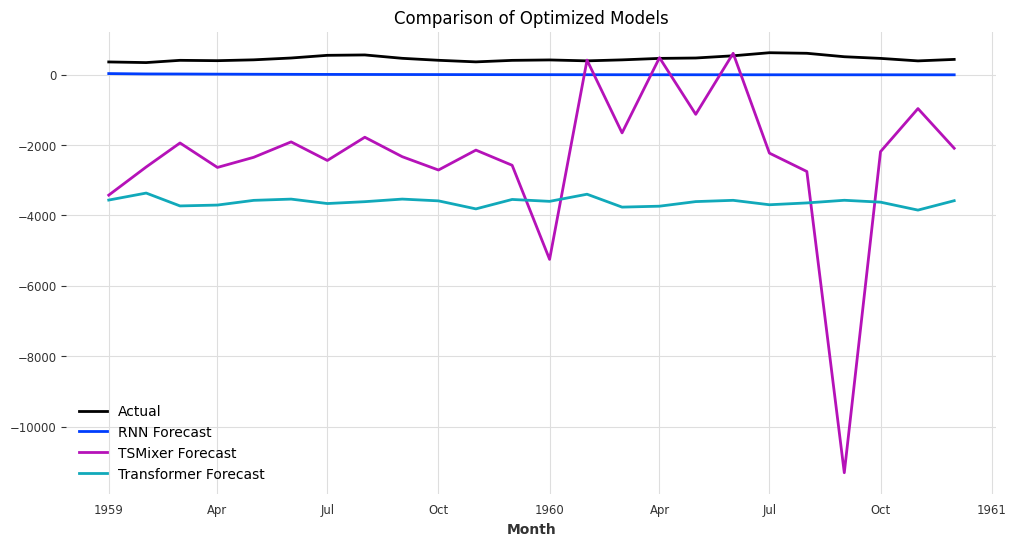

In [86]:
# Train models
best_rnn_model.fit(train_scaled)
best_tsmixer_model.fit(train_scaled)
best_transformer_model.fit(train_scaled)

# Make predictions
rnn_forecast = best_rnn_model.predict(len(test_scaled))
tsmixer_forecast = best_tsmixer_model.predict(len(test_scaled))
transformer_forecast = best_transformer_model.predict(len(test_scaled))

# Inverse transform the forecasts
rnn_forecast = scaler.inverse_transform(rnn_forecast)
tsmixer_forecast = scaler.inverse_transform(tsmixer_forecast)
transformer_forecast = scaler.inverse_transform(transformer_forecast)

# Calculate MAPE
rnn_mape = mape(test, rnn_forecast)
tsmixer_mape = mape(test, tsmixer_forecast)
transformer_mape = mape(test, transformer_forecast)

print(f"RNN MAPE: {rnn_mape:.2f}%")
print(f"TSMixer MAPE: {tsmixer_mape:.2f}%")
print(f"Transformer MAPE: {transformer_mape:.2f}%")

# Plot results
plt.figure(figsize=(12, 6))
test.plot(label='Actual')
rnn_forecast.plot(label='RNN Forecast')
tsmixer_forecast.plot(label='TSMixer Forecast')
transformer_forecast.plot(label='Transformer Forecast')
plt.legend()
plt.title('Comparison of Optimized Models')
plt.show()